In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import numpy as np
from functools import reduce

sns.set_theme()
pd.set_option('display.max_rows', 157)

In [2]:
df = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv', index_col='localminute', parse_dates=True, date_parser=lambda col: pd.to_datetime(col, utc=True))
df

dataid  meter_value
localminute                                          
2015-10-01 05:00:10+00:00            739        88858
2015-10-01 05:00:13+00:00           8890       197164
2015-10-01 05:00:20+00:00           6910       179118
2015-10-01 05:00:22+00:00           3635       151318
2015-10-01 05:00:22+00:00           1507       390354
...                                  ...          ...
2016-04-01 04:59:14.336743+00:00    2129       201726
2016-04-01 04:59:17.427165+00:00    2945       161232
2016-04-01 04:59:35.370782+00:00    9729       138146
2016-04-01 04:59:47.816286+00:00    5129       166488
2016-04-01 04:59:58.923080+00:00     484       114174

[1584823 rows x 2 columns]

# Question 1.1 
## Part A: How many houses are included in the measurement study?

The attribute, dataid is unique for each meter. As such, to count the total number of houses, we just need to count the number of unique dataid numbers. 

In [3]:
unique_households = df['dataid'].unique()

In [4]:
unique_households.sort()
unique_households

array([  35,   44,   77,   94,  114,  187,  222,  252,  370,  483,  484,
        661,  739,  744,  871, 1042, 1086, 1103, 1185, 1283, 1403, 1415,
       1507, 1556, 1589, 1619, 1697, 1714, 1718, 1790, 1791, 1792, 1800,
       1801, 2018, 2034, 2072, 2094, 2129, 2233, 2335, 2378, 2449, 2461,
       2470, 2575, 2638, 2645, 2755, 2814, 2818, 2945, 2946, 2965, 2980,
       3036, 3039, 3134, 3310, 3367, 3527, 3544, 3577, 3635, 3723, 3778,
       3849, 3893, 3918, 4029, 4031, 4193, 4228, 4296, 4352, 4356, 4373,
       4421, 4447, 4514, 4671, 4732, 4767, 4874, 4998, 5129, 5131, 5193,
       5275, 5317, 5395, 5403, 5439, 5484, 5545, 5636, 5658, 5785, 5810,
       5814, 5892, 5972, 6101, 6412, 6505, 6578, 6673, 6685, 6830, 6836,
       6863, 6910, 7016, 7017, 7030, 7117, 7287, 7429, 7460, 7566, 7674,
       7682, 7739, 7741, 7794, 7900, 7919, 7965, 7989, 8059, 8084, 8086,
       8155, 8156, 8244, 8386, 8467, 8703, 8829, 8890, 8967, 9052, 9121,
       9134, 9160, 9278, 9295, 9474, 9600, 9620, 96

In [5]:
print(f'Number of unique households: {len(unique_households)}')

Number of unique households: 157


## Part B: Are there any malfunctioning meters? If so, identify them and the time periods where they were malfunctioning. 

We know that the meter readings are all supposed to be cumulative. With this in mind, lets first check whether are there any meter readings that have a lower value at a later timestamp, i.e are not cumulative. 

In [6]:
uncumulative_vals = {}
uncumulative_vals_length = {}

# group by its unique id, then sort by timestamp
grouped_df = df.groupby(['dataid'], sort=['localminute'])

# obtain meters with uncummlative values
for meter_id, item in grouped_df:
    group = grouped_df.get_group(meter_id)['meter_value']
    
    # to look at the groupby result
    # print(grouped_df.get_group(meter_id), "\n\n")
    
    # initialize with 0 as minimum meter value cannot be below 0
    prev_meter_value = 0
    
    for index, curr_meter_value in group.iteritems():
        # check whether is it uncumlative
        if curr_meter_value < prev_meter_value:
            # if meter_id already present, append current uncumlative value and prev value with other such previous instances
            if meter_id in uncumulative_vals:
                uncumulative_vals[meter_id].append([prev_meter_value, curr_meter_value])
                uncumulative_vals_length[meter_id] += 1
            else: # meter_id not present, so create new 
                uncumulative_vals[meter_id] = []
                uncumulative_vals_length[meter_id] = 1
                uncumulative_vals[meter_id].append([prev_meter_value, curr_meter_value])
        prev_meter_value = curr_meter_value
 

temp_df = pd.DataFrame.from_dict(uncumulative_vals_length, orient="index")
temp_df.reset_index(inplace=True)
temp_df.rename(columns={0: "No of uncumulative readings", "index":"dataid"}, inplace=True)
temp_df

dataid  No of uncumulative readings
0       35                            1
1       77                            1
2       94                            6
3      483                            1
4      484                            9
5     1042                            1
6     1086                            1
7     1185                          135
8     1507                            2
9     1556                           12
10    1718                            4
11    1790                            1
12    1801                            1
13    2129                            3
14    2335                            5
15    2449                           93
16    3134                           18
17    3527                            1
18    3544                           18
19    3893                            2
20    4031                           16
21    4193                            1
22    4514                          141
23    4998                            1
24    5129                           76
25    5131                            1
26    5193                            4
27    5403                          156
28    5810                           10
29    5814                            1
30    5892                            1
31    6836                           51
32    7017                            1
33    7030                           90
34    7117                          123
35    7739                            1
36    7794                            1
37    7989                            2
38    8156                          151
39    8890                           44
40    9134                          115
41    9639                            2
42    9982                            2

As can be seen above, there are 43 meters that have uncumulative values, at times. The total number of uncumulative readings obtained for each meter is also reflected above. Now, for each meter, lets find out the ratio of uncumulative readings to the total readings sent out by the respective meter. Also, for each meter, lets calculate the average drop in meter readings. 

In [7]:
def analysis(row):
    meter_id = row["dataid"]
    values = row["No of uncumulative readings"]
    values_list = uncumulative_vals[meter_id]
    
    new_row = row
    new_row["Average decrease across uncumulative readings"] = reduce(lambda x, y: x + abs(y[1] - y[0]) / values, [0] + values_list)
    new_row["Percentage of uncumulative readings"] = (values / grouped_df.get_group(meter_id).shape[0]) * 100
    
    new_row["dataid"] = new_row["dataid"].astype(np.int64)
    
    return new_row

In [8]:
temp_df2 = temp_df.apply(lambda x:analysis(x), axis=1)
temp_df2

dataid  No of uncumulative readings  \
0     35.0                          1.0   
1     77.0                          1.0   
2     94.0                          6.0   
3    483.0                          1.0   
4    484.0                          9.0   
5   1042.0                          1.0   
6   1086.0                          1.0   
7   1185.0                        135.0   
8   1507.0                          2.0   
9   1556.0                         12.0   
10  1718.0                          4.0   
11  1790.0                          1.0   
12  1801.0                          1.0   
13  2129.0                          3.0   
14  2335.0                          5.0   
15  2449.0                         93.0   
16  3134.0                         18.0   
17  3527.0                          1.0   
18  3544.0                         18.0   
19  3893.0                          2.0   
20  4031.0                         16.0   
21  4193.0                          1.0   
22  4514.0                        141.0   
23  4998.0                          1.0   
24  5129.0                         76.0   
25  5131.0                          1.0   
26  5193.0                          4.0   
27  5403.0                        156.0   
28  5810.0                         10.0   
29  5814.0                          1.0   
30  5892.0                          1.0   
31  6836.0                         51.0   
32  7017.0                          1.0   
33  7030.0                         90.0   
34  7117.0                        123.0   
35  7739.0                          1.0   
36  7794.0                          1.0   
37  7989.0                          2.0   
38  8156.0                        151.0   
39  8890.0                         44.0   
40  9134.0                        115.0   
41  9639.0                          2.0   
42  9982.0                          2.0   

    Average decrease across uncumulative readings  \
0                                        2.000000   
1                                        2.000000   
2                                        9.000000   
3                                       14.000000   
4                                        2.444444   
5                                        2.000000   
6                                        2.000000   
7                                    16267.674074   
8                                        2.000000   
9                                    13574.000000   
10                                       5.000000   
11                                       2.000000   
12                                       2.000000   
13                                       2.000000   
14                                   22942.000000   
15                                   15472.860215   
16                                   12877.222222   
17                                       2.000000   
18                                    8488.222222   
19                                       2.000000   
20                                       2.875000   
21                                       2.000000   
22                                   23971.815603   
23                                      14.000000   
24                                   11116.815789   
25                                       2.000000   
26                                       5.000000   
27                                   10897.371795   
28                                       4.600000   
29                                       2.000000   
30                                       2.000000   
31                                   11397.176471   
32                                       4.000000   
33                                   17217.155556   
34                                   16809.414634   
35                                       2.000000   
36                                       6.000000   
37                                      26.000000   
38                                   16260.6

As shown above, all the meters' percentage of uncumulative readings are below 2%. Hence, our group has decided to use the average decrease across uncumulative readings as a benchmark to decide which meters might be faulty.   

After doing a manual inspection, we have decided to define our threshold to be above 1000 because firstly, a drop of 1000 cubic feet is indeed a big drop and cannot be easily ignored. Second, the readings above 1000 are sufficient to indicate an anomaly.

In [54]:
# filter average readings that are above 1000
temp_df2[temp_df2["Average decrease across uncumulative readings"] > 1000]

dataid  No of uncumulative readings  \
7   1185.0                        135.0   
9   1556.0                         12.0   
14  2335.0                          5.0   
15  2449.0                         93.0   
16  3134.0                         18.0   
18  3544.0                         18.0   
22  4514.0                        141.0   
24  5129.0                         76.0   
27  5403.0                        156.0   
31  6836.0                         51.0   
33  7030.0                         90.0   
34  7117.0                        123.0   
38  8156.0                        151.0   
40  9134.0                        115.0   
41  9639.0                          2.0   
42  9982.0                          2.0   

    Average decrease across uncumulative readings  \
7                                    16267.674074   
9                                    13574.000000   
14                                   22942.000000   
15                                   15472.860215   
16                                   12877.222222   
18                                    8488.222222   
22                                   23971.815603   
24                                   11116.815789   
27                                   10897.371795   
31                                   11397.176471   
33                                   17217.155556   
34                                   16809.414634   
38                                   16260.622517   
40                                   32439.008696   
41                                   29376.000000   
42                                   14036.000000   

    Percentage of uncumulative readings  
7                              0.731469  
9                              0.325203  
14                             0.056117  
15                             1.706735  
16                             0.448096  
18                             0.810446  
22                             0.739226  
24                             1.694160  
27                             0.610353  
31                             1.128319  
33                             0.502372  
34                             0.600205  
38                             0.596932  
40                             0.817691  
41                             0.014497  
42                             0.129870

We now have established the criteria for deciding what constitues a malfunctioning meter. The meters that have readings that fail our criteria are shown above. We will now demonstrate that we can consolidate faulty readings into time periods.

In [9]:
# obtain and parse data 
df2 = pd.read_csv('dataport-export_gas_oct2015-mar2016.csv', parse_dates=['localminute'])
grouped = df2.groupby(['dataid'], sort=['localminute'])

In [10]:
def get_faulty_readings(meter_readings):
    """
    Responsible for obtaining a list of times when the meter reading was uncumulative given our threshold (1000).  
    """
    total_readings = meter_readings.shape[0]
    faulty_times = []
    for i in range(1, total_readings):
        if meter_readings.iloc[i].meter_value < (meter_readings.iloc[i-1].meter_value - 1000):  
            faulty_times.append(meter_readings.iloc[i])
        
    return faulty_times

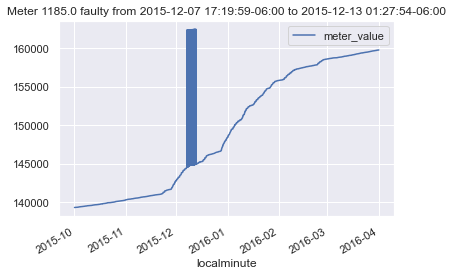

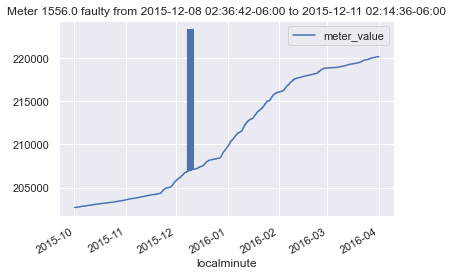

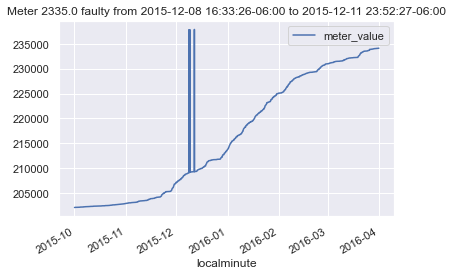

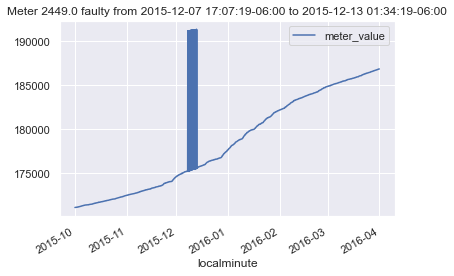

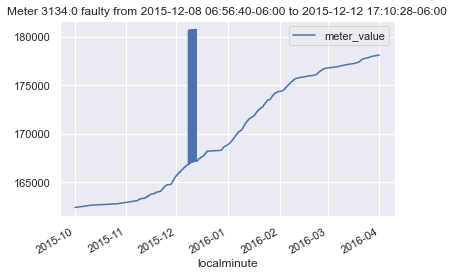

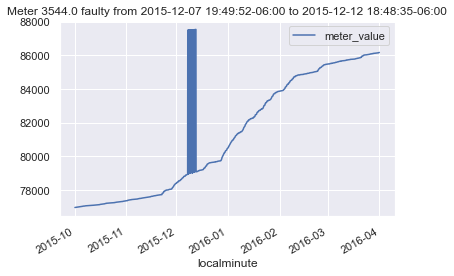

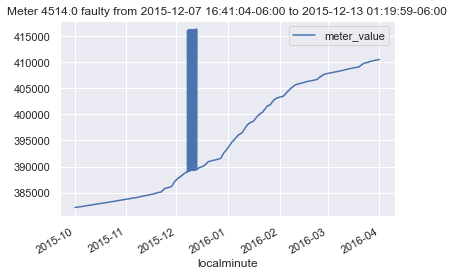

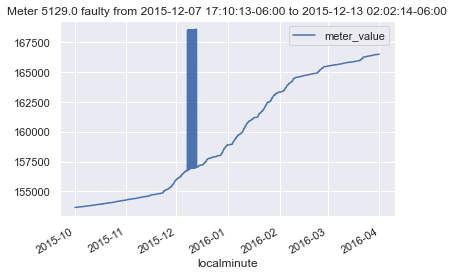

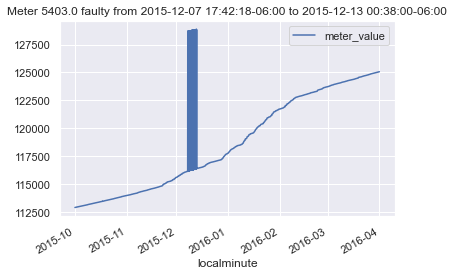

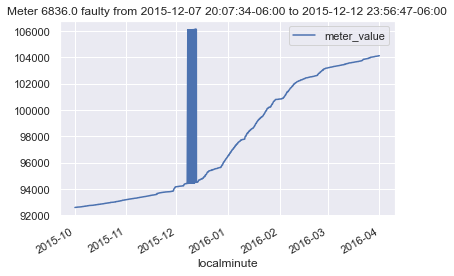

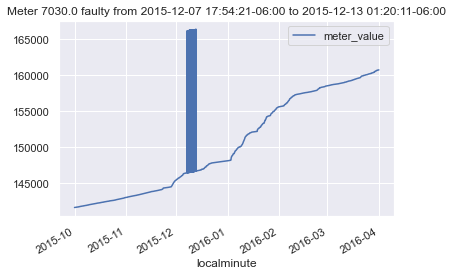

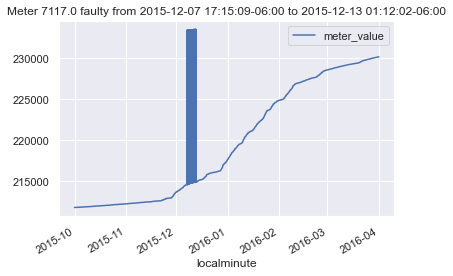

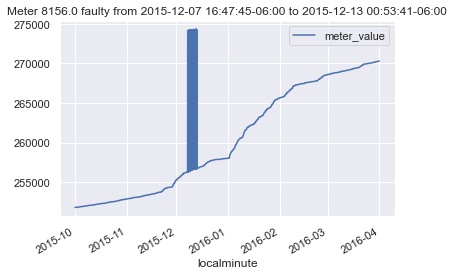

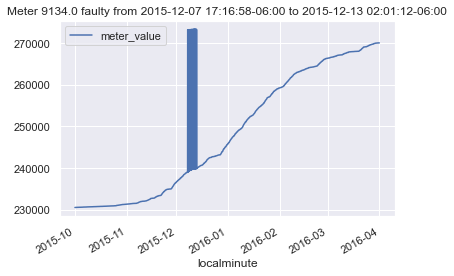

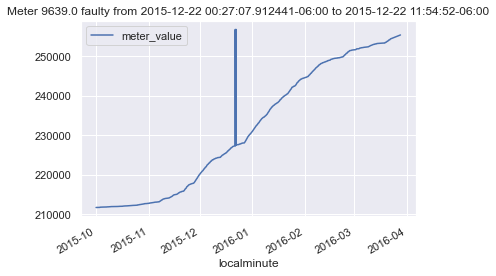

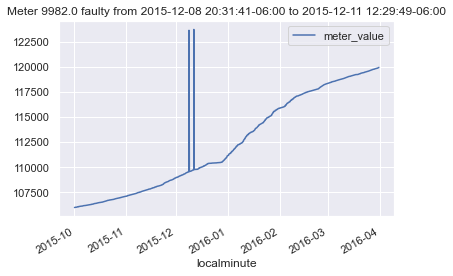

In [11]:
# obtain list of faulty meters according to our criteria
faulty_ids = temp_df2[temp_df2["Average decrease across uncumulative readings"] > 1000].dataid

# print faulty time period and plot to verify.
for id in faulty_ids:
    most_faulty_meter = grouped.get_group(id)
    faulty_time_periods = get_faulty_readings(most_faulty_meter)
    meter_title = f'Meter {id} faulty from {faulty_time_periods[0].localminute} to {faulty_time_periods[-1].localminute}'
    most_faulty_meter.plot(x='localminute',y='meter_value', title=meter_title)
    

### Insights
As can be seen from our graphs above, almost all the faulty readings (except for those belonging to dataid 9639) occured around the same time period, between 7th December 2015 and 13th December 2015. This is an interesting find because this possibly indicates an malfunction in the system rather than the individual meters themselves. Hence, instead of labeling these meters as faulty, the gas provider might want to debug and check what exactly happened during the specified time period to determine the exact cause for the malfunctionings. 

### Additional Note
Initially, we had also wanted to consider readings where the marginal consumption was lesser than 2 cubic feet. However, when we analysed them, there were a lot of meters with such readings (155 meters to be exact). We assumed that these readings were a way for the gas company to know whether the meter was still working properly. As such, we decided to not include this in our criteria. 

# Q1.2 
## Hourly Data Collection and Plotting the Data

### Approach

For a particular meter, we are going to have maximum 4 readings every minute (if the cumulative gas consumption measured every 15 seconds by the meter is ”reported” to the MDMS as it is at least 2 cubic foot higher than the previous reading). 

As such, for every hour, we are going to have maximum 240 readings (60 mins * 4 = 240). 

Out of all the readings that we obtain for a particular hour, our approach is to pick the last reading of that hour. This reading will be subsequently be used as an estimate of that hour's cumulative gas consumption data. This is because, in our case, this reading would be the most suitable in approximating the consumption amount during the hour.  

However, with this approach, there are two considerations to be made, which are reflected below:

### Additional Considerations

#### Missing Data

The first consideration is when we have absolutely no data for a particular hour. In such a scenario, we can simply assume that there has not been any significant gas consumption during the time period. As such, for that particular hour, we will use the most recent hourly data obtained. 

#### Uncumulative Data
The second consideration is when the reading is uncumulative, or in other words, has a lower value than the previous hourly data obtained. In this case, we are probably more interested in obtaining and visualizaing the general hourly consumption level rather than looking for faulty meters or any decrease in gas consumption, which we discussed in the previous question. As such, we will not consider this case for this question. 

For this question, we have chosen to plot the hourly readings for the month of December, 2015 
(i.e from 2015-12-01 00:00:00+00:00 to 2015-12-31 23:59:59+00:00)

We have chosen this month for closer observation as we felt that we might obtain some interesting insights about the data, considering that this is a holiday month in the US. For instance, it is common for people to stay at home during work hours or go for a vacation during the entire holidays. As such, we would like to explore this data more.  

In [12]:
def plot_hourly_df(df, dataid):
    """
    Plot hourly readings against cumulative data
    """
    x = pd.to_datetime(df.index).array.to_numpy()
    y = df.array.to_numpy()
    plt.figure(figsize=(16, 5), dpi=100)
    plt.title('dataid ' + str(dataid))
    plt.plot(x, y)

Since the meter readings are cummulative, it would be more suitable to interpolate them rather than forward filling them. This will ensure that the data is more apt for linear regression analysis, which we will do in question 2. Forward filling would be better for the analysis of non-cumulative hourly usage. 

<ipython-input-12-193811361870>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(16, 5), dpi=100)


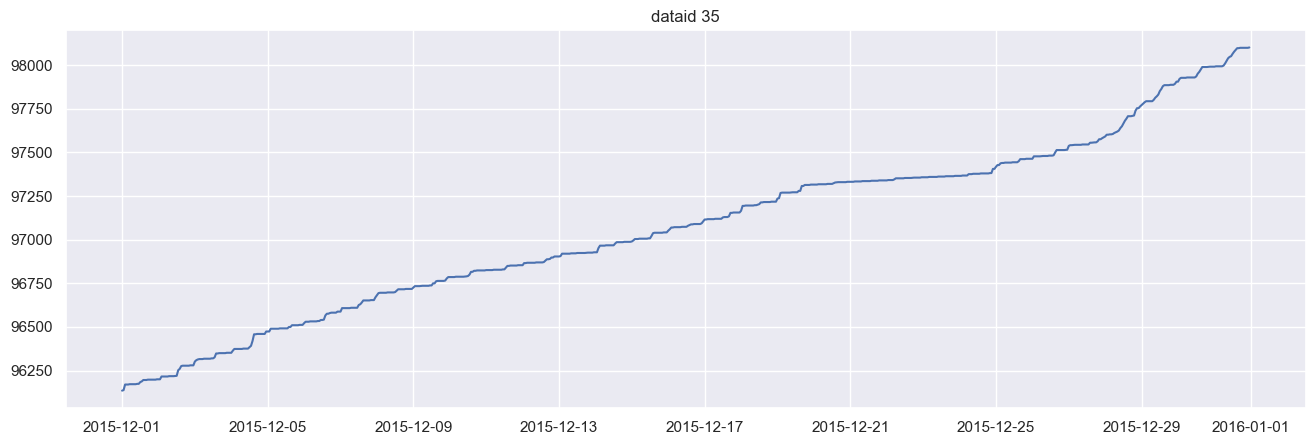

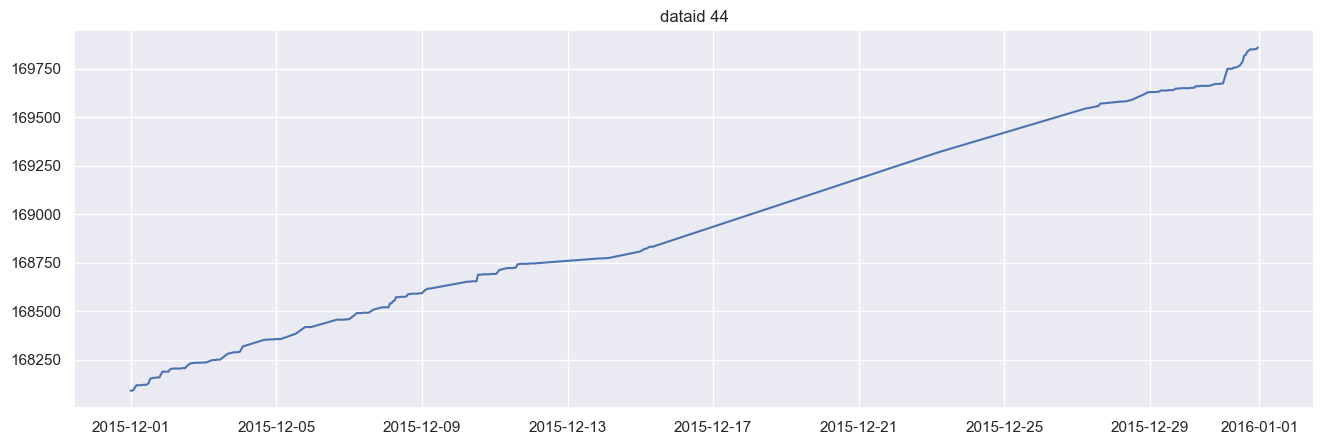

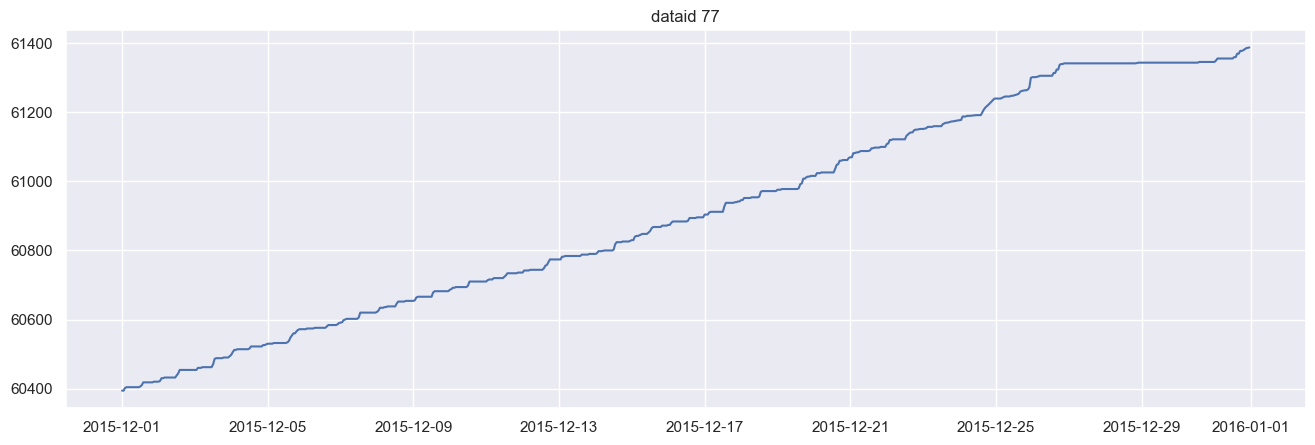

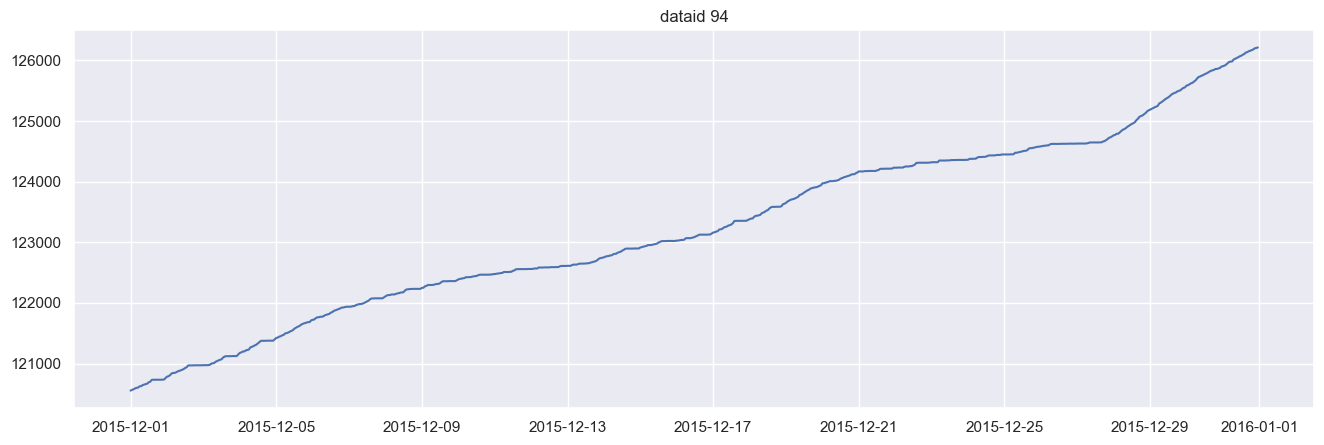

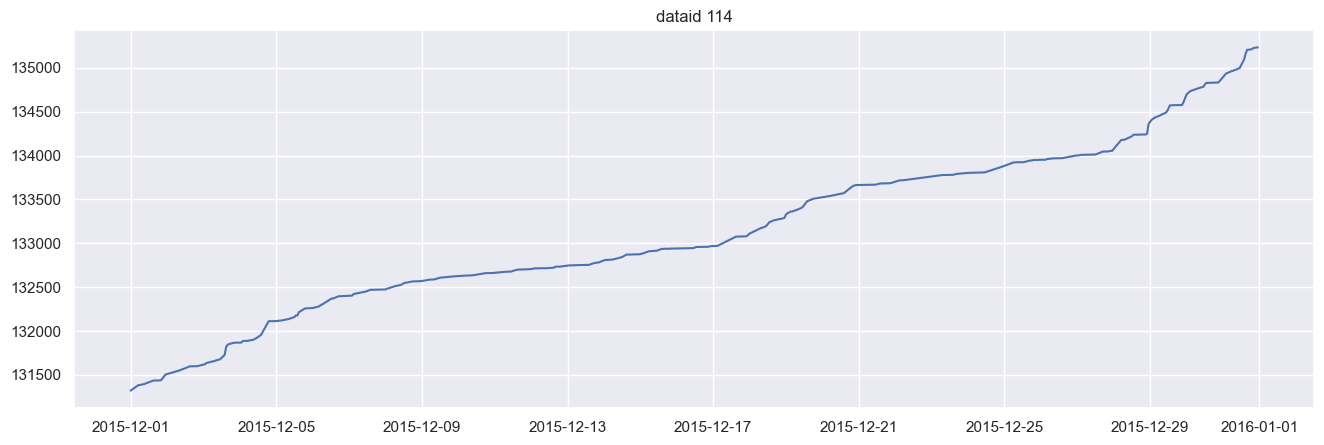

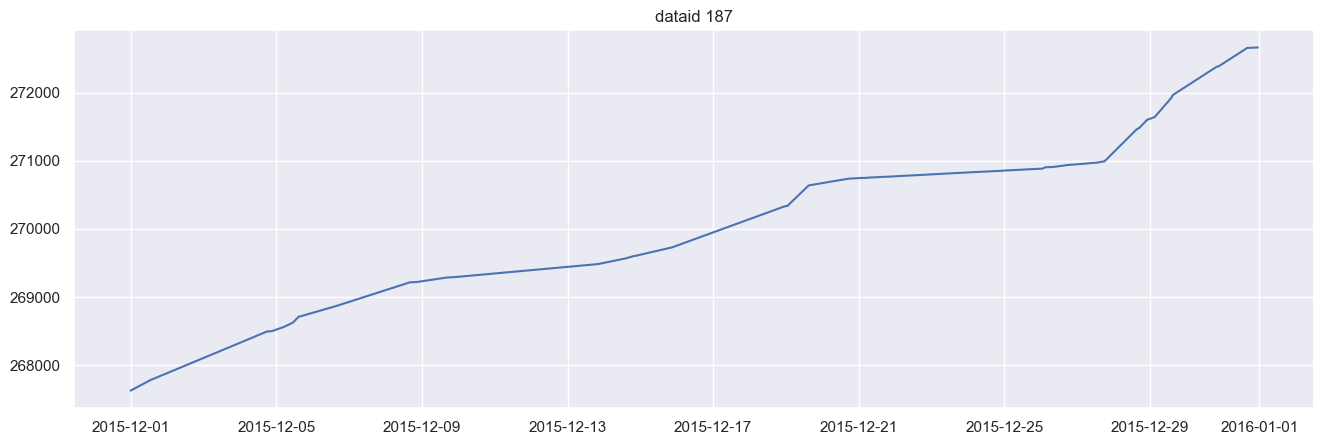

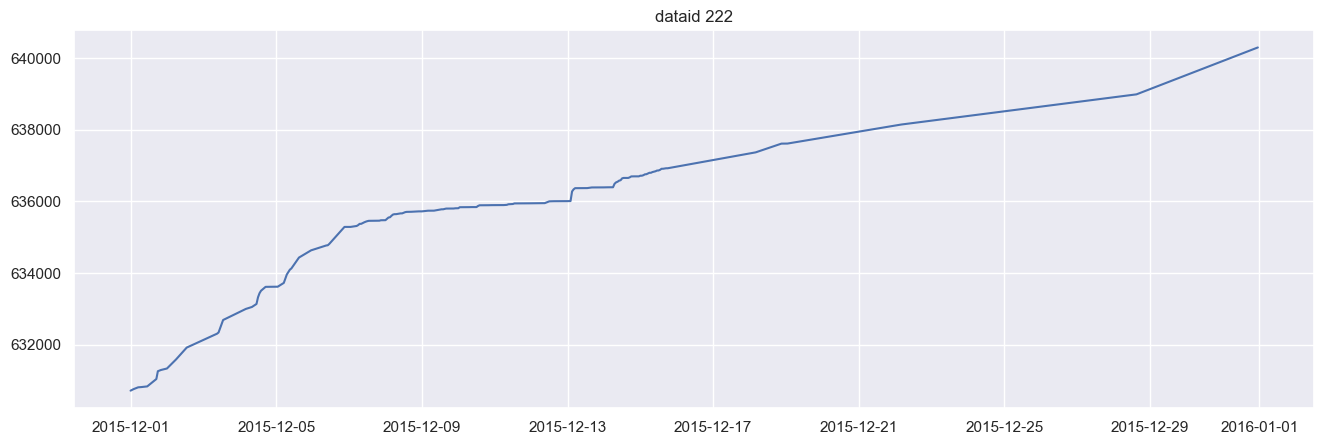

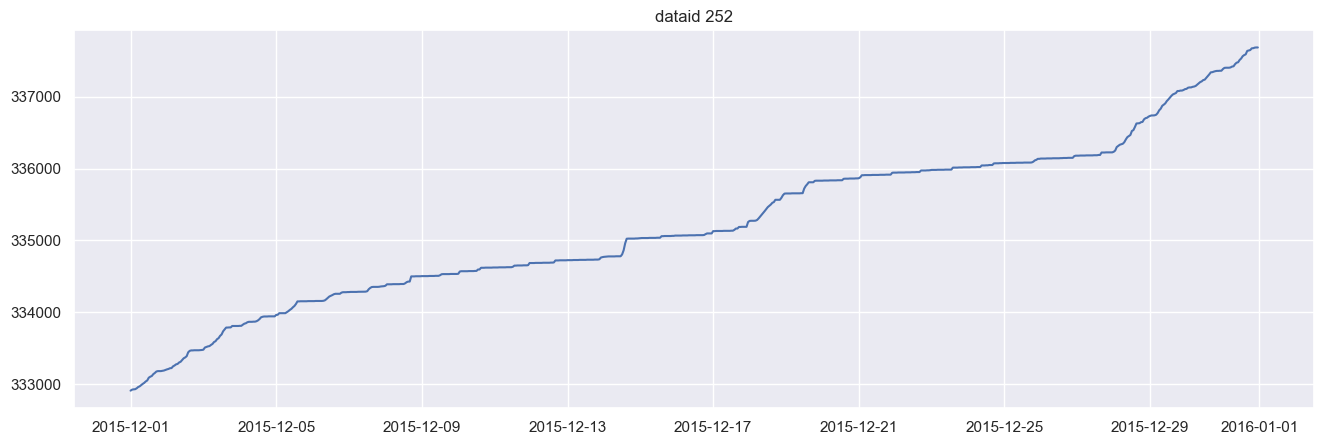

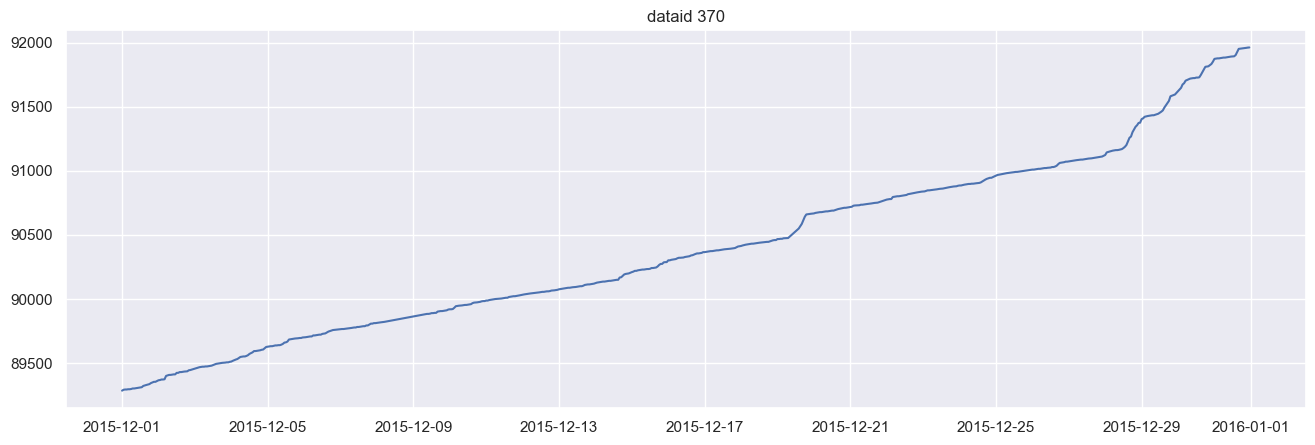

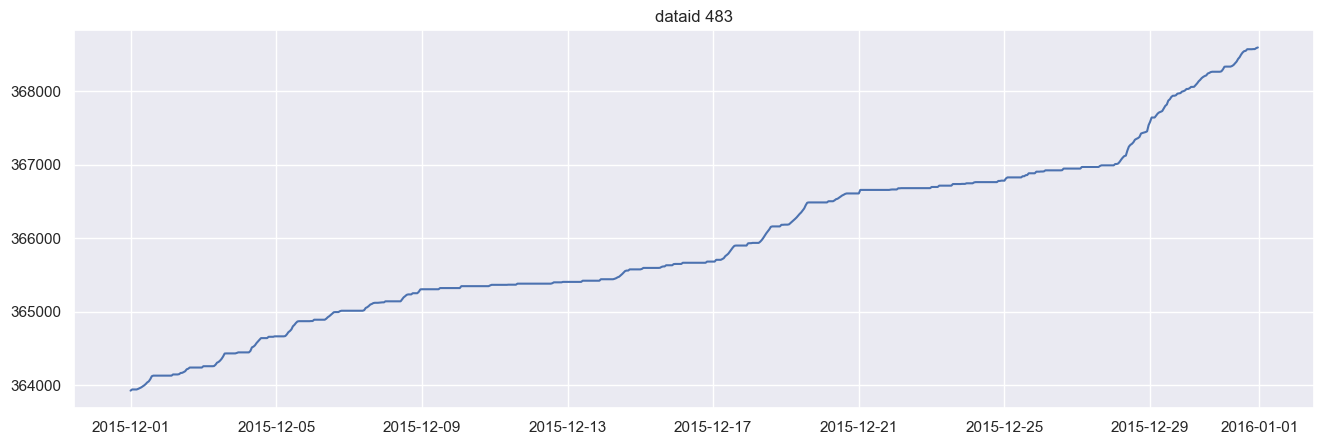

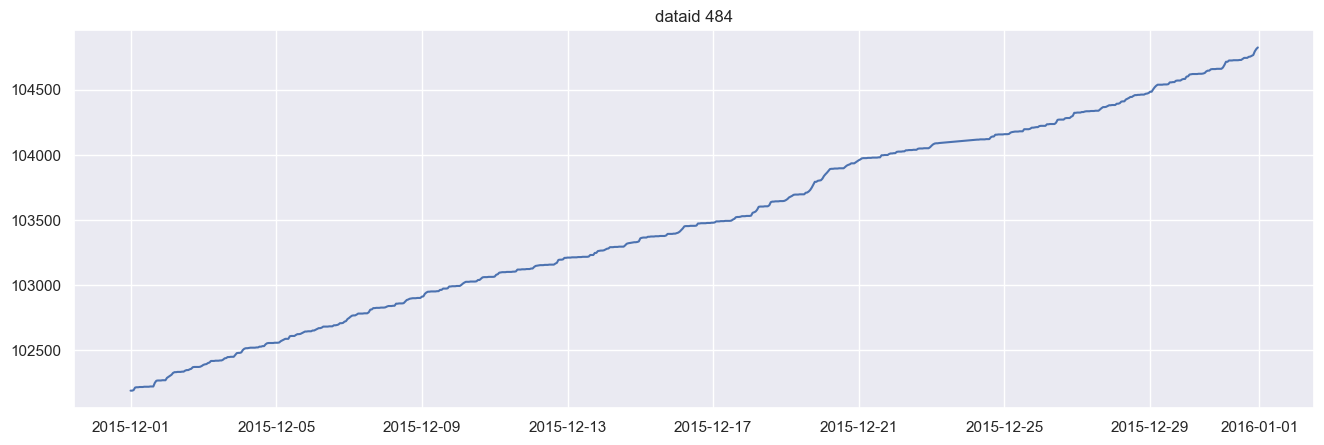

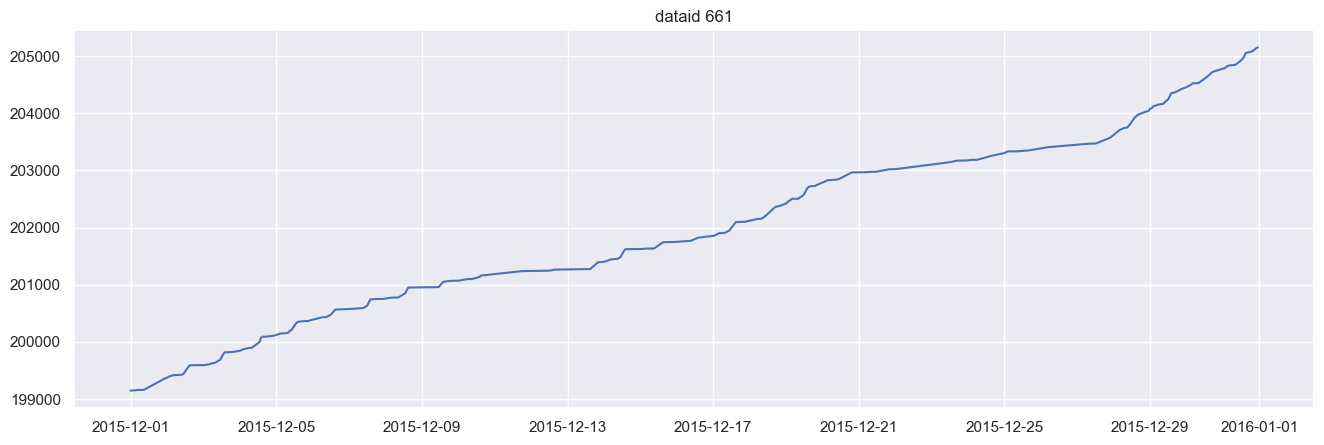

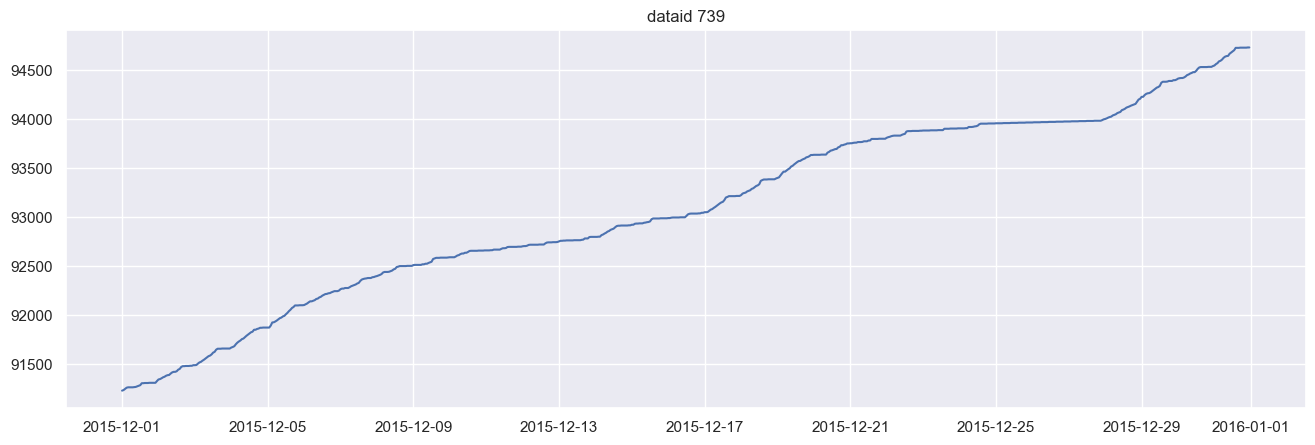

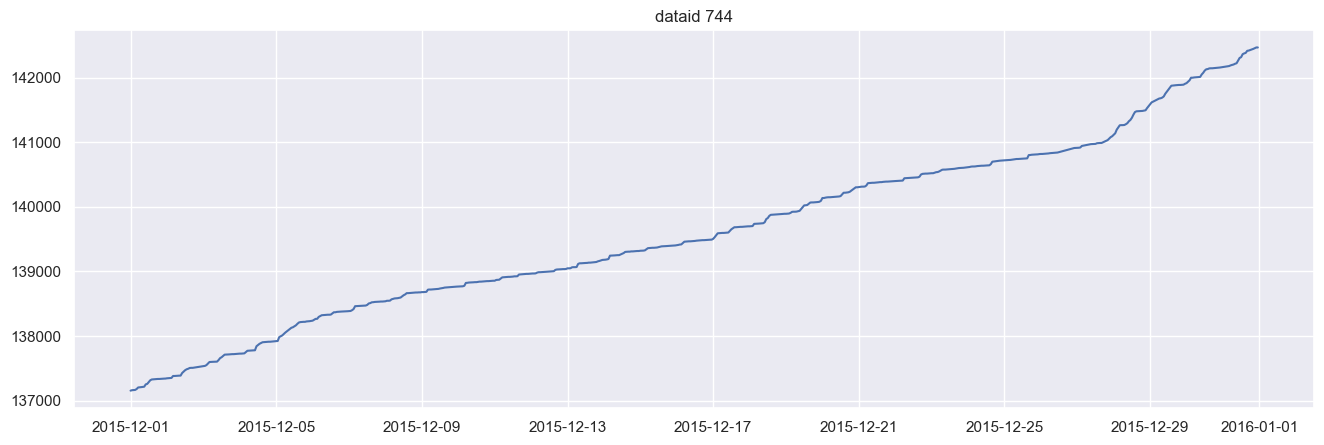

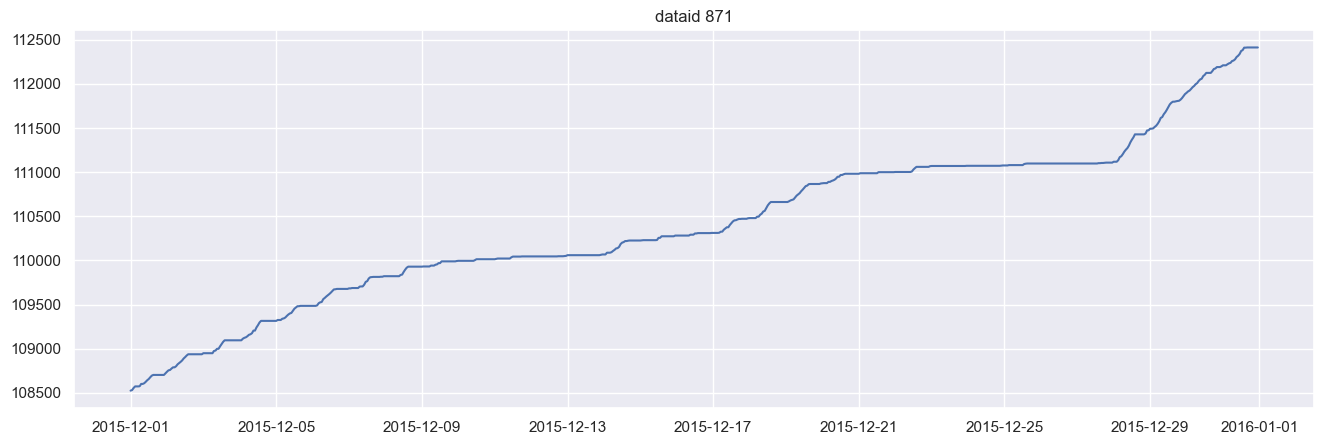

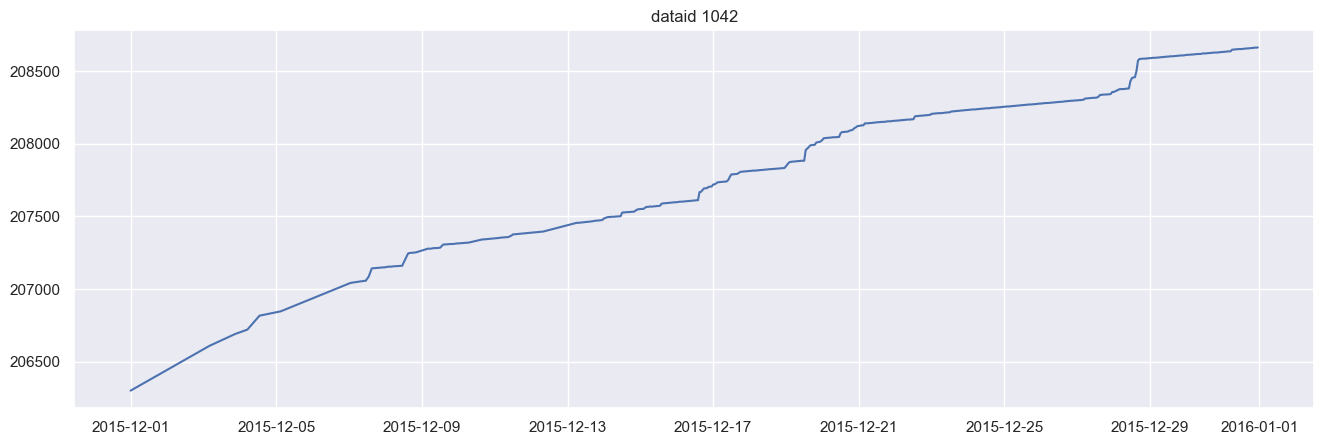

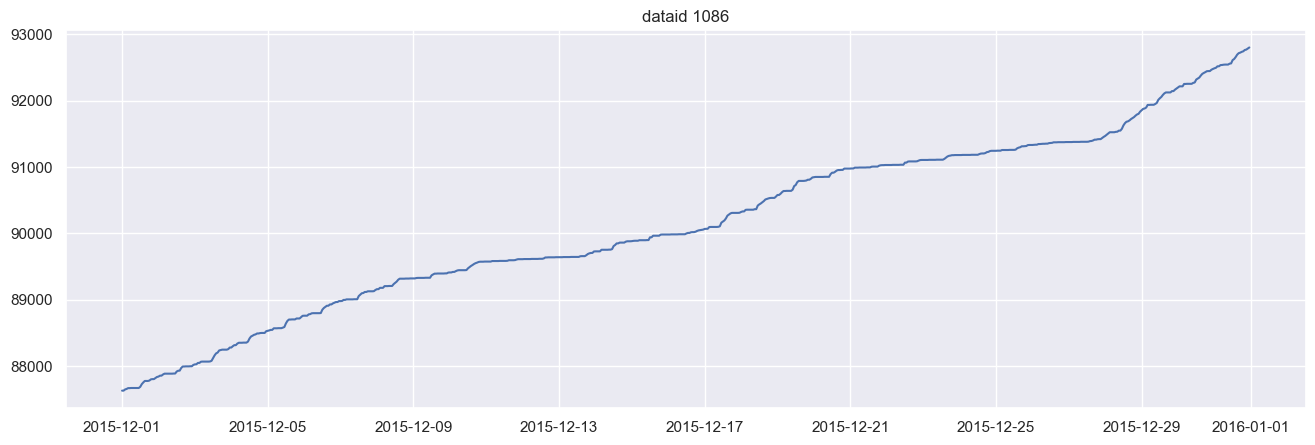

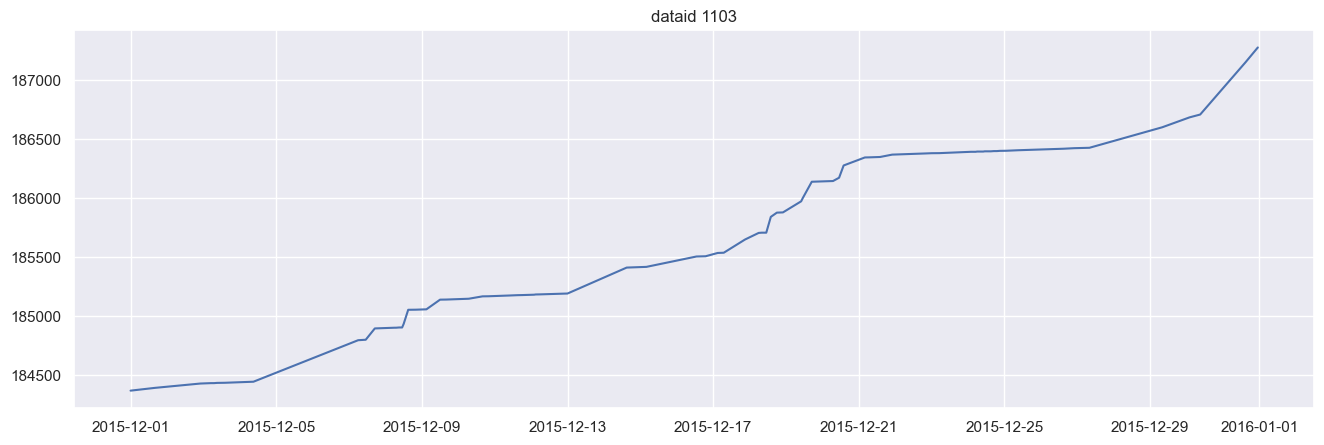

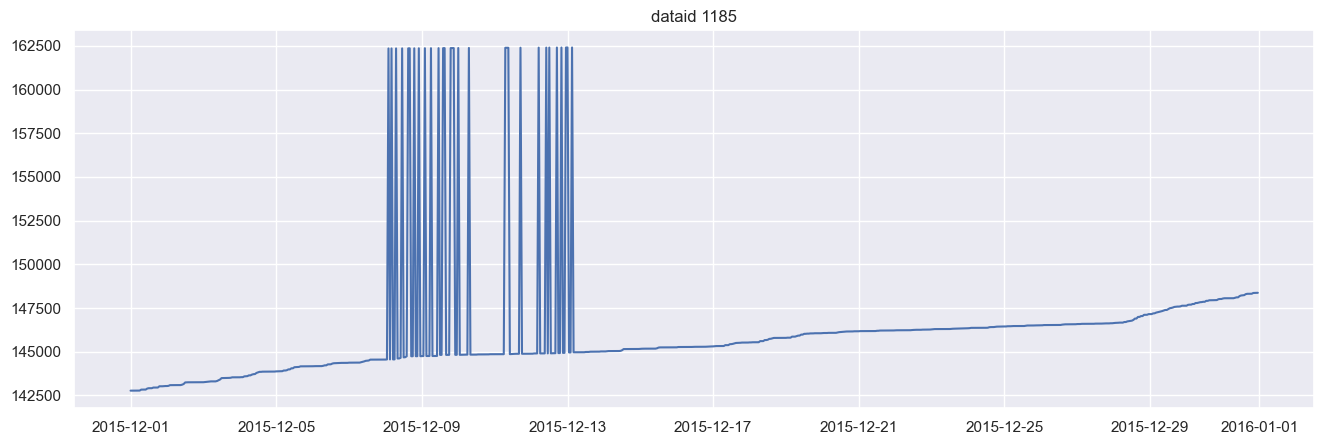

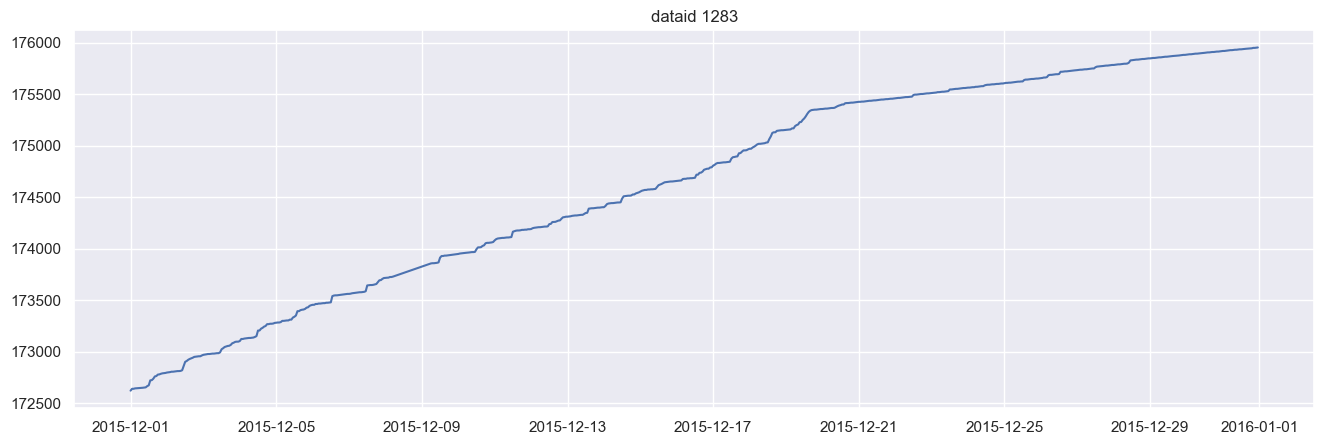

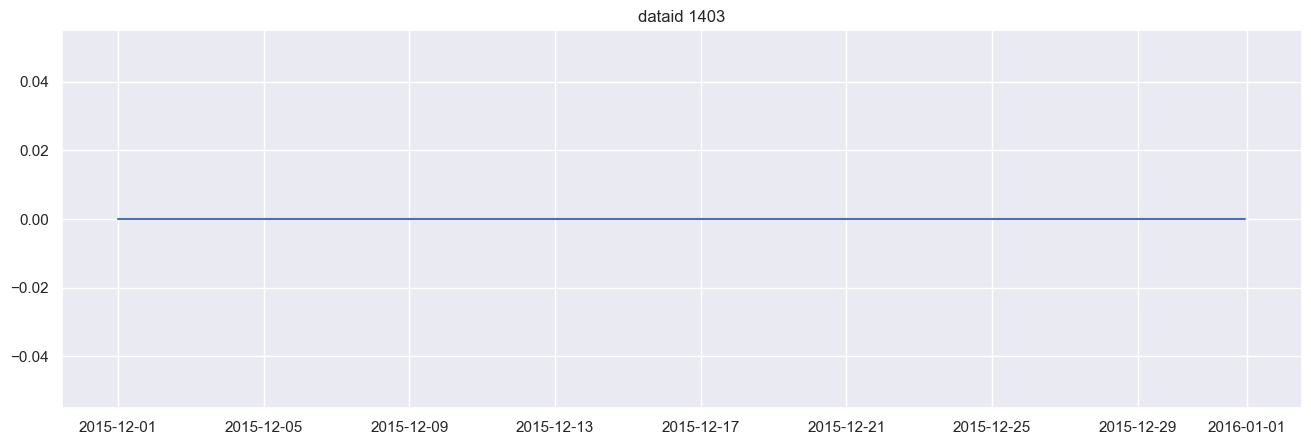

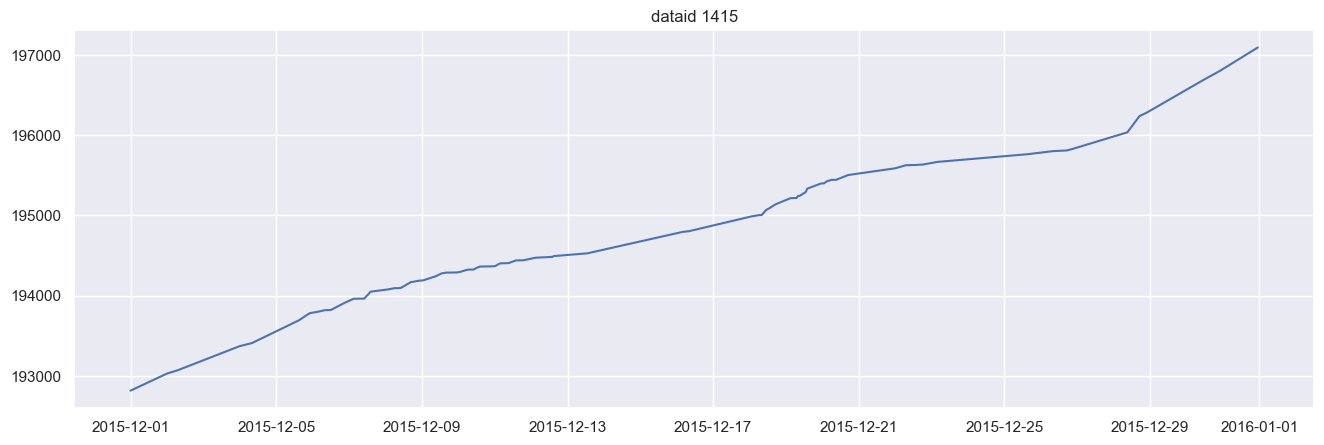

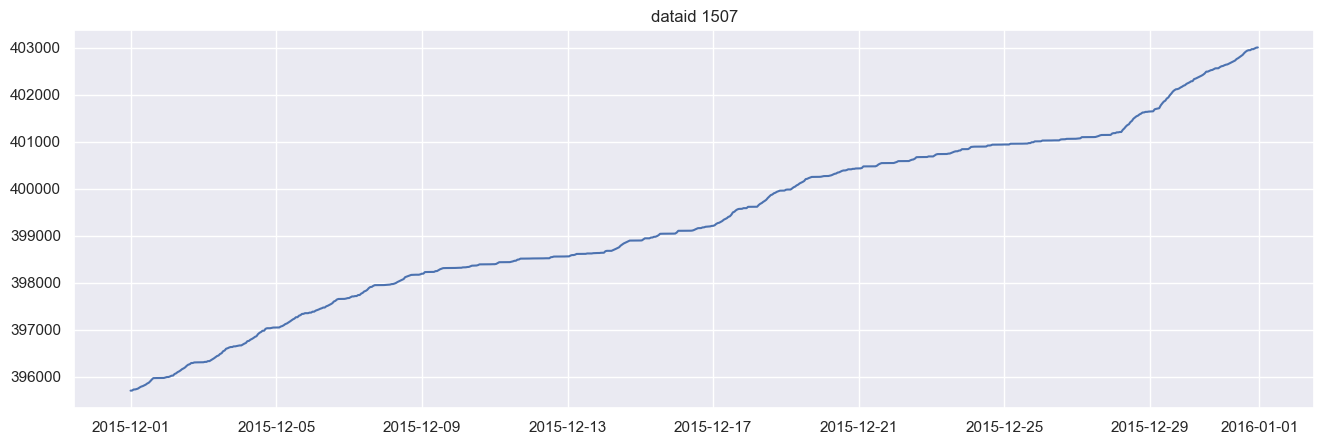

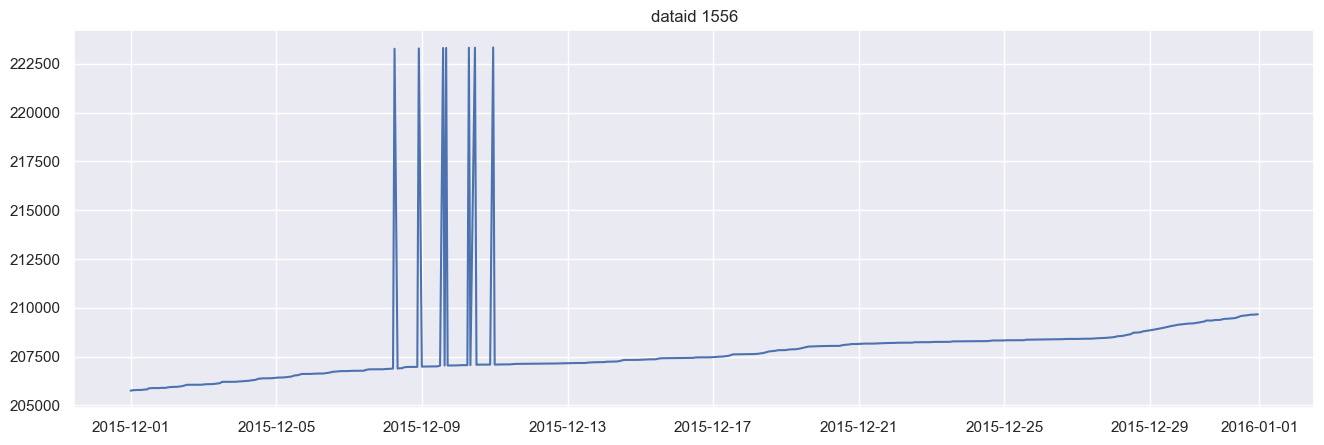

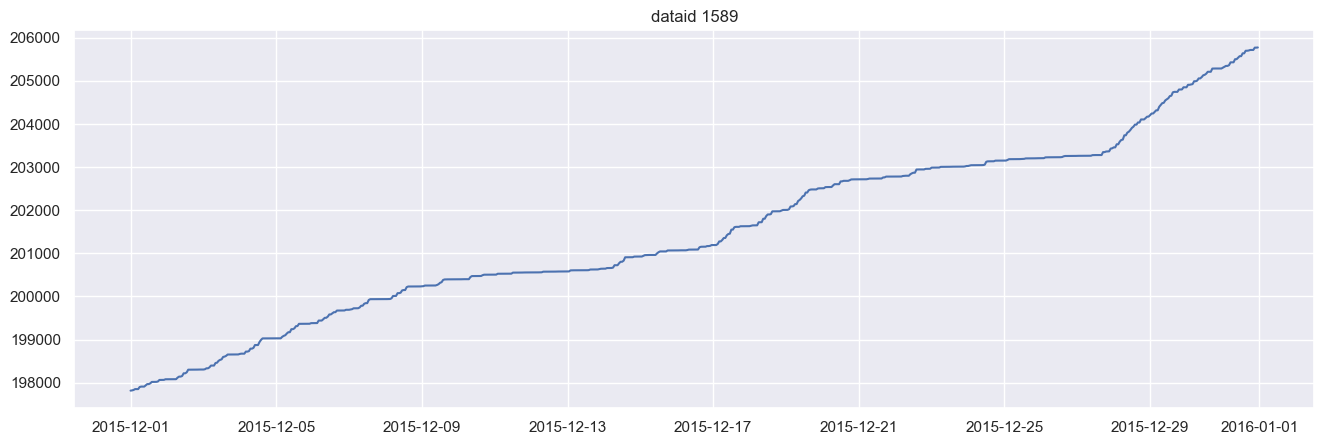

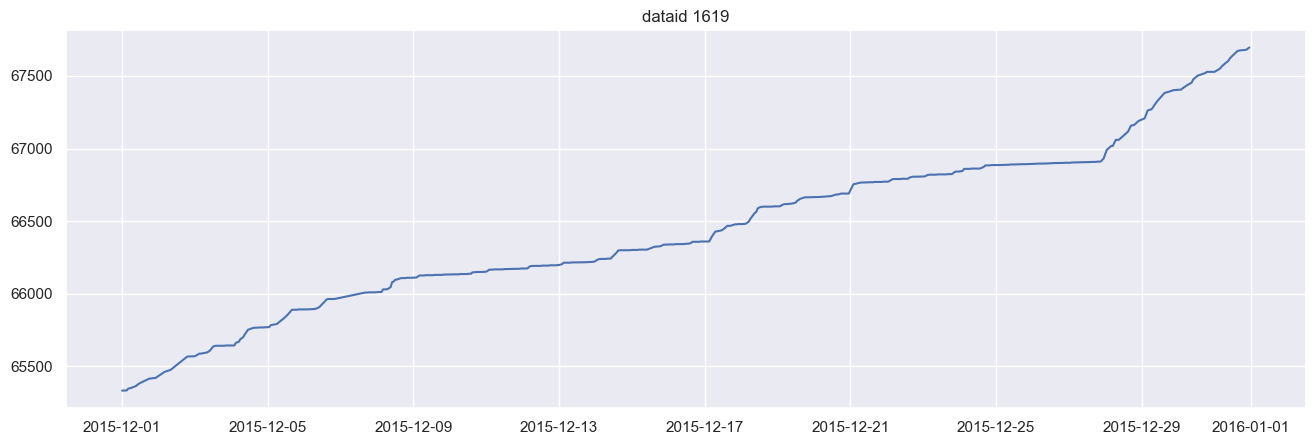

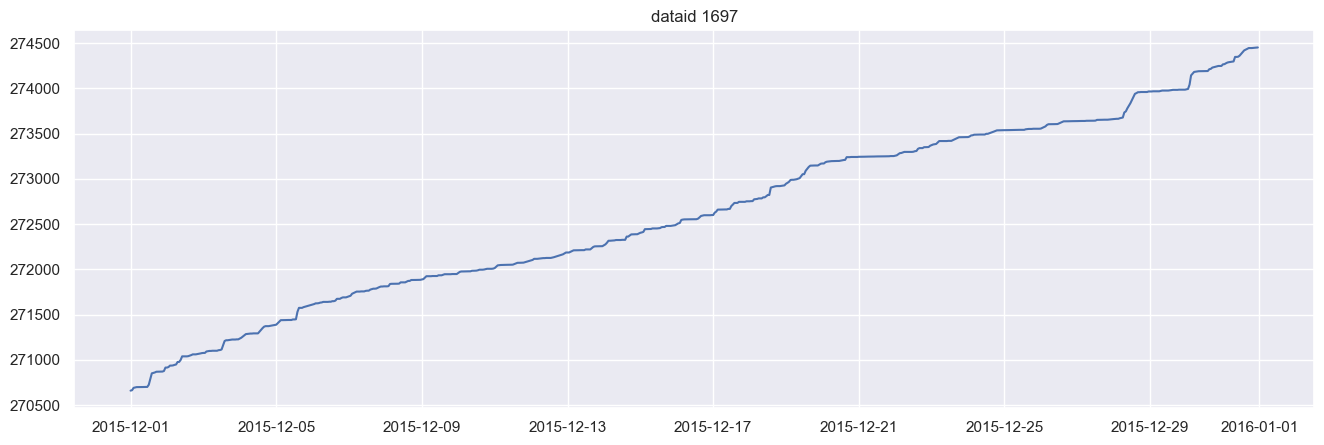

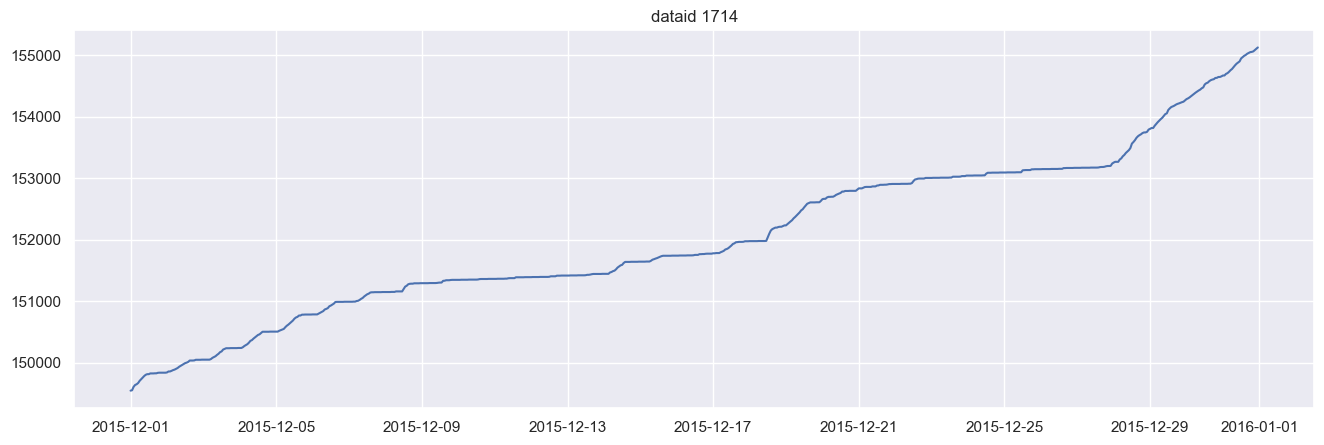

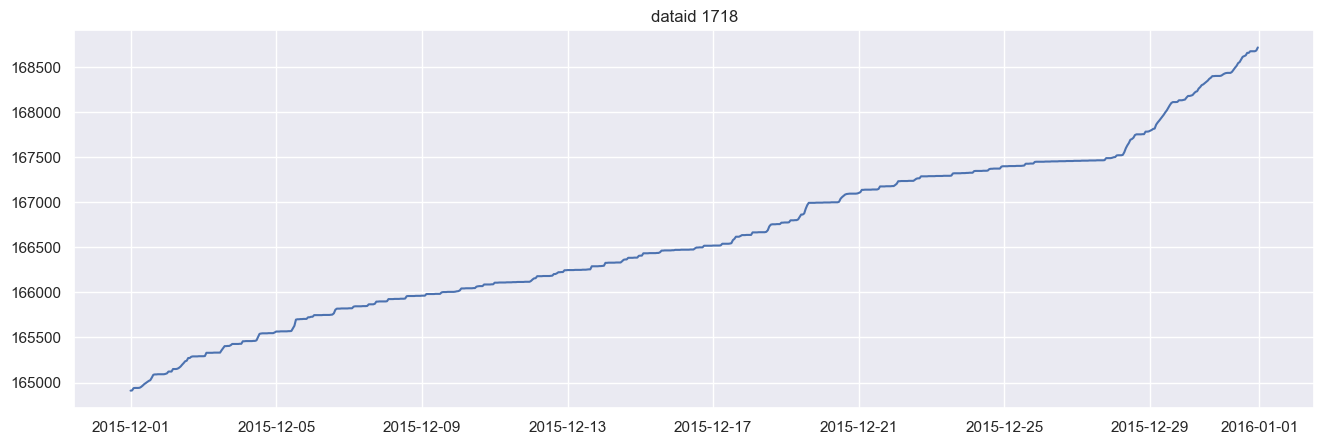

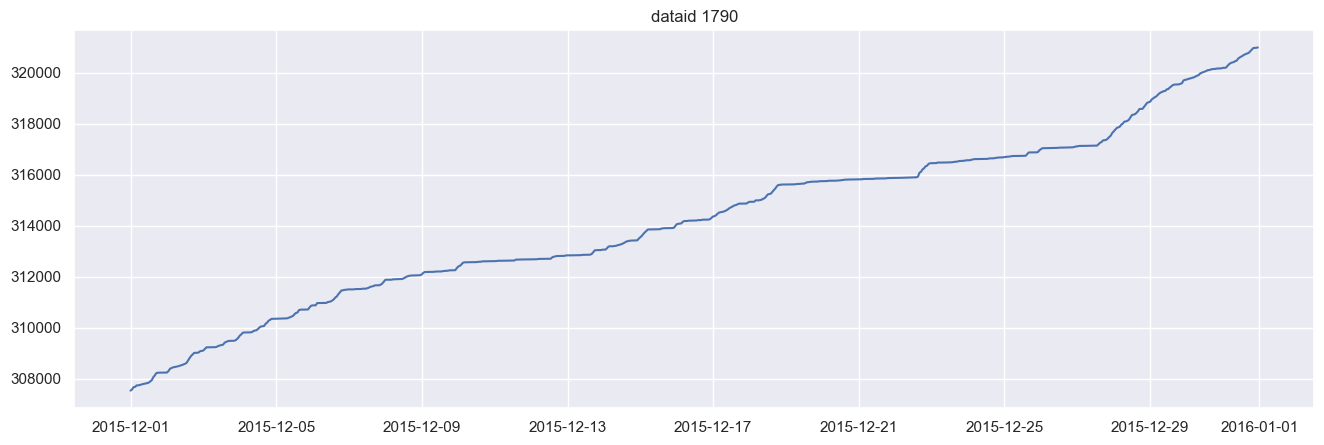

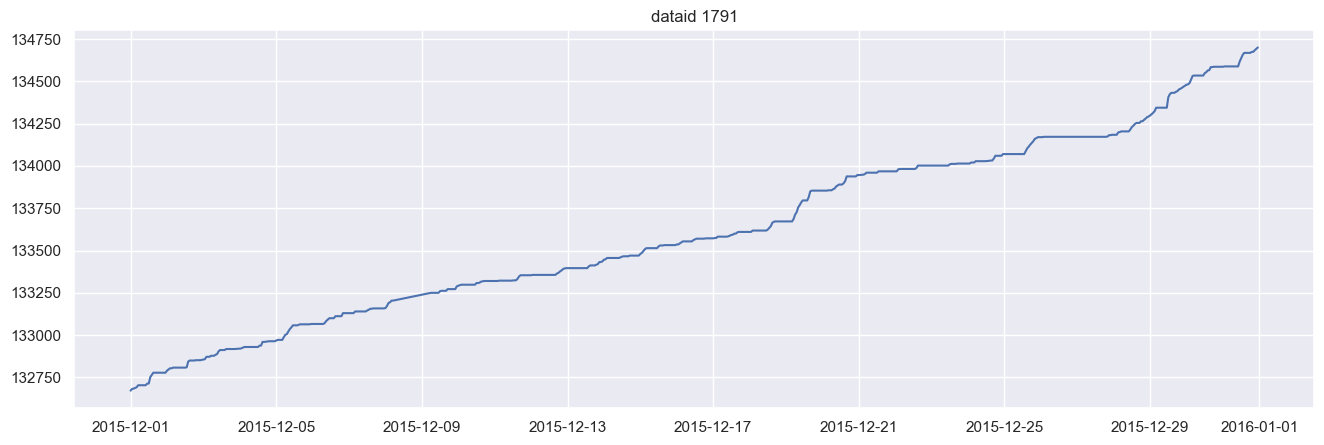

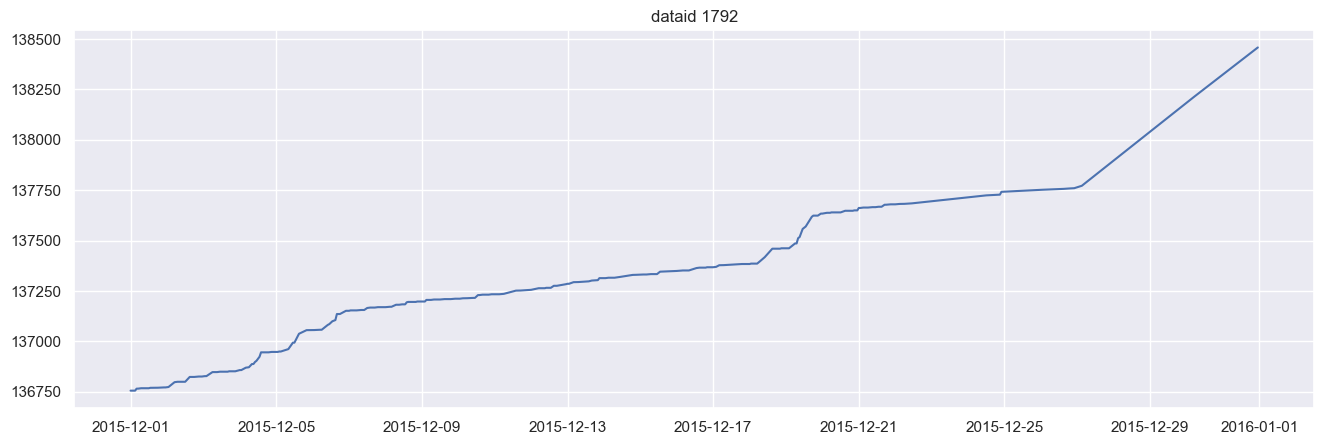

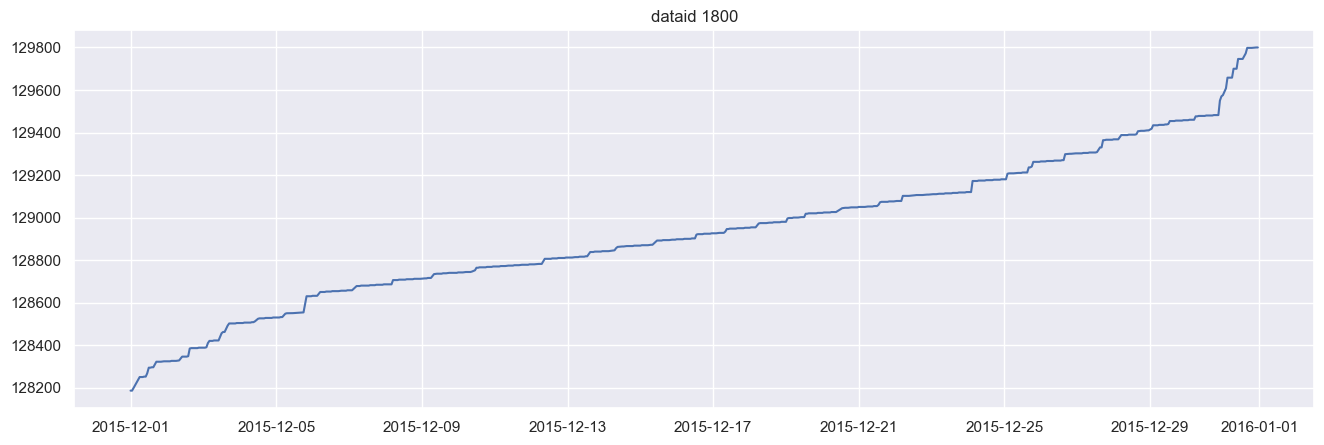

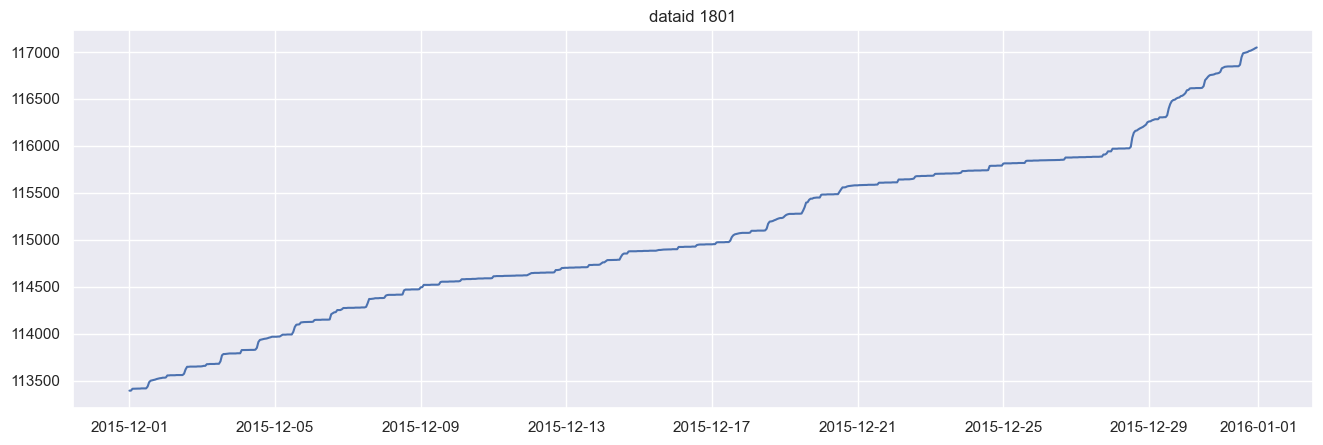

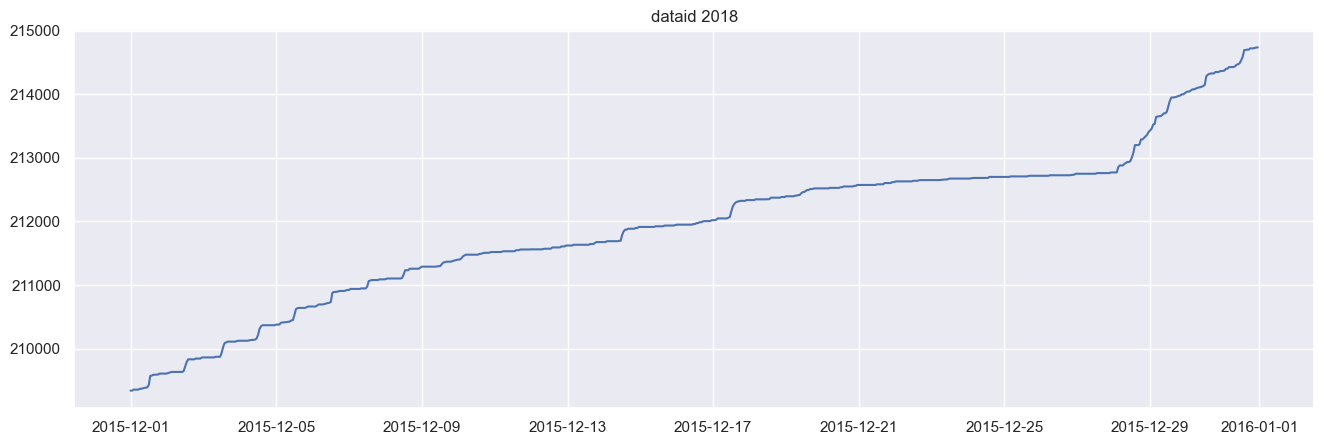

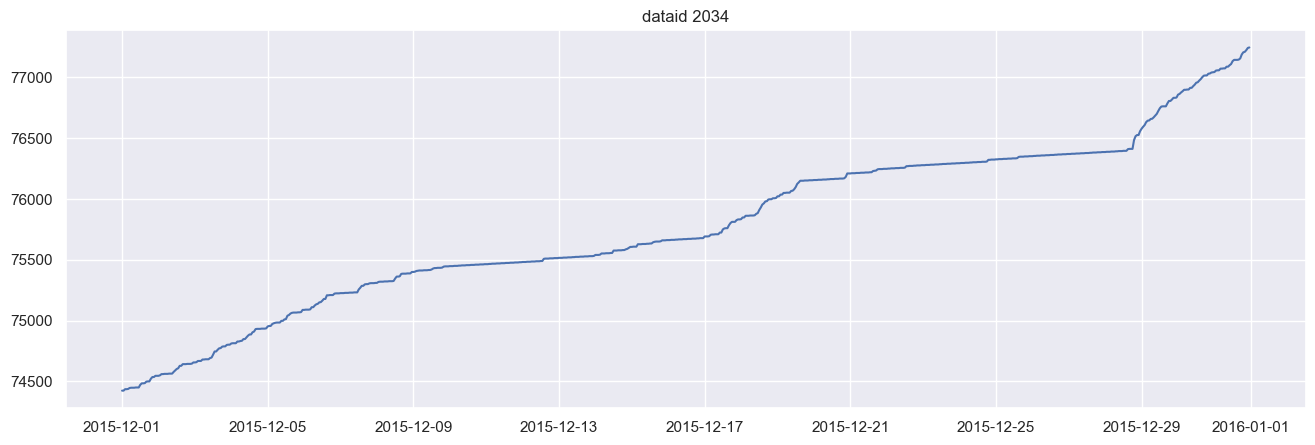

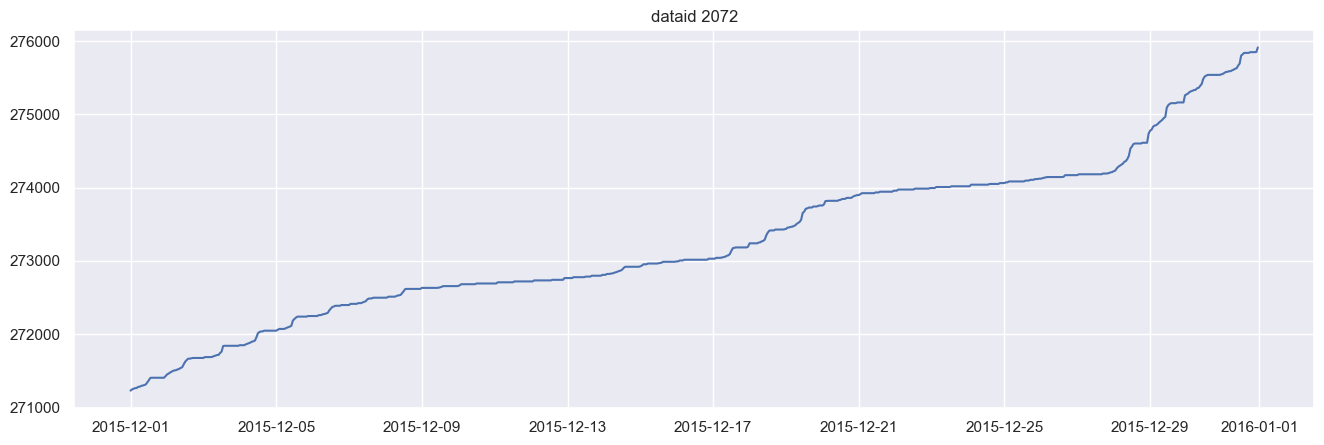

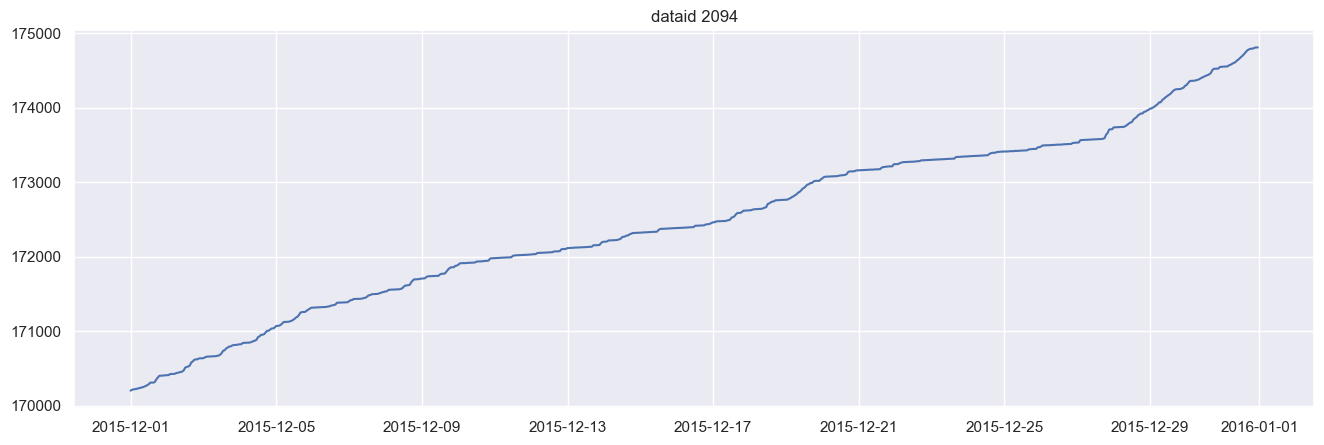

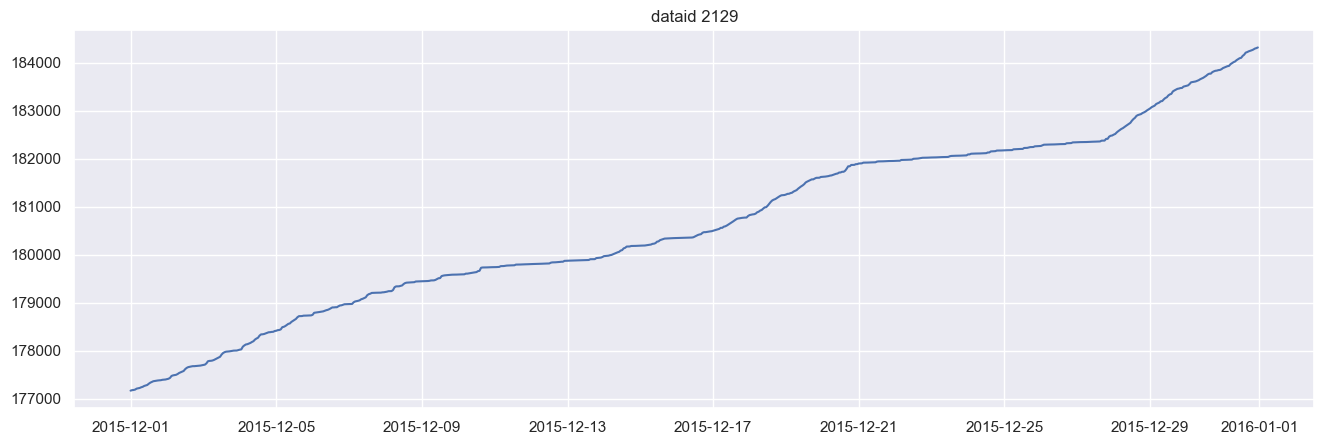

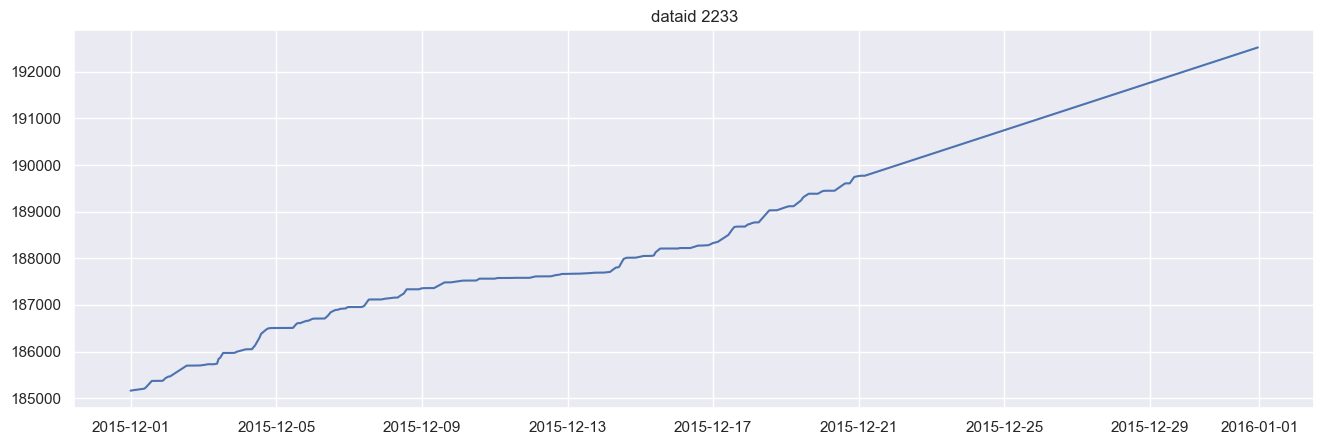

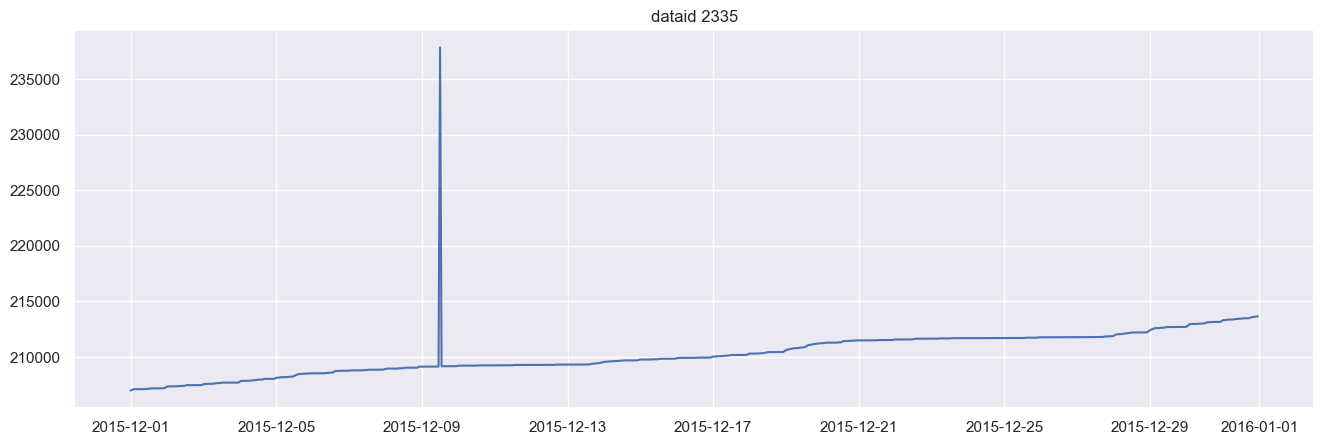

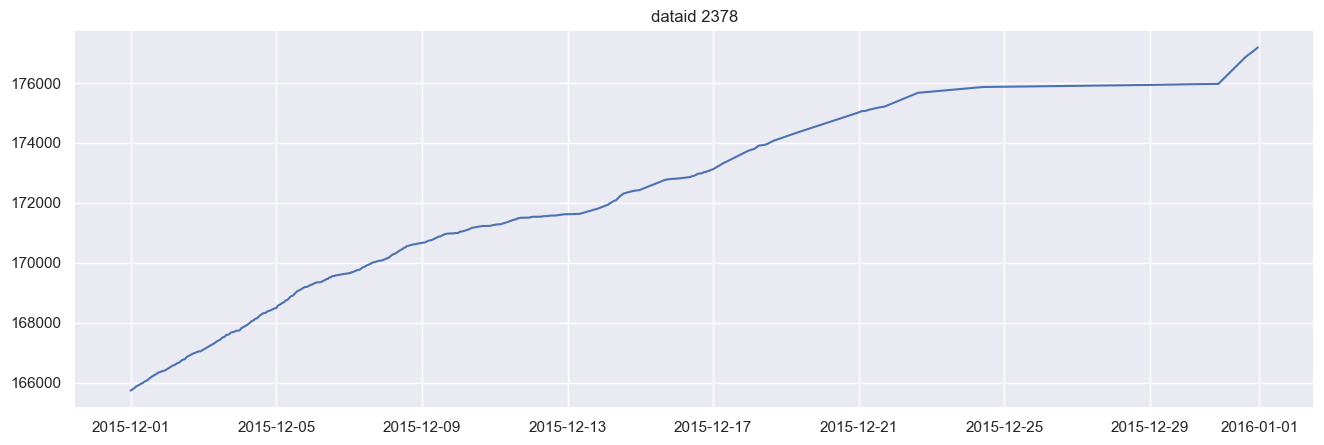

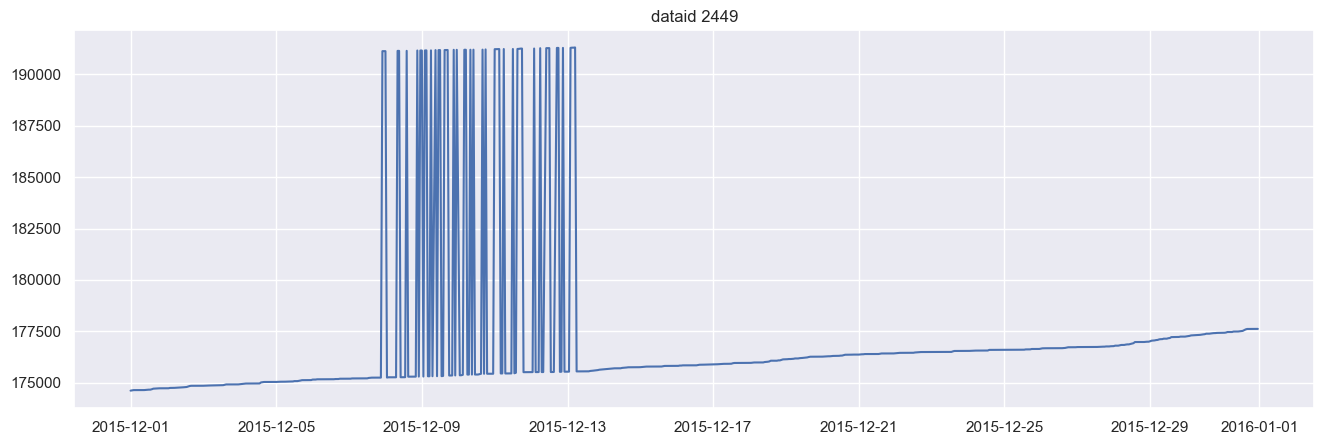

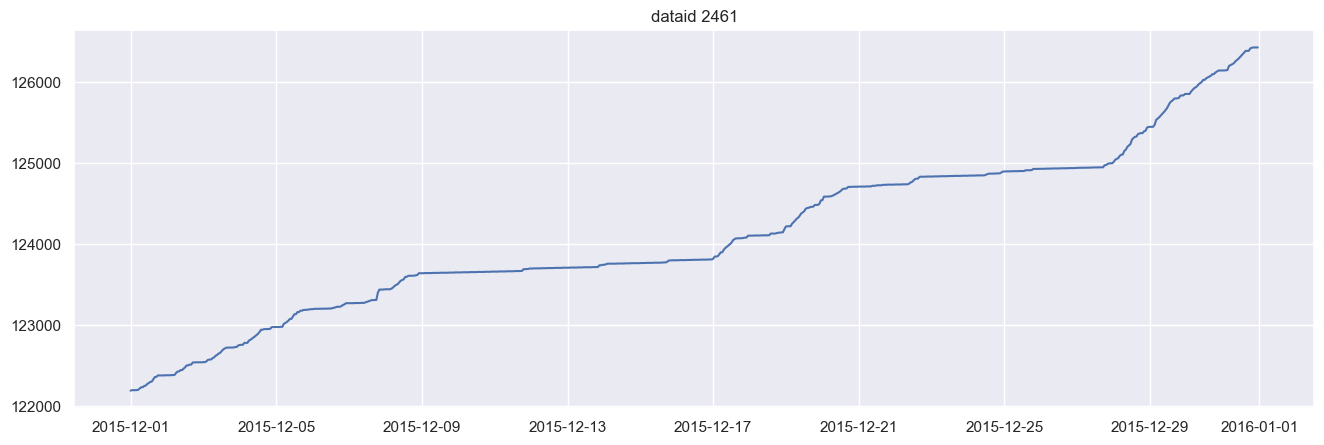

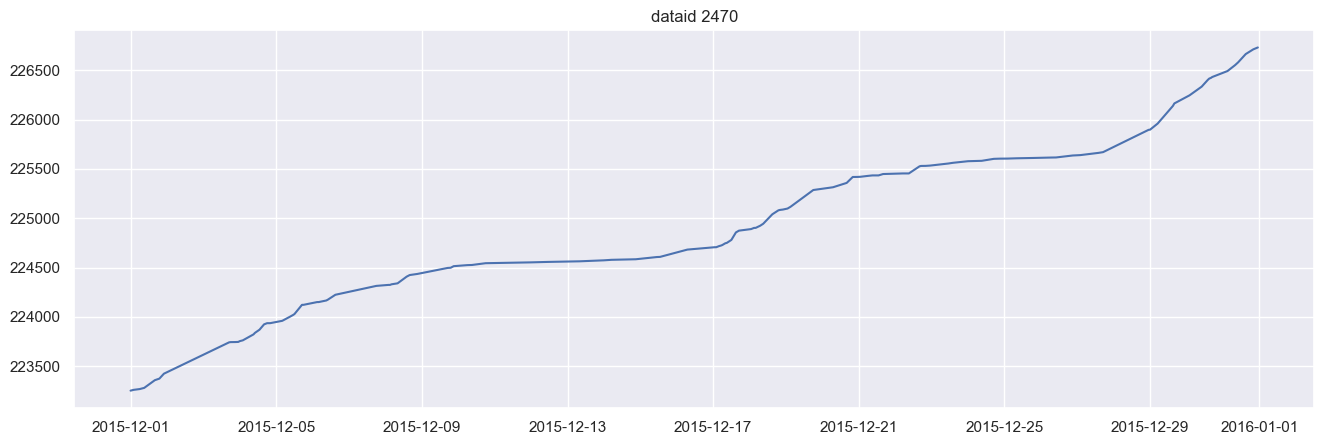

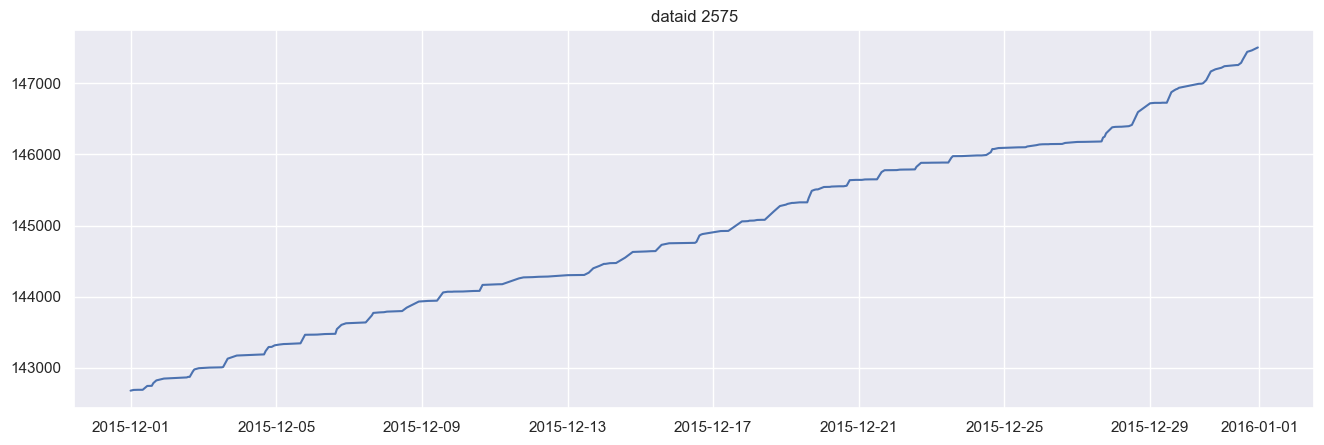

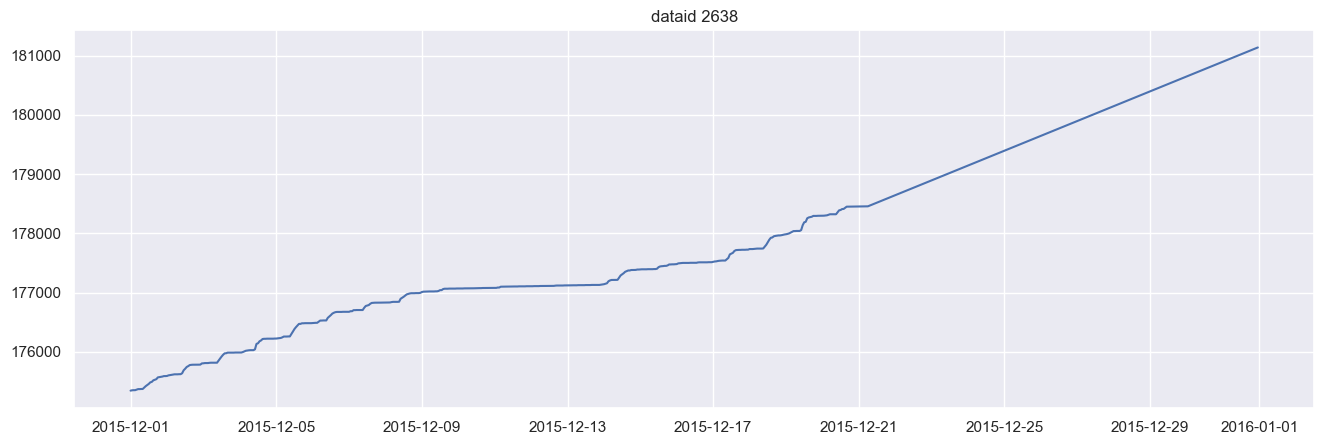

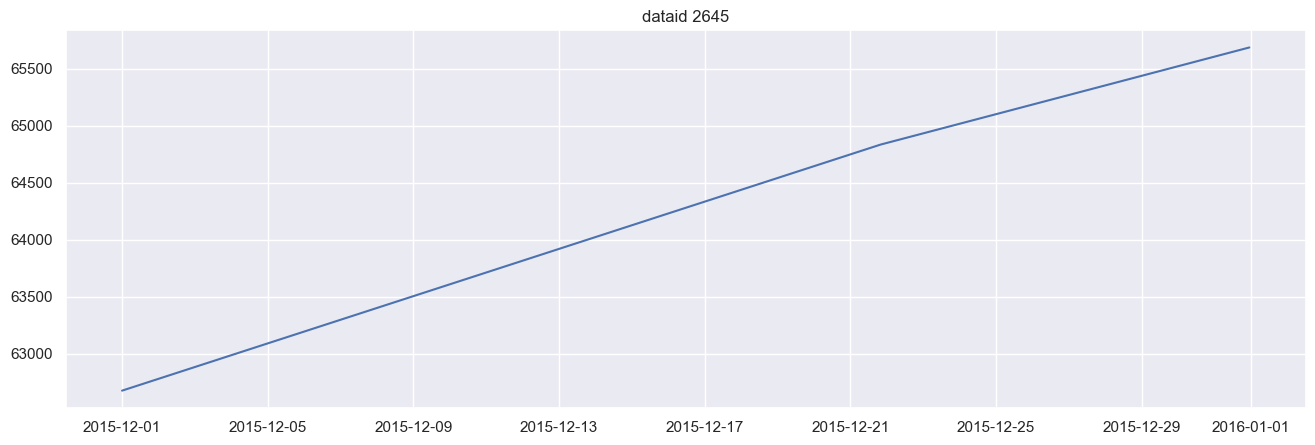

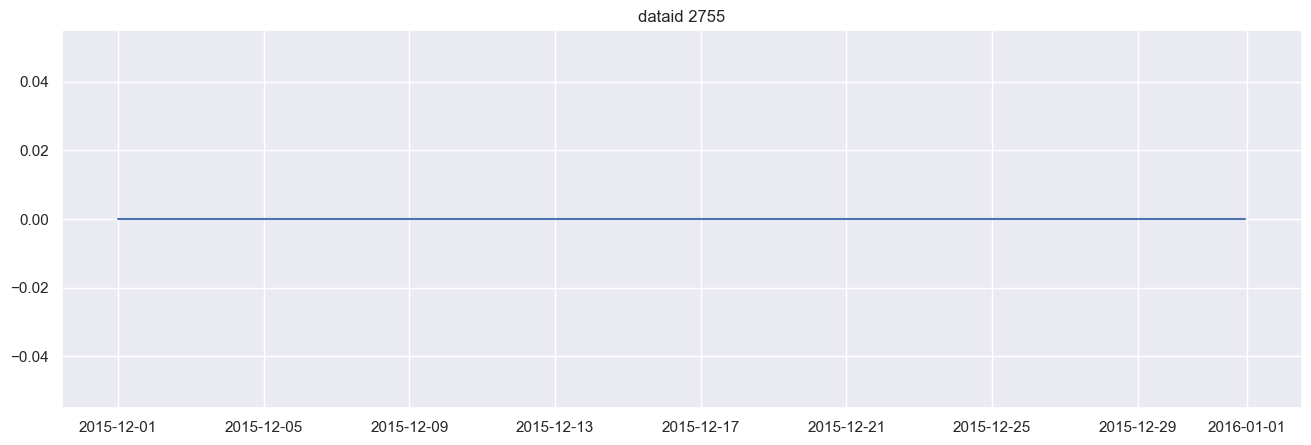

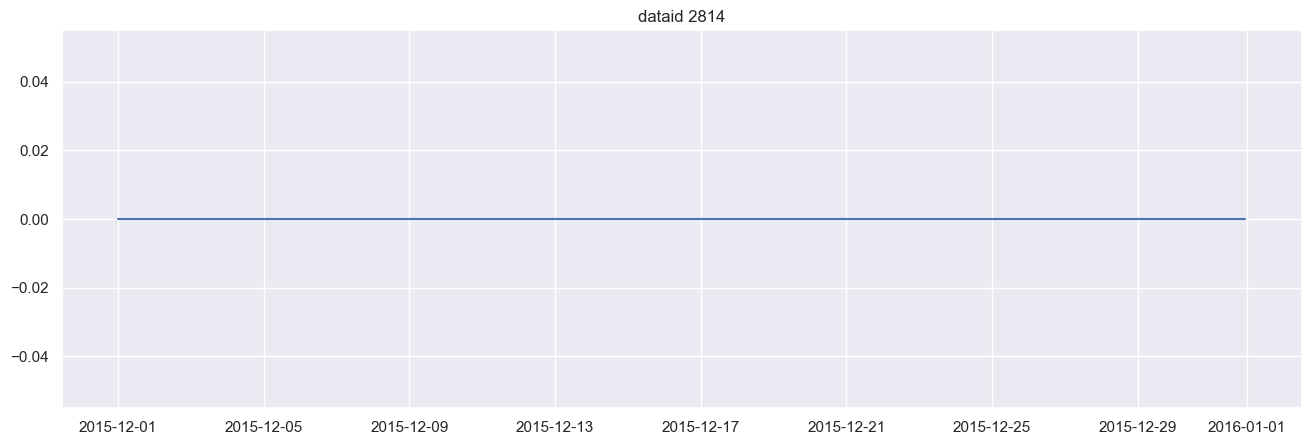

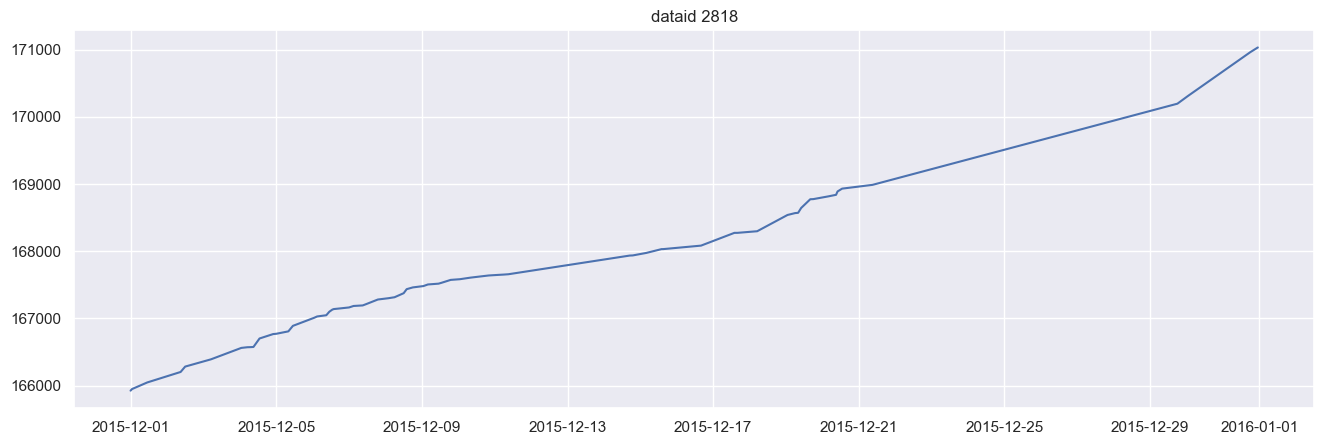

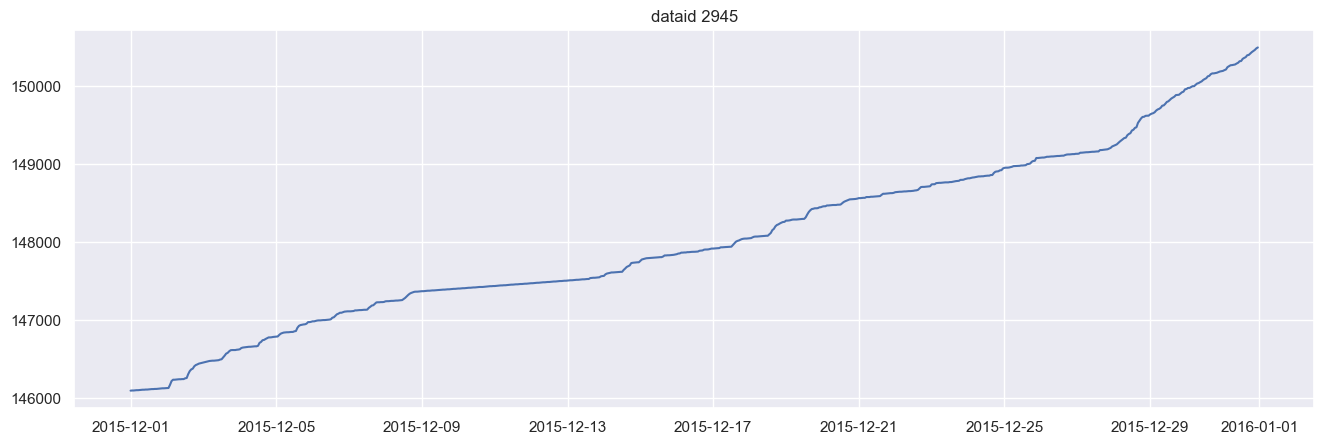

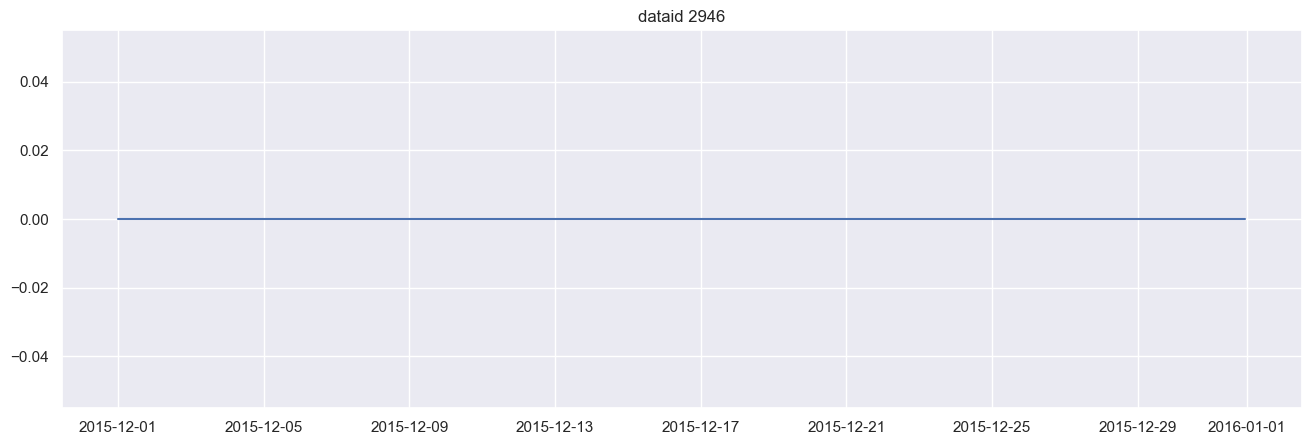

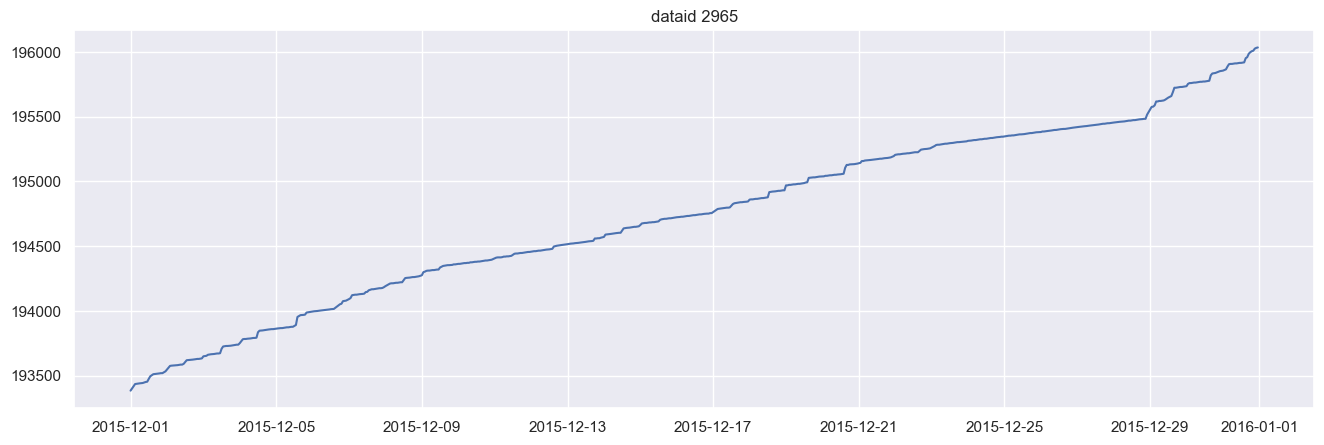

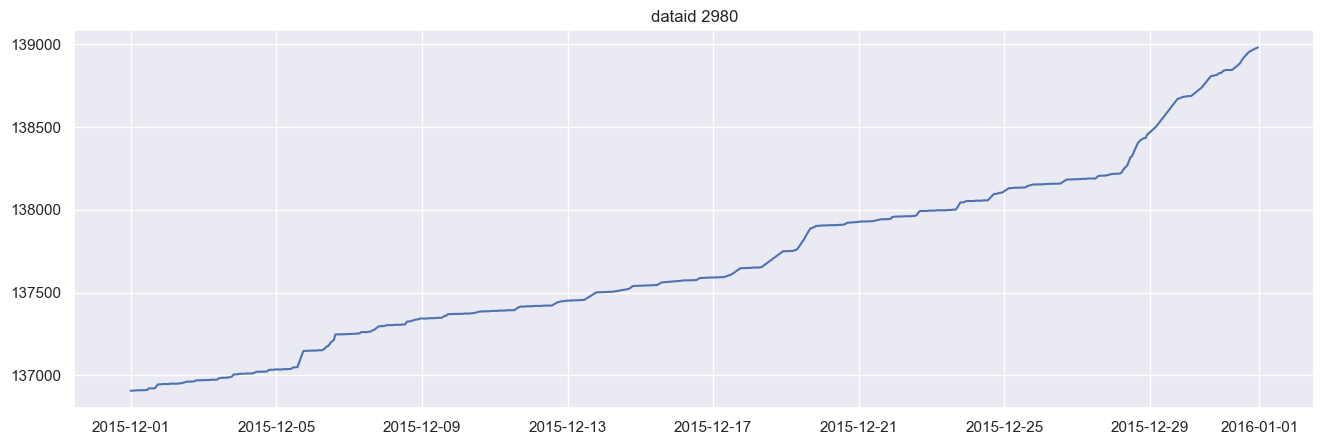

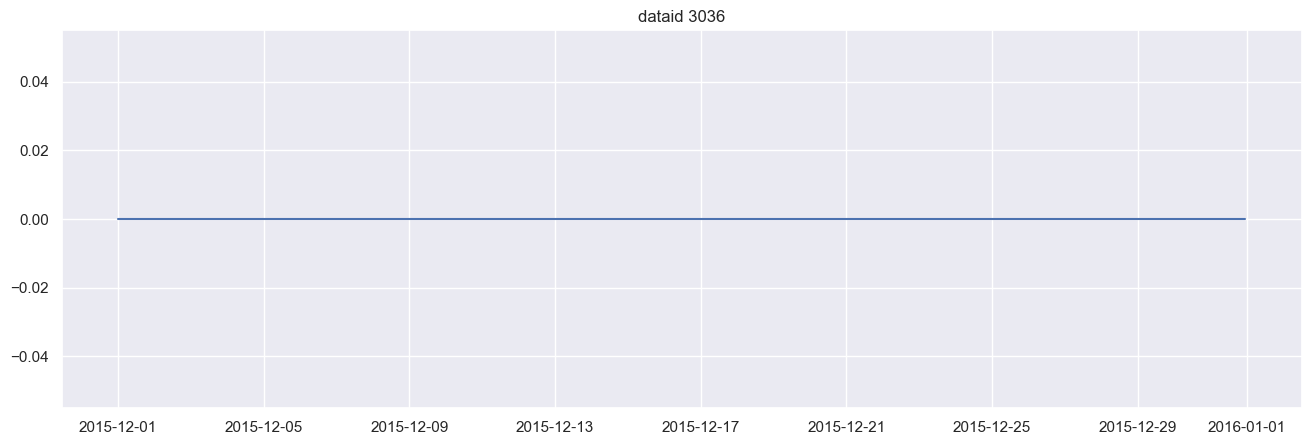

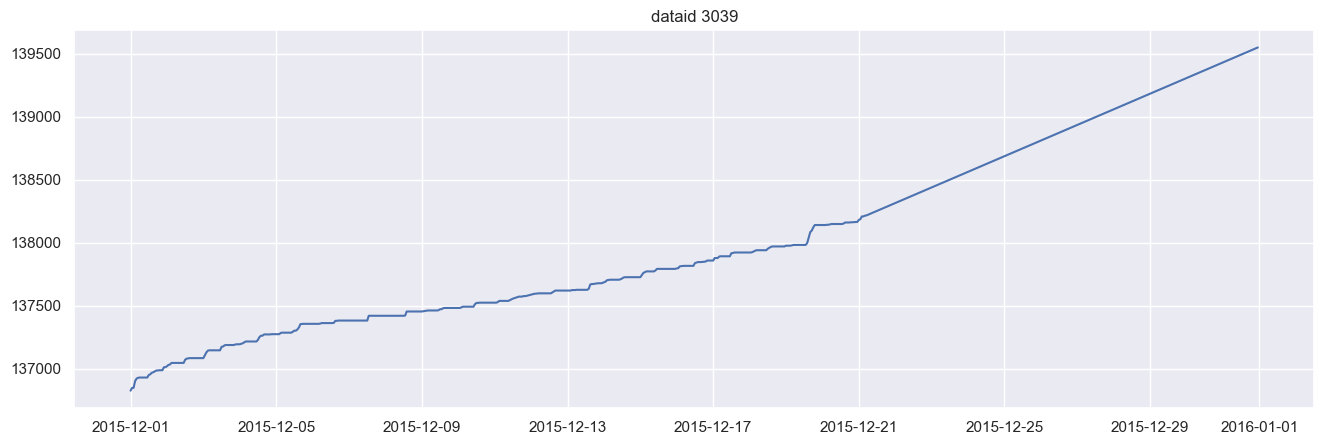

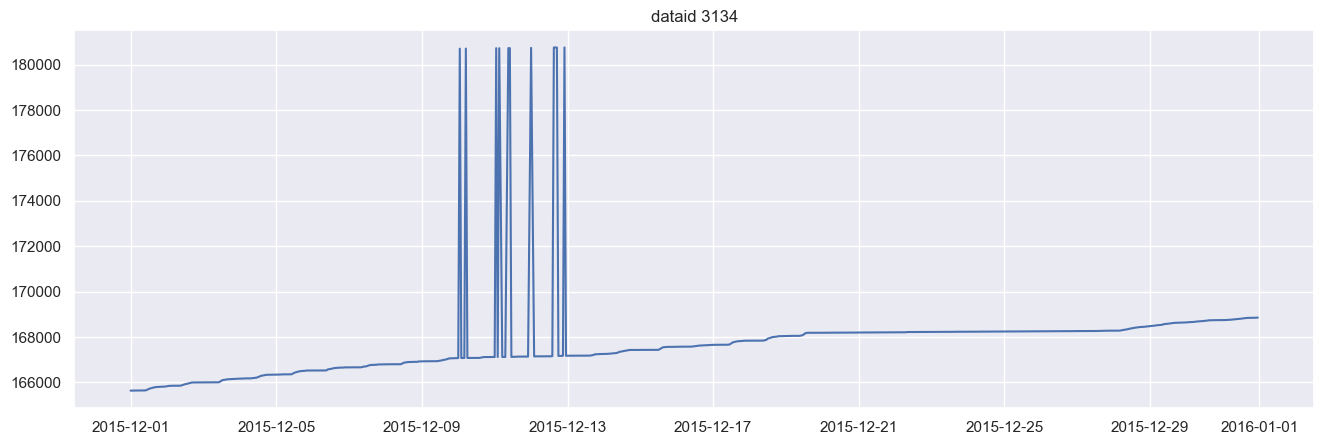

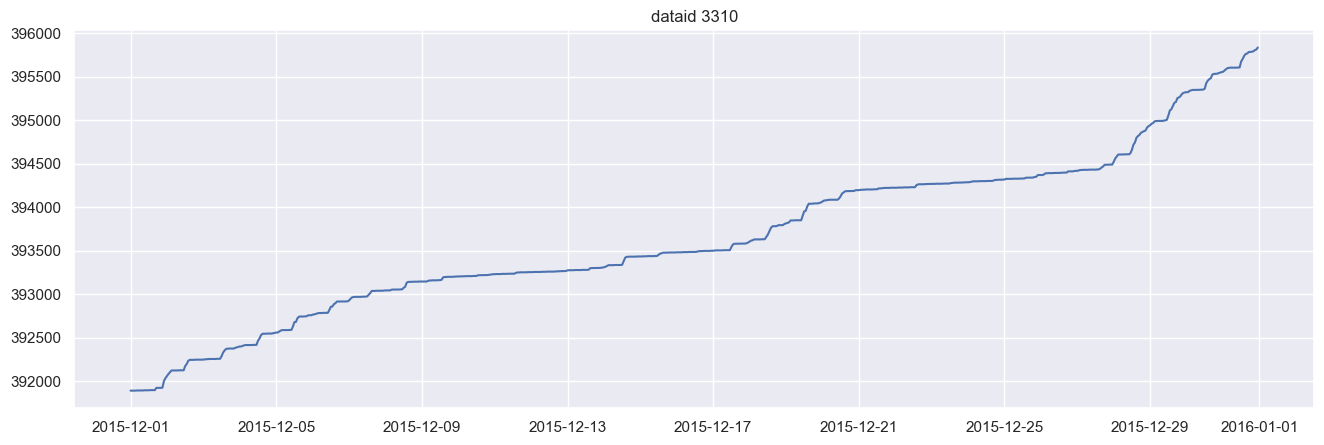

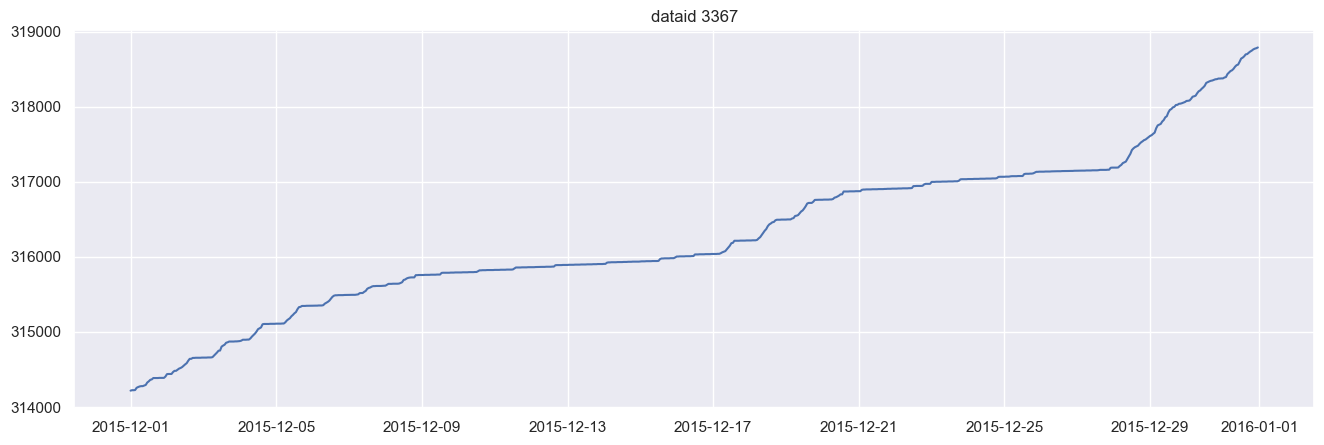

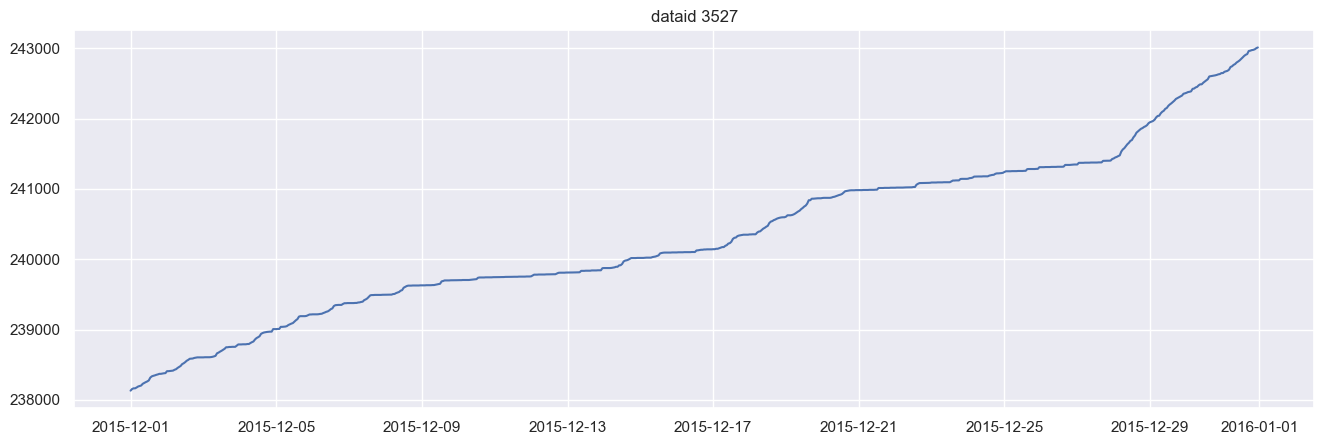

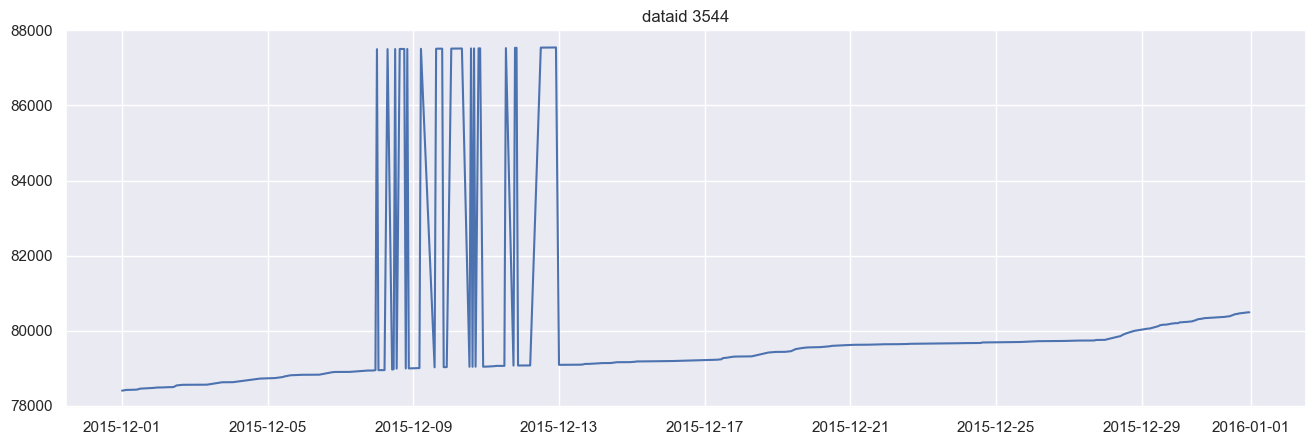

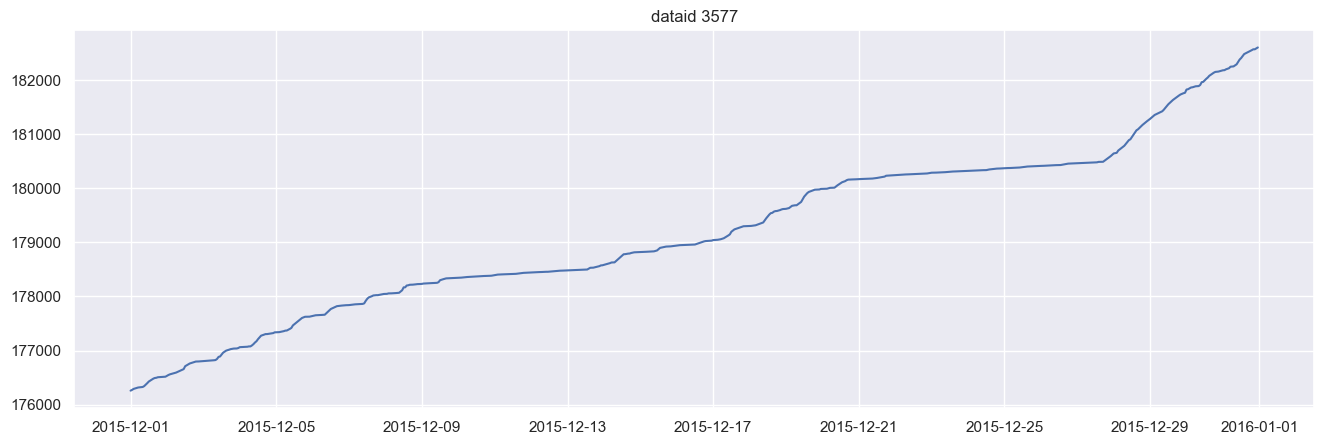

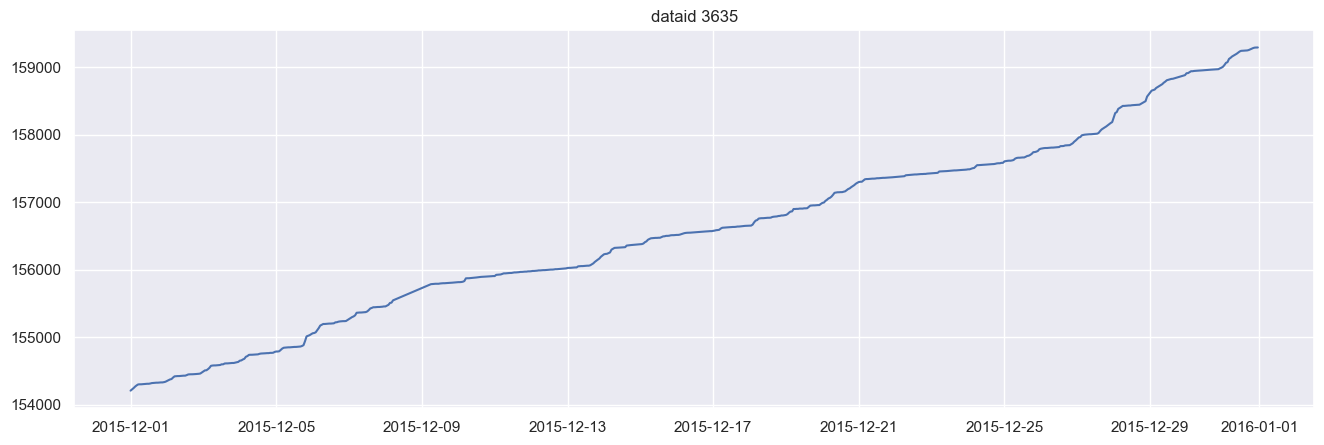

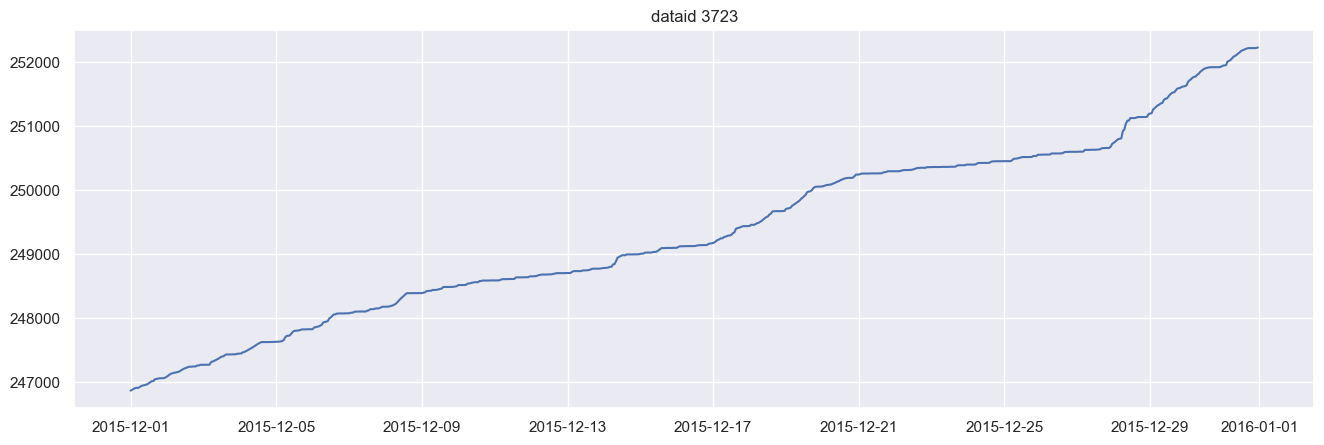

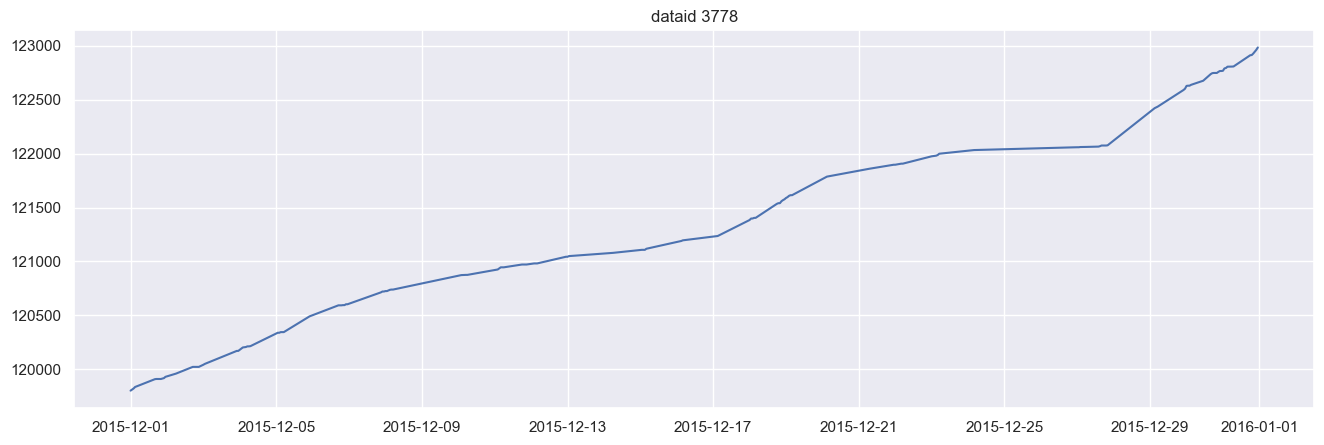

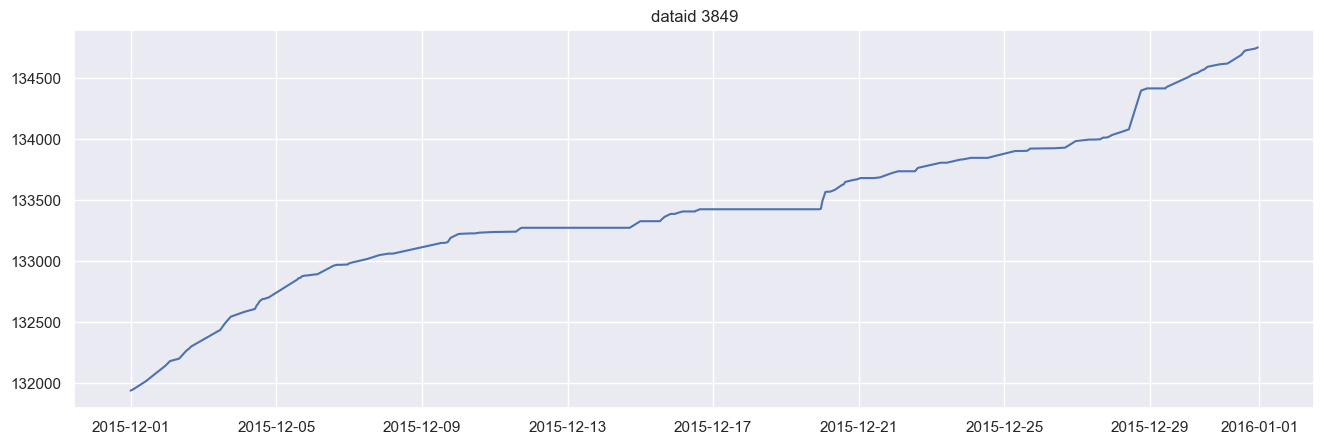

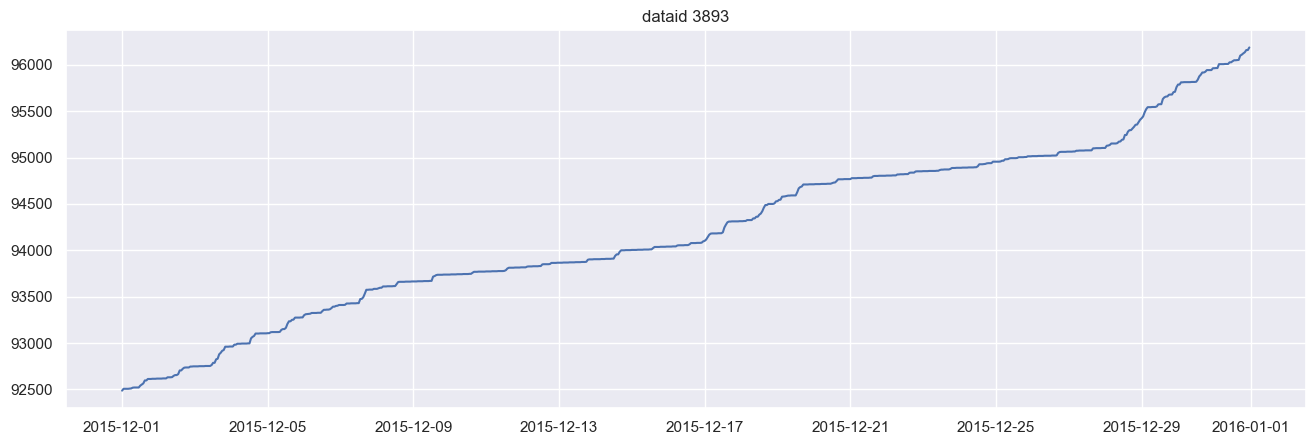

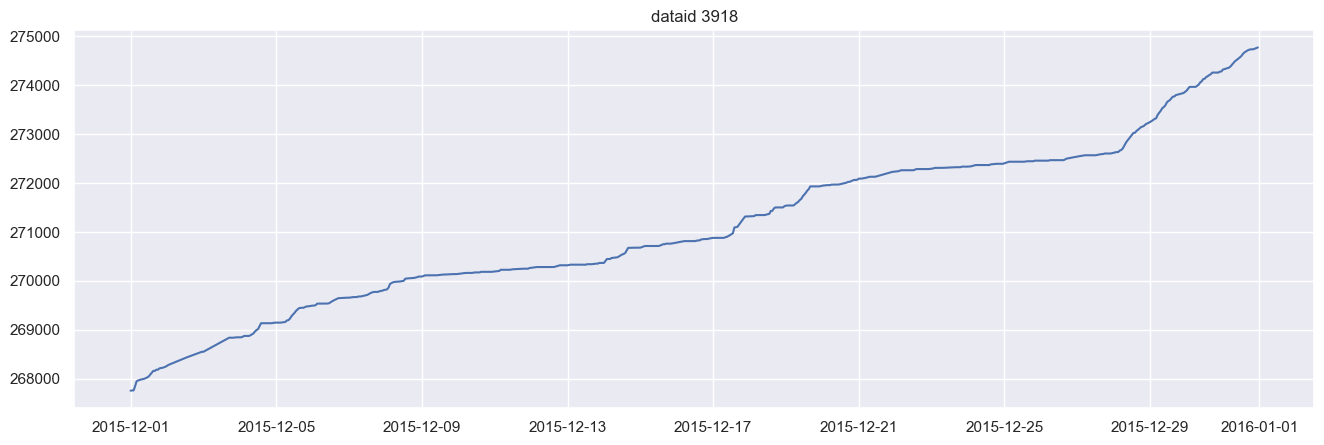

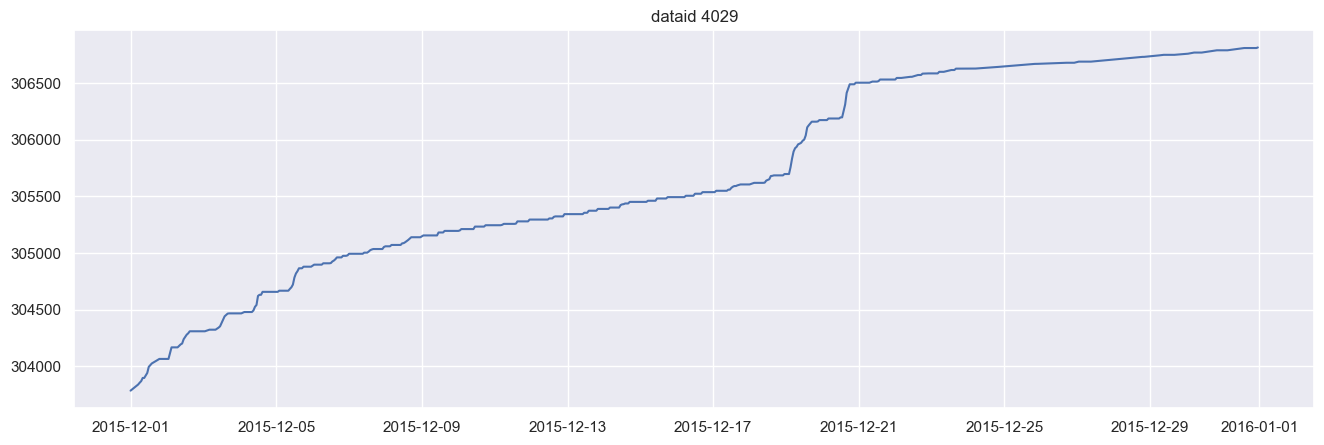

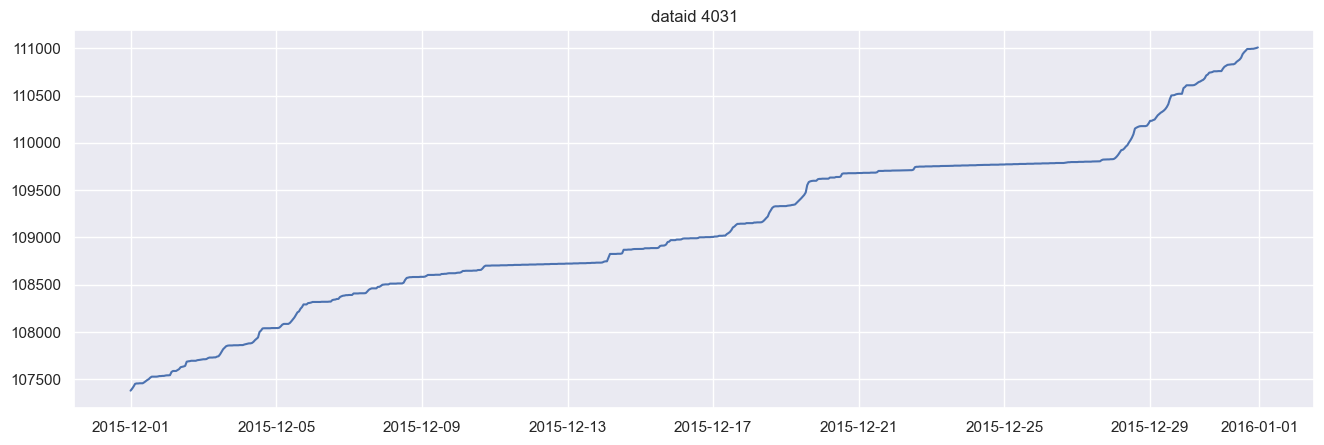

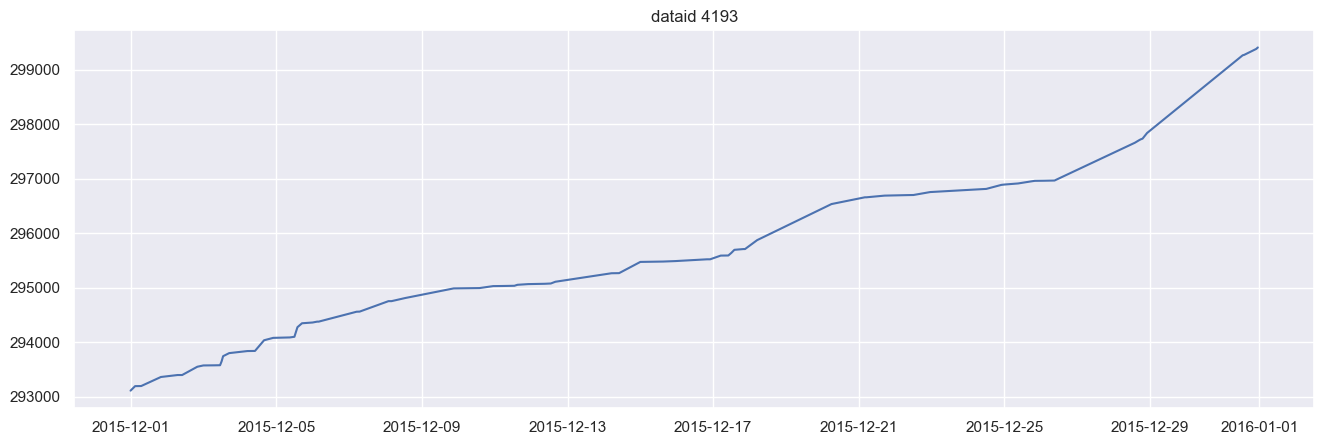

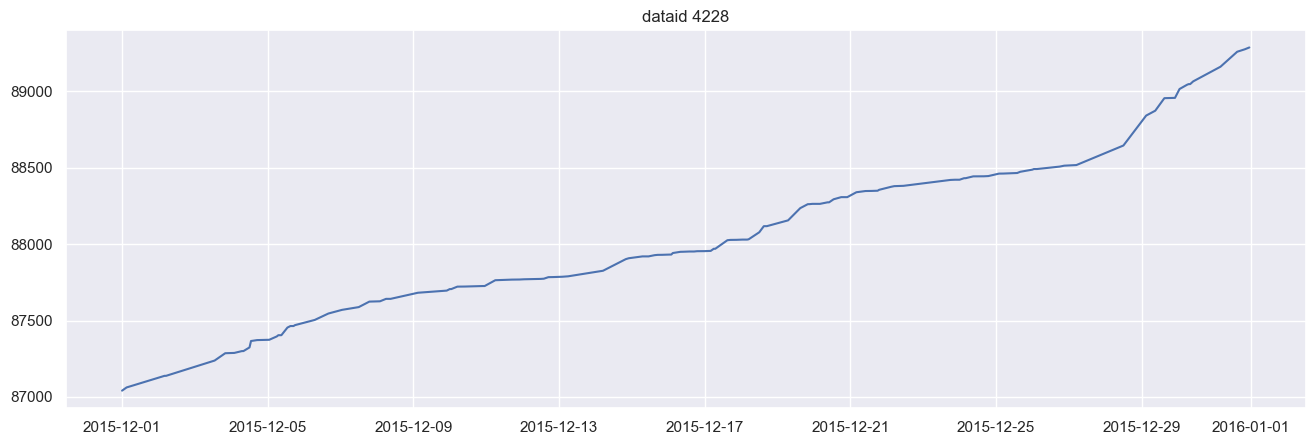

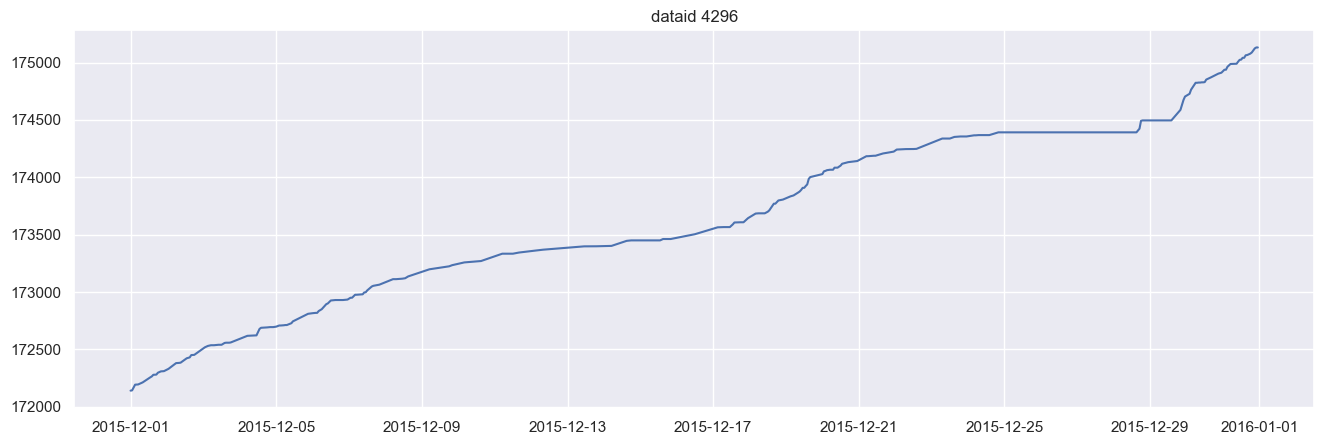

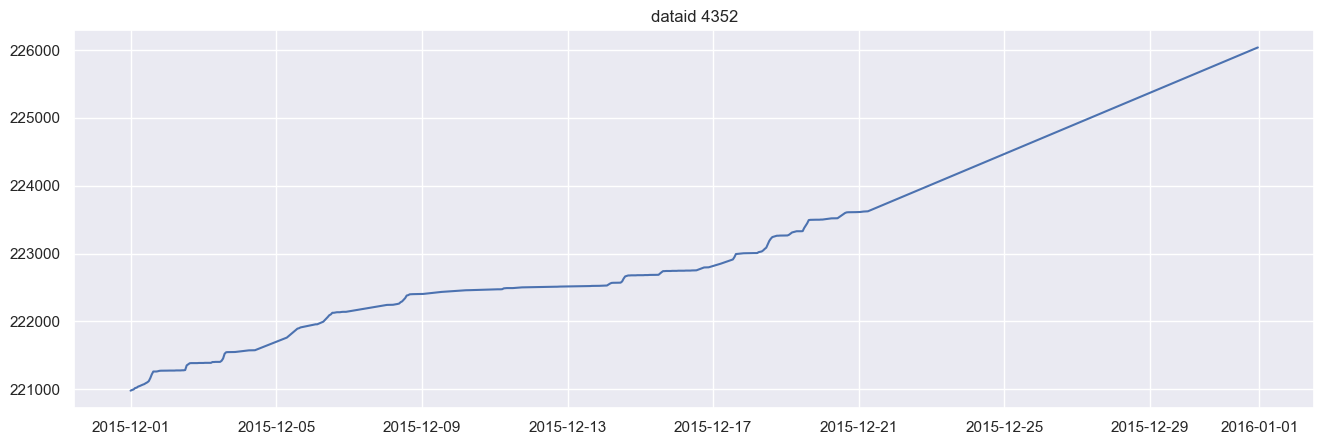

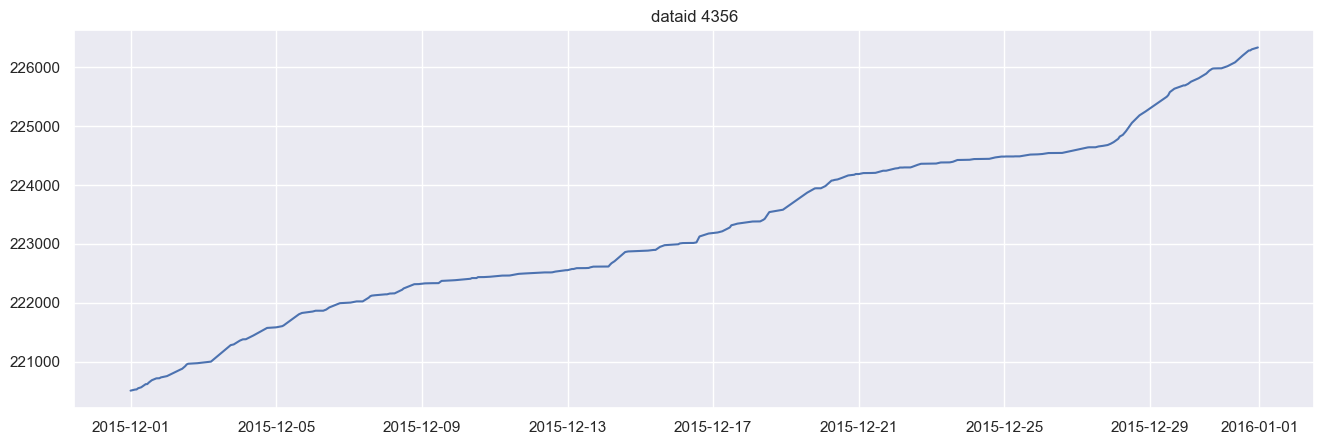

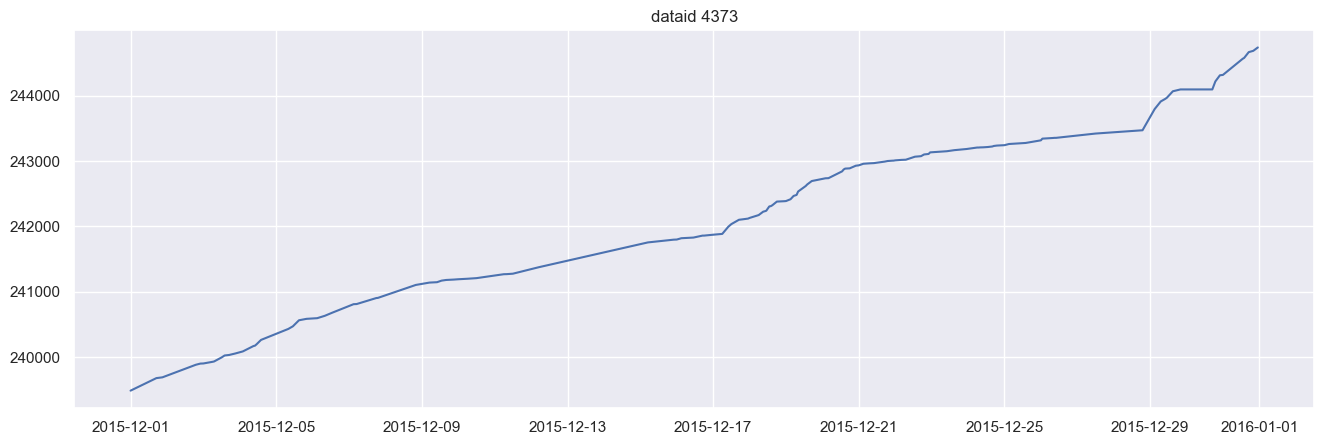

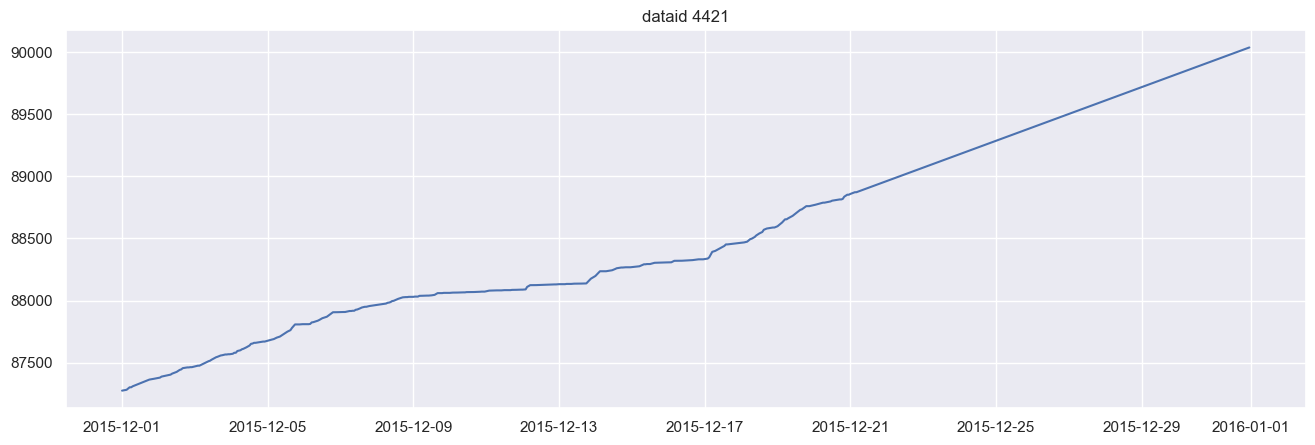

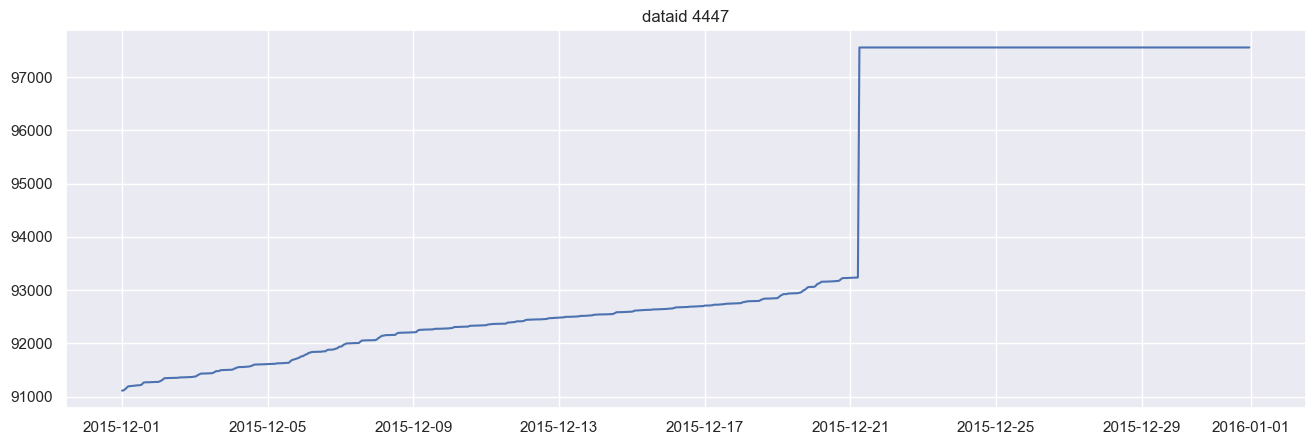

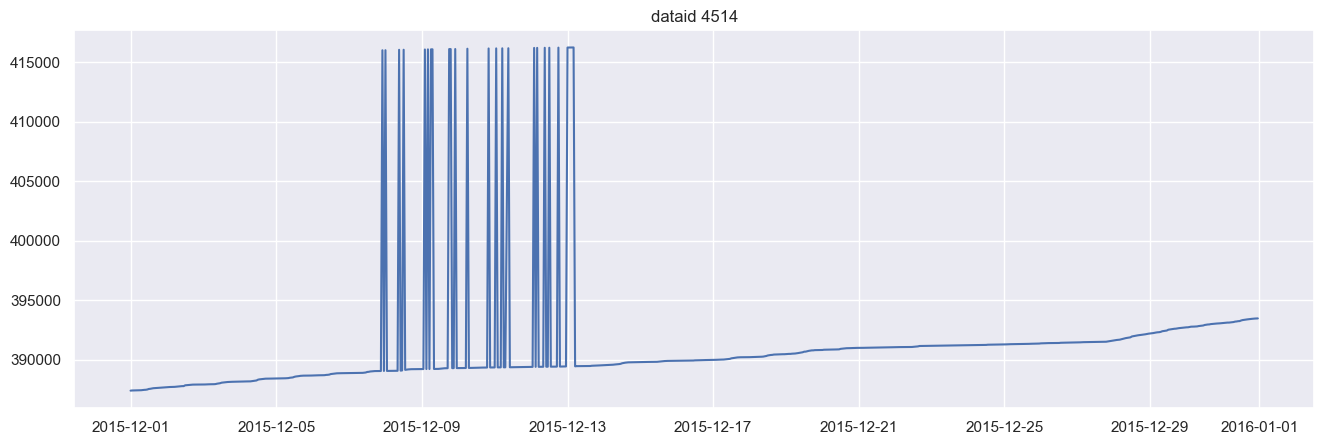

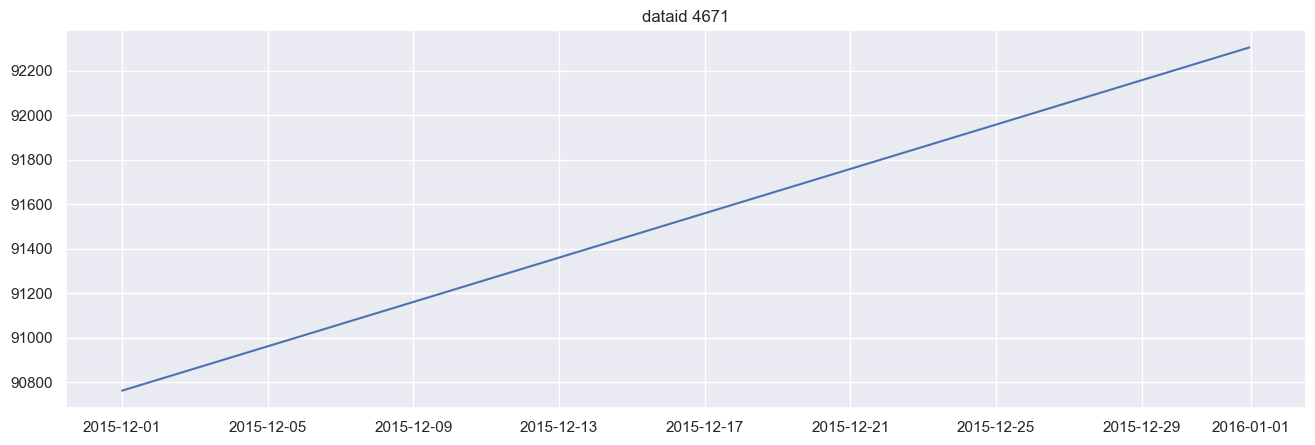

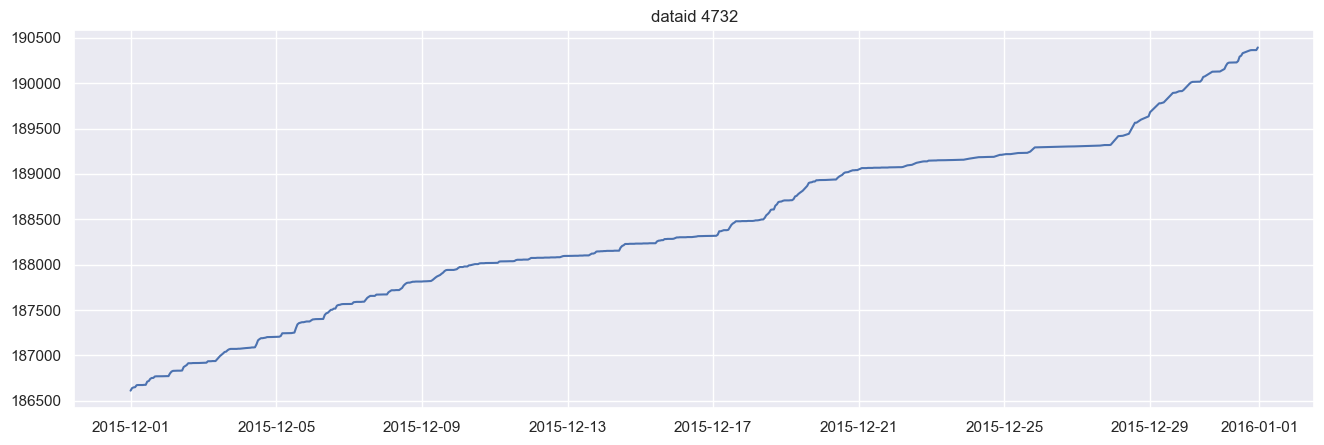

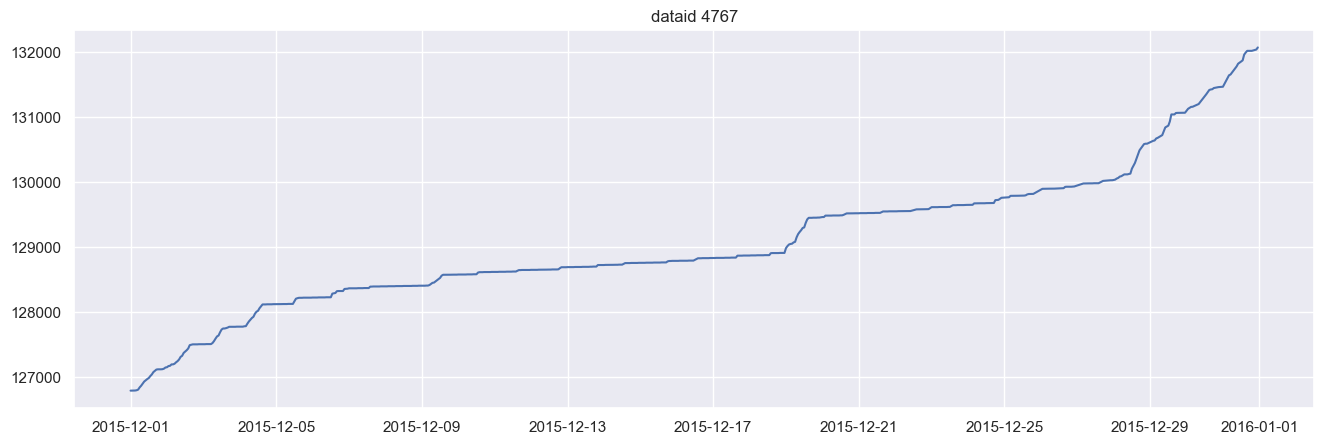

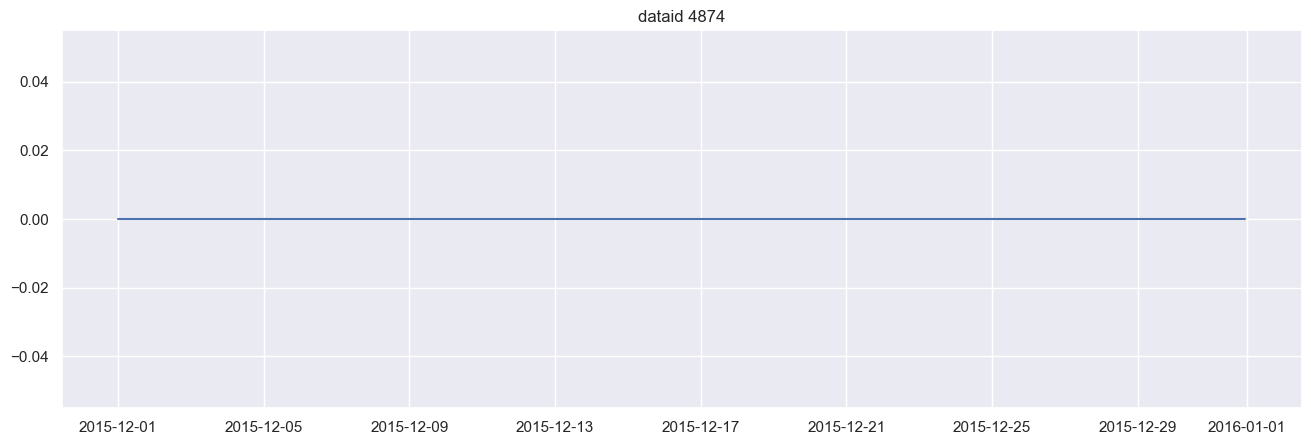

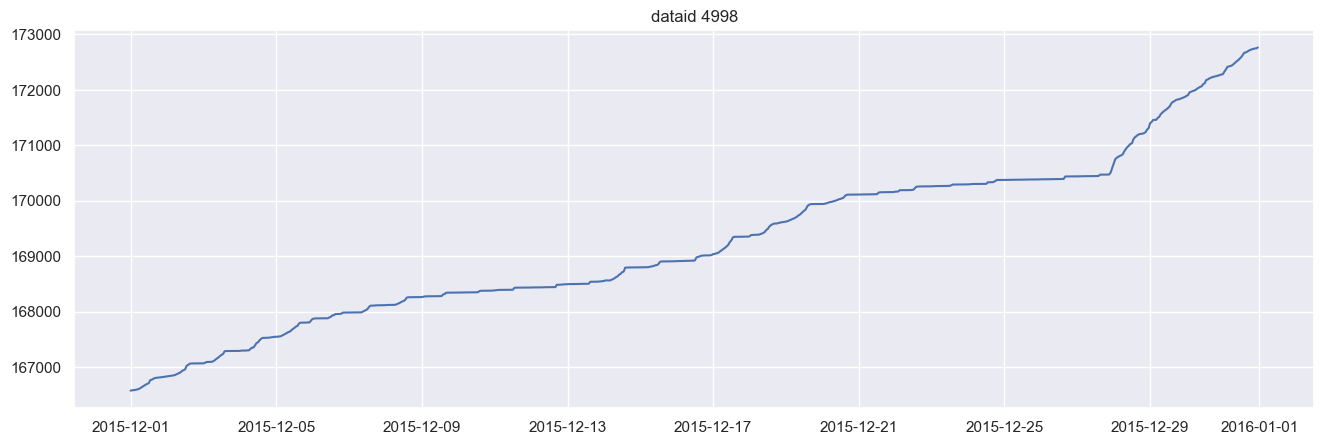

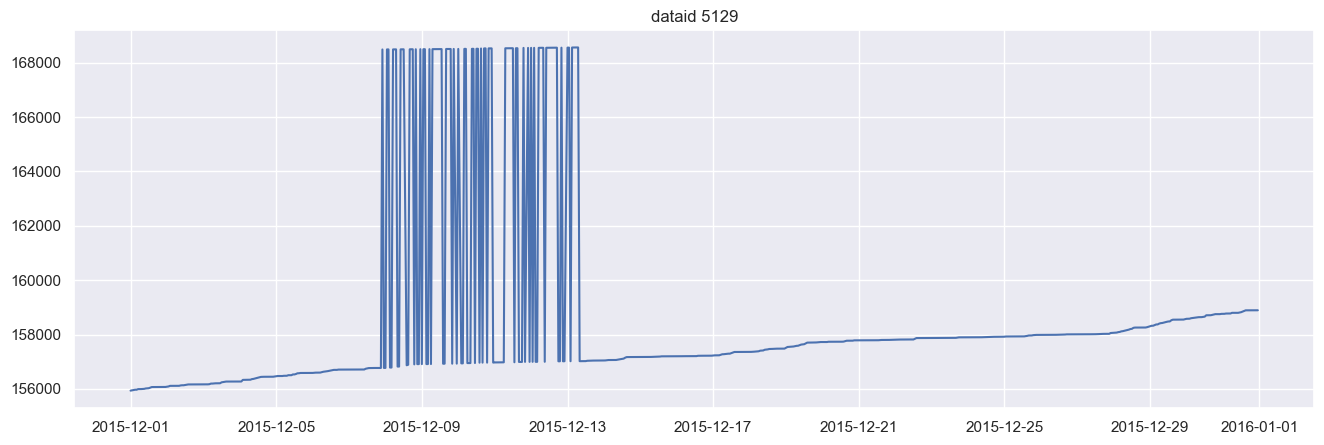

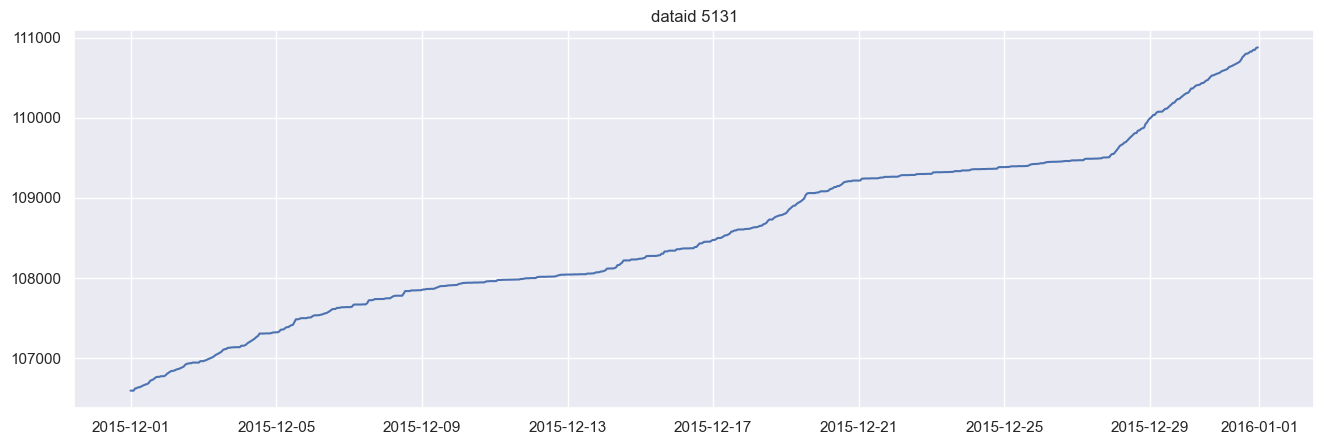

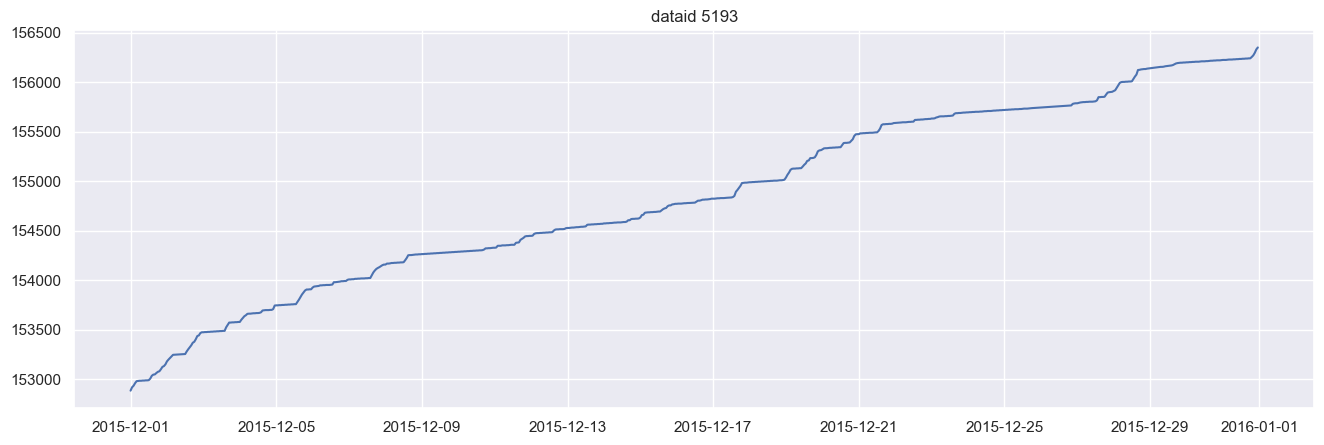

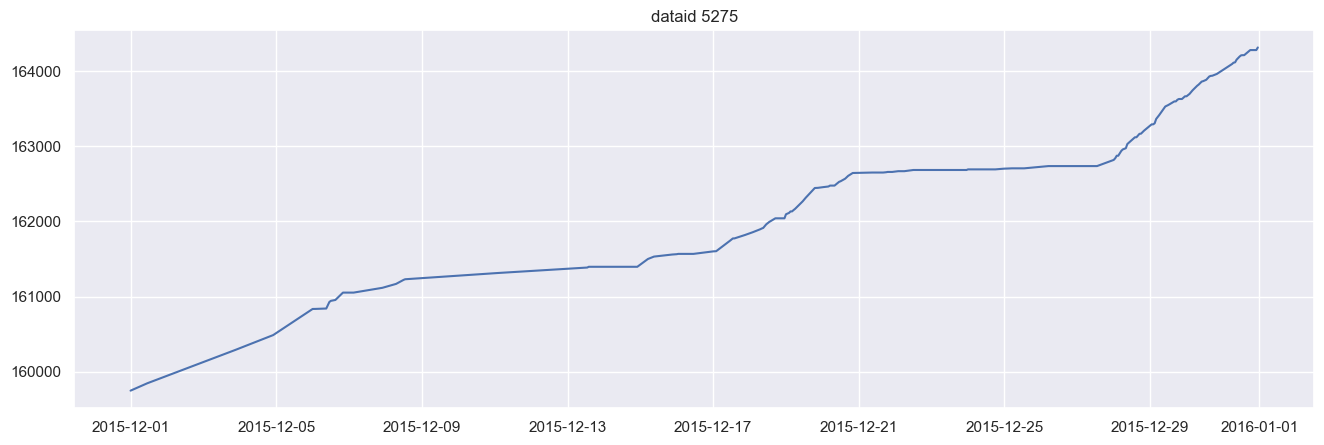

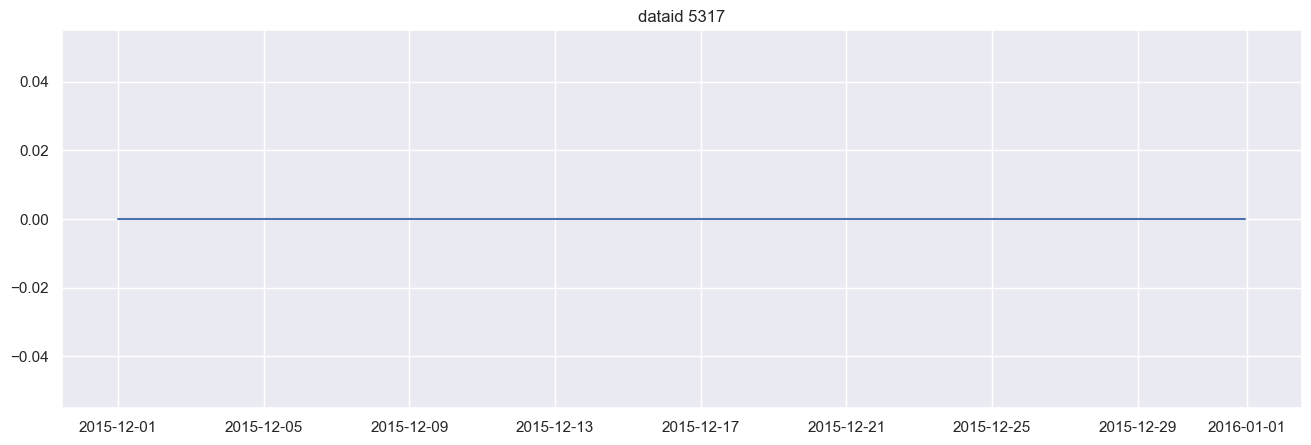

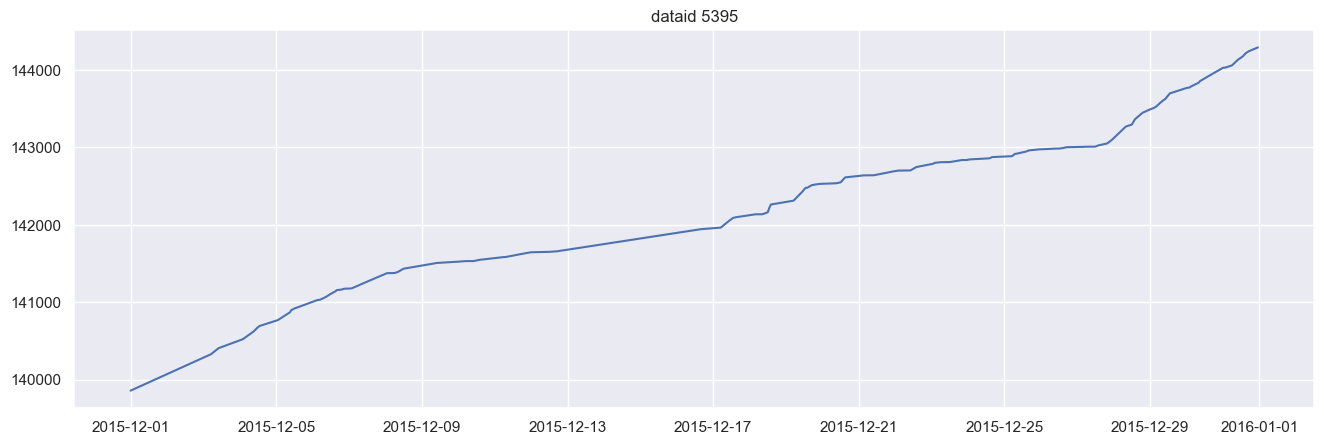

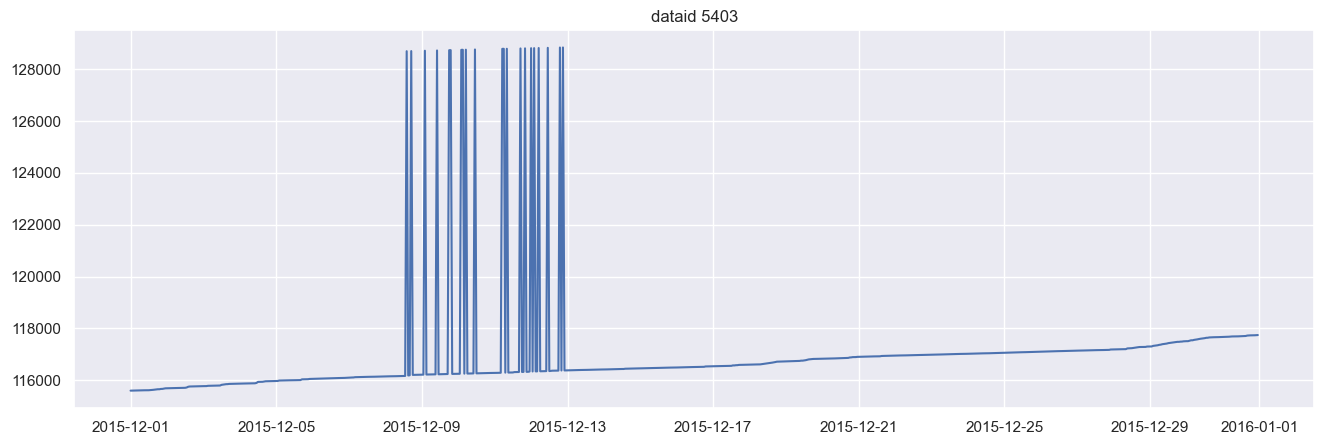

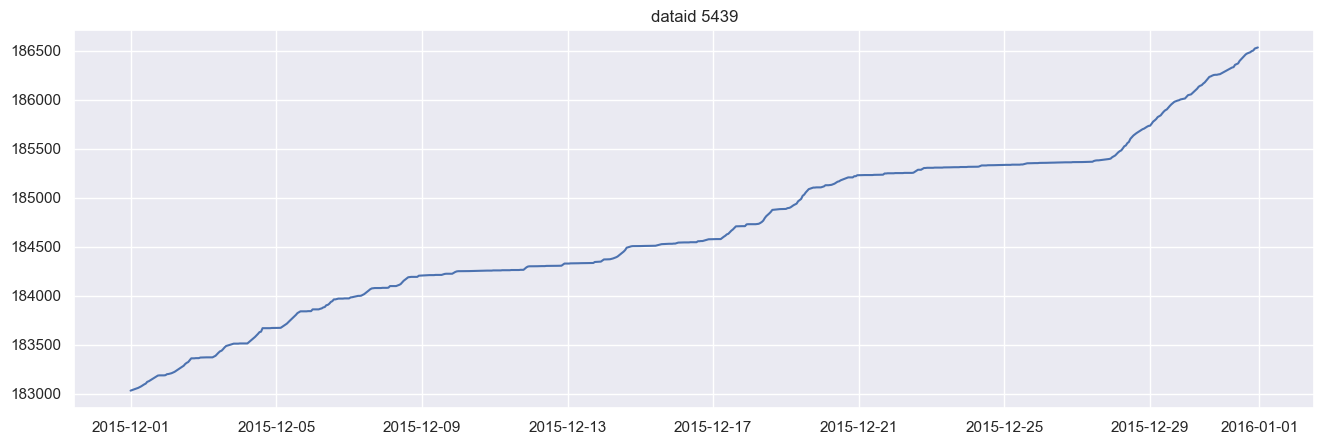

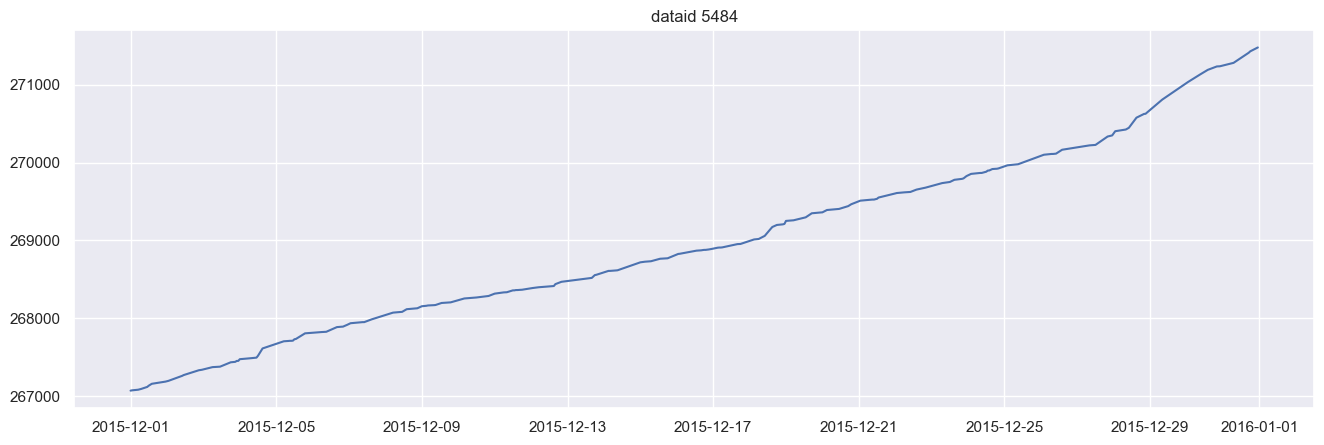

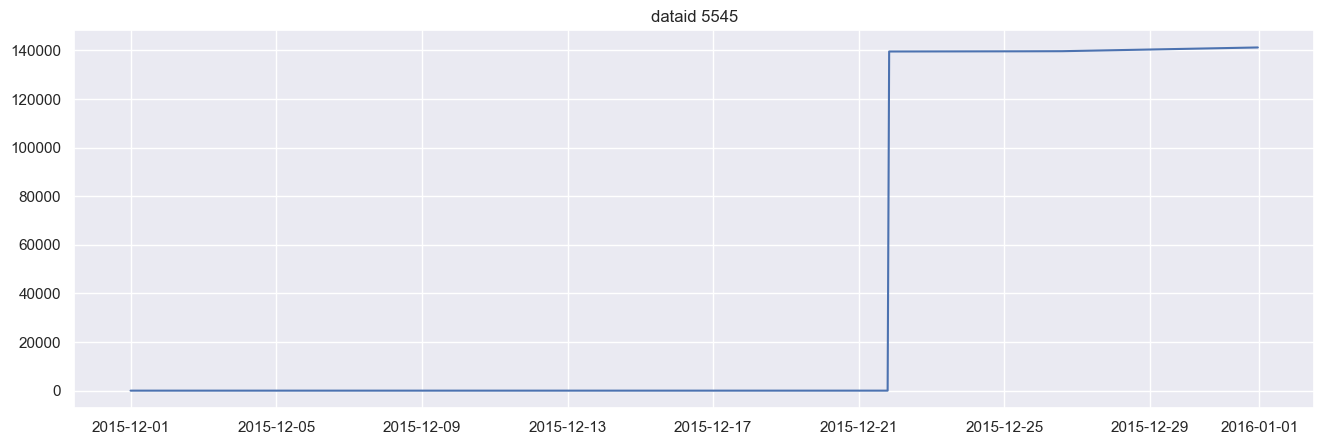

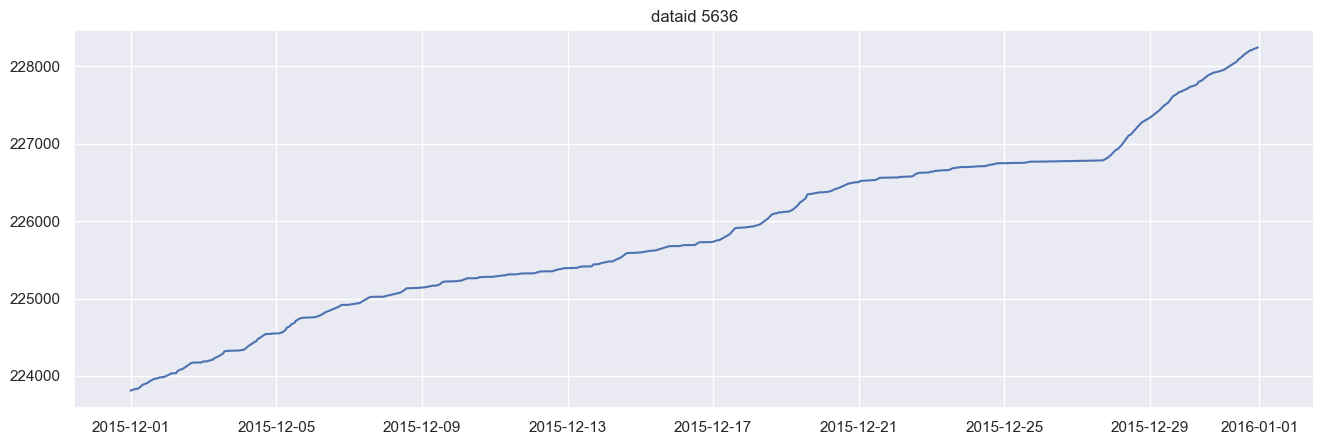

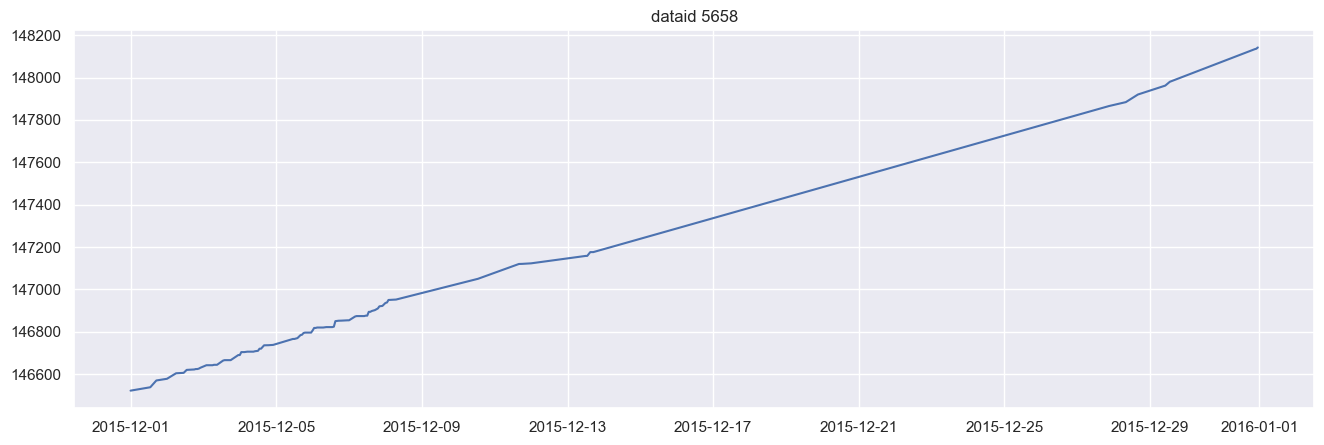

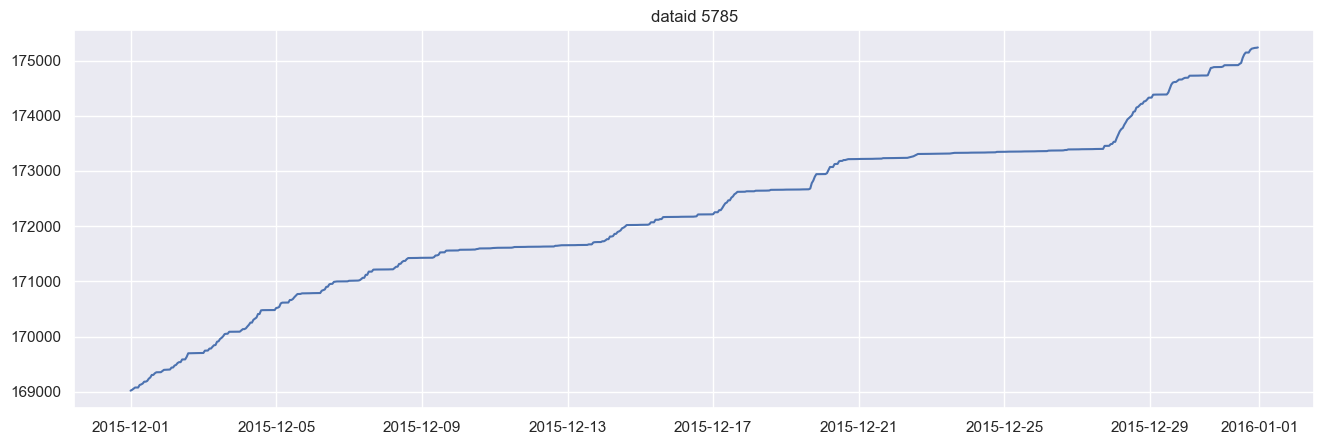

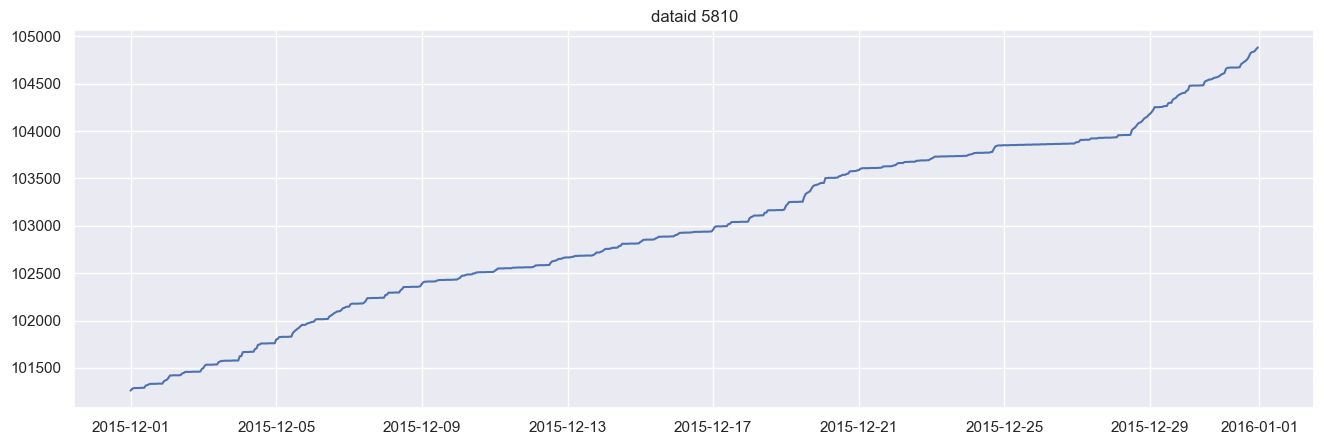

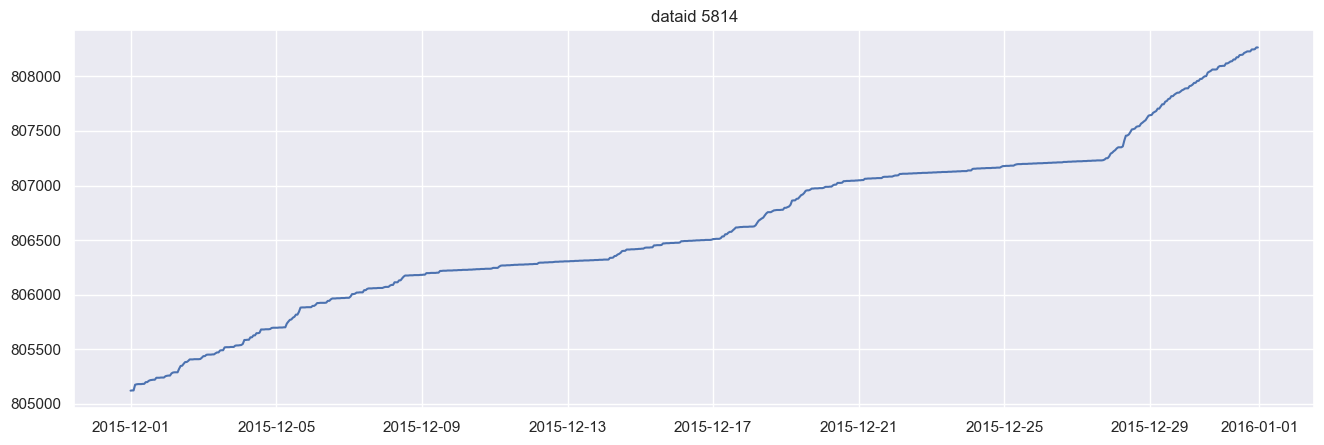

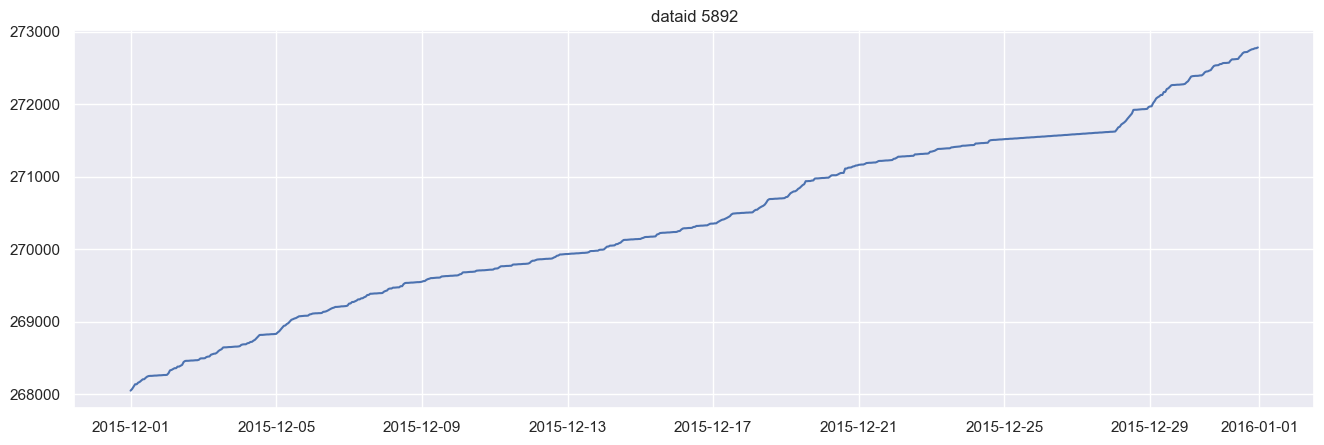

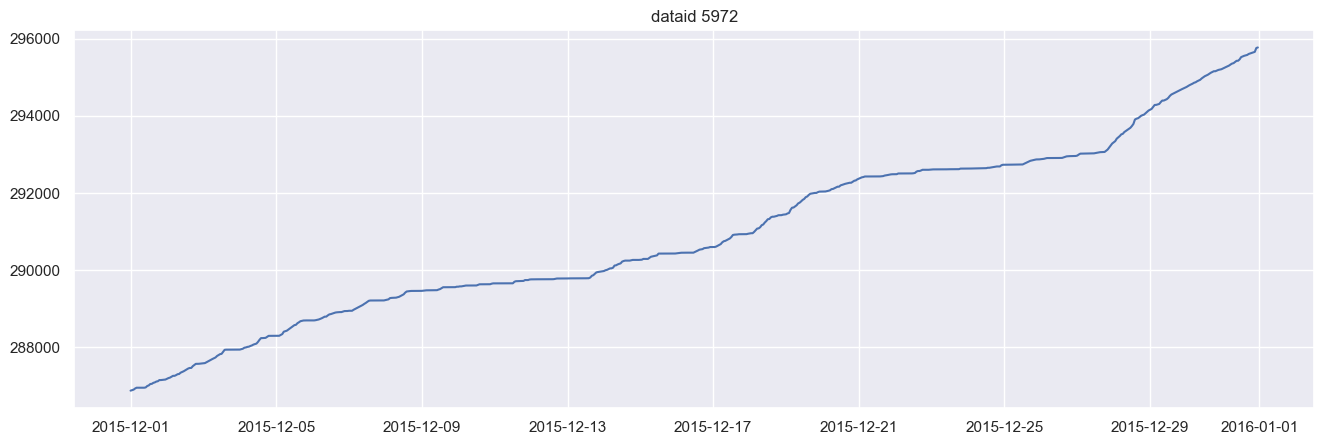

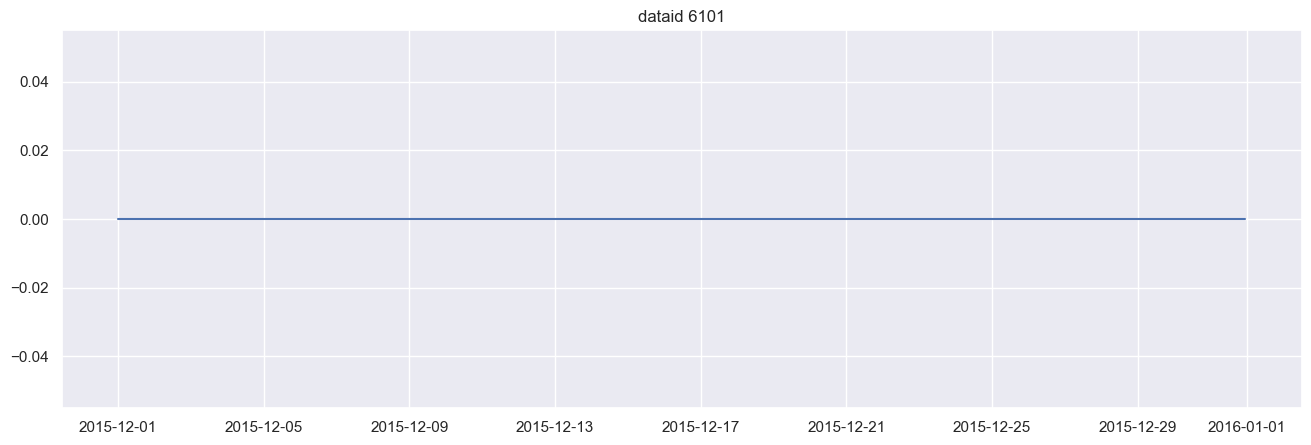

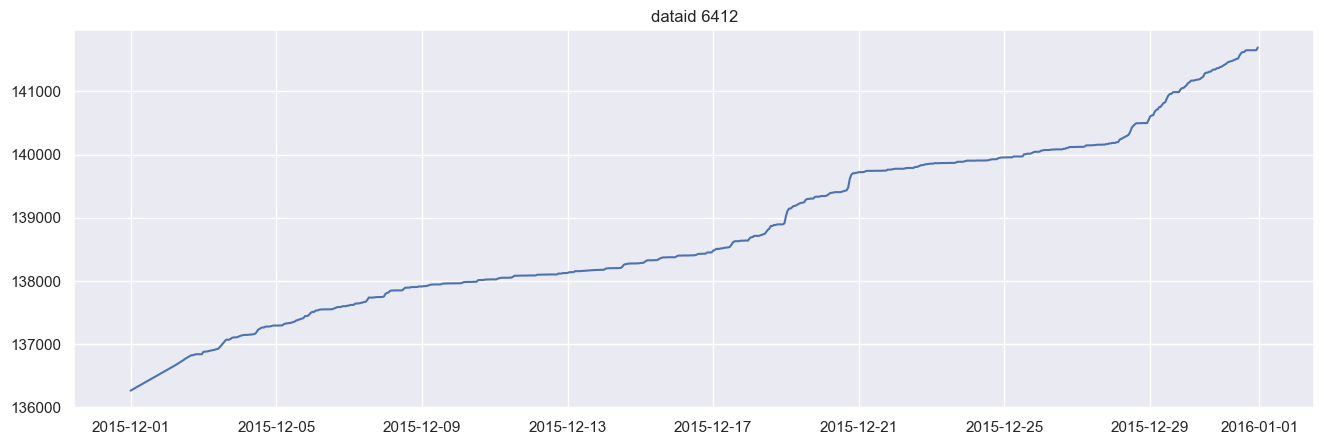

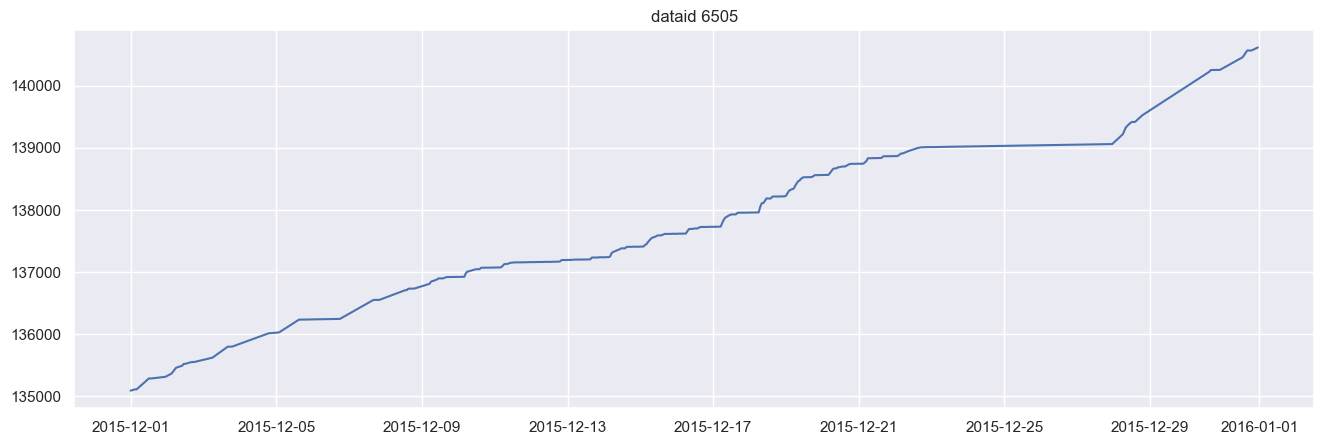

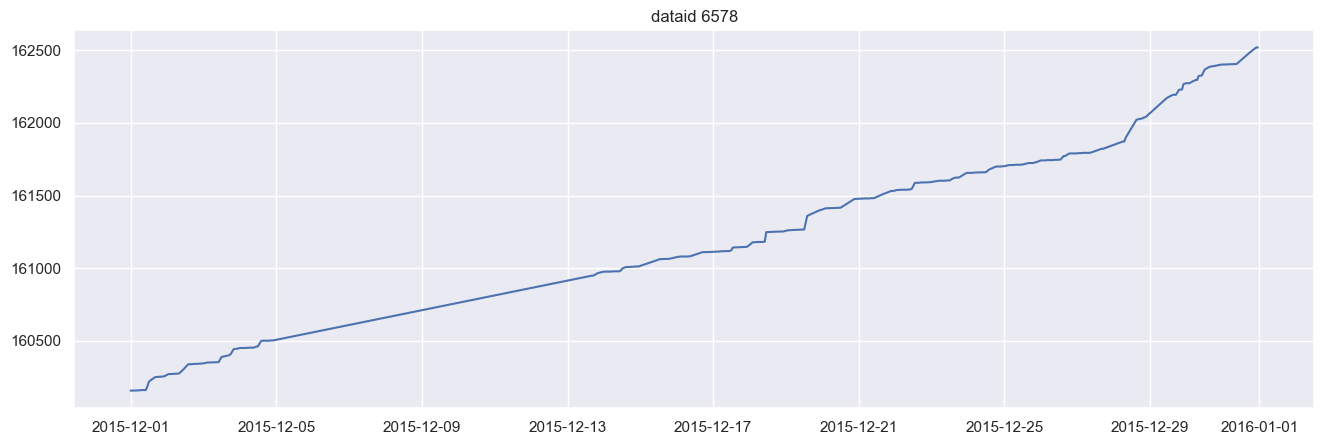

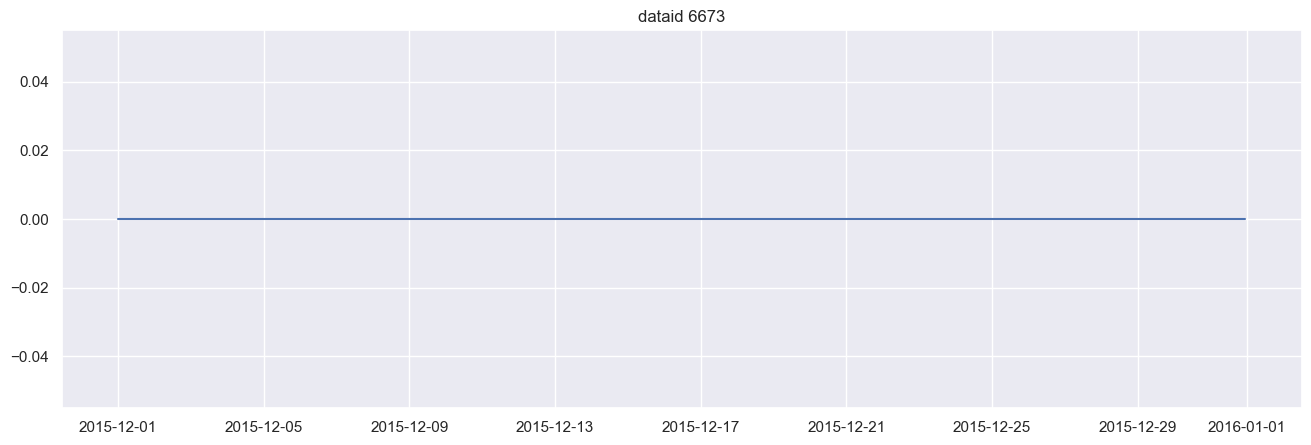

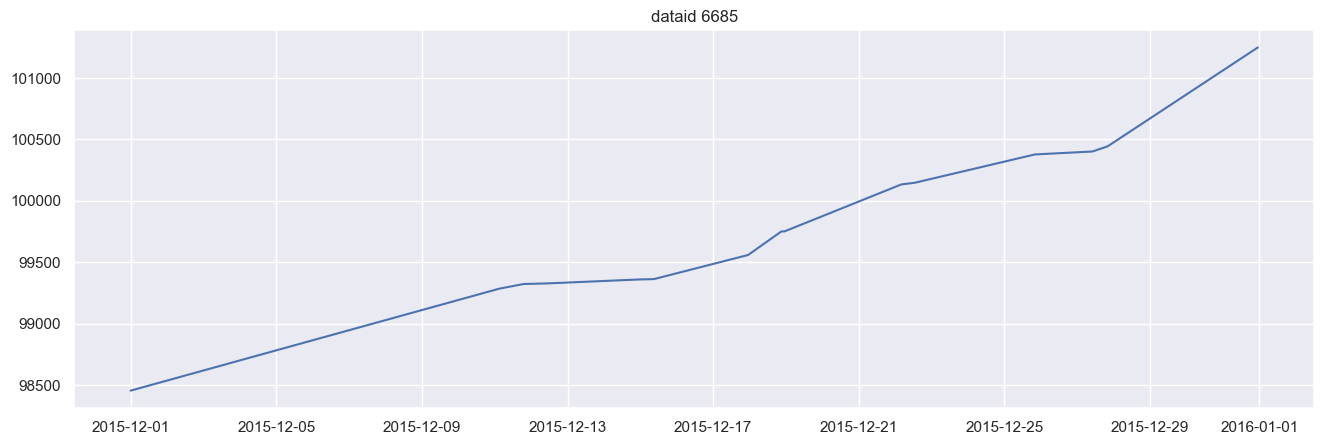

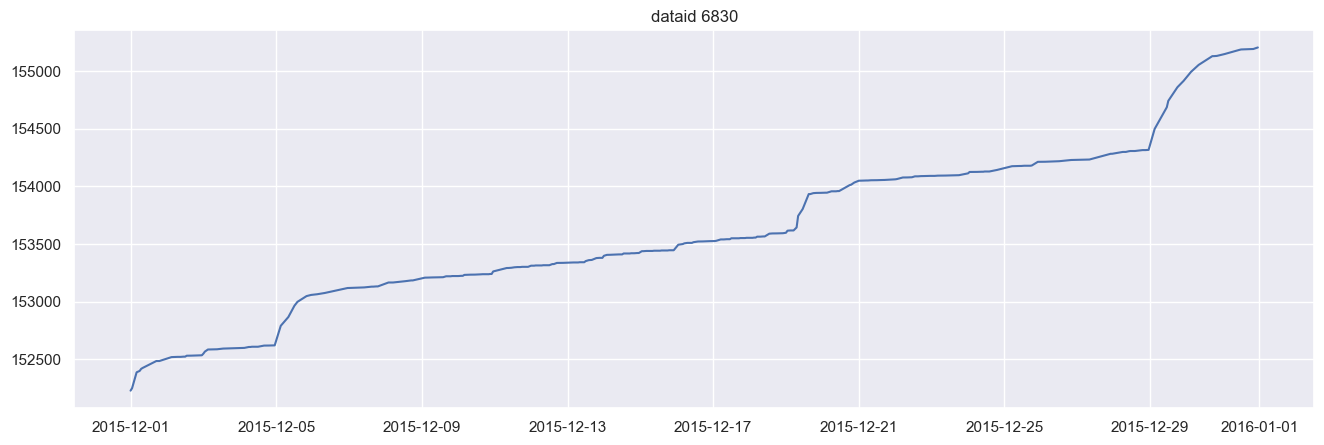

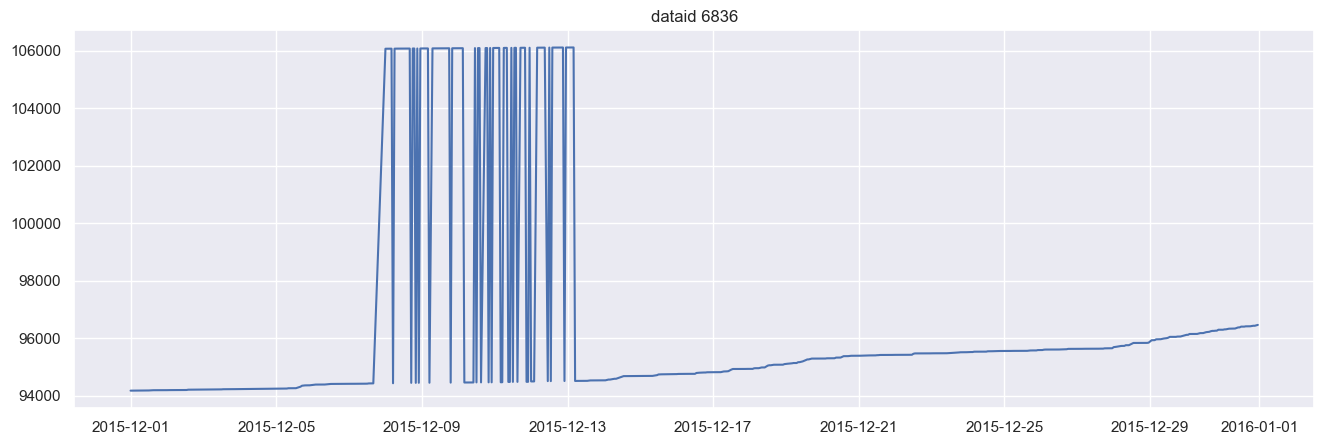

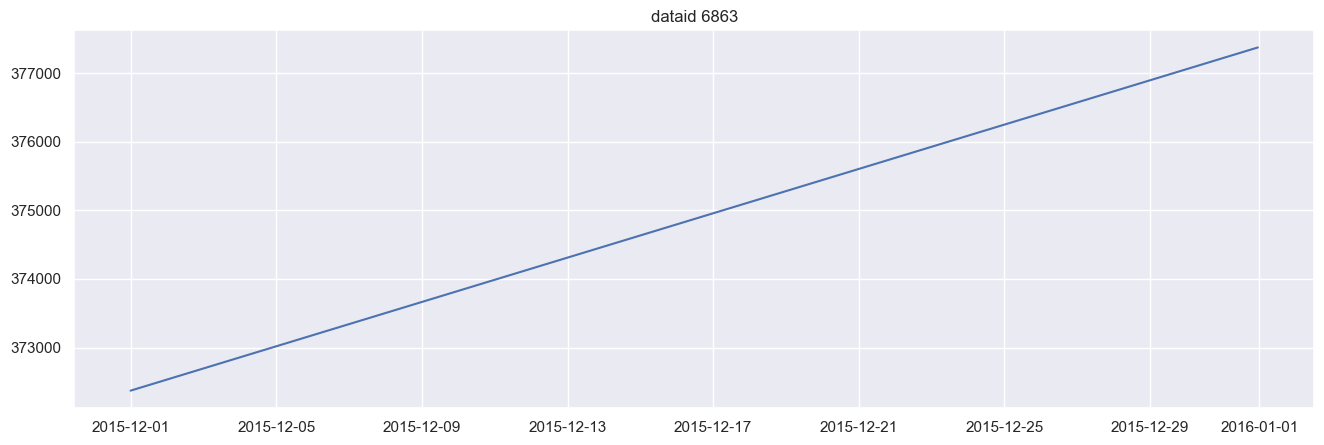

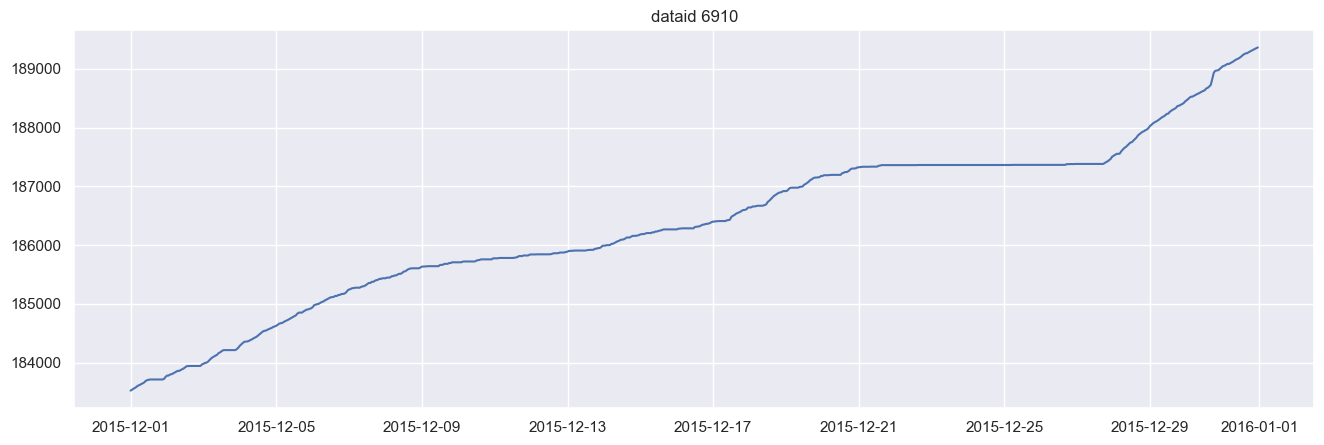

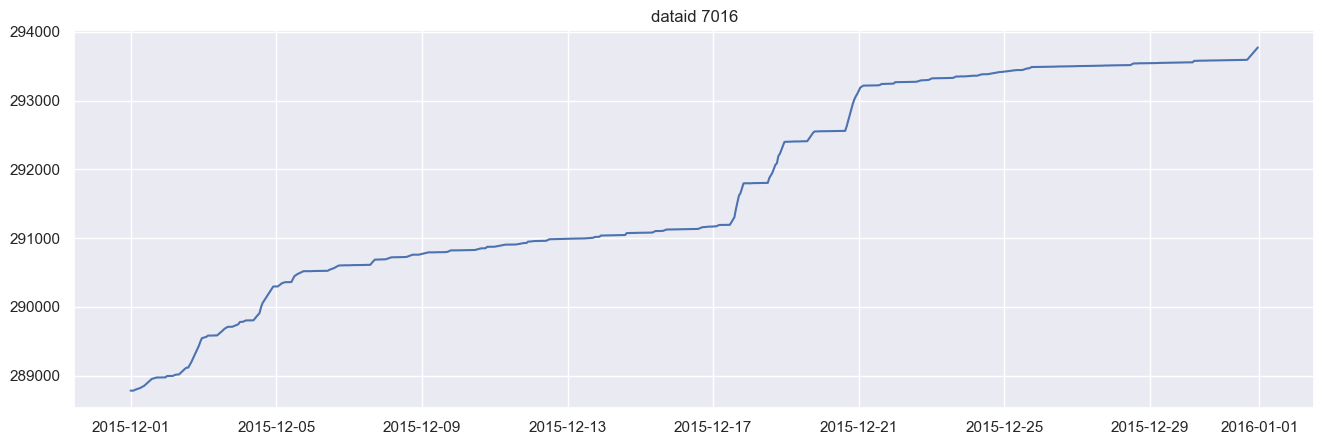

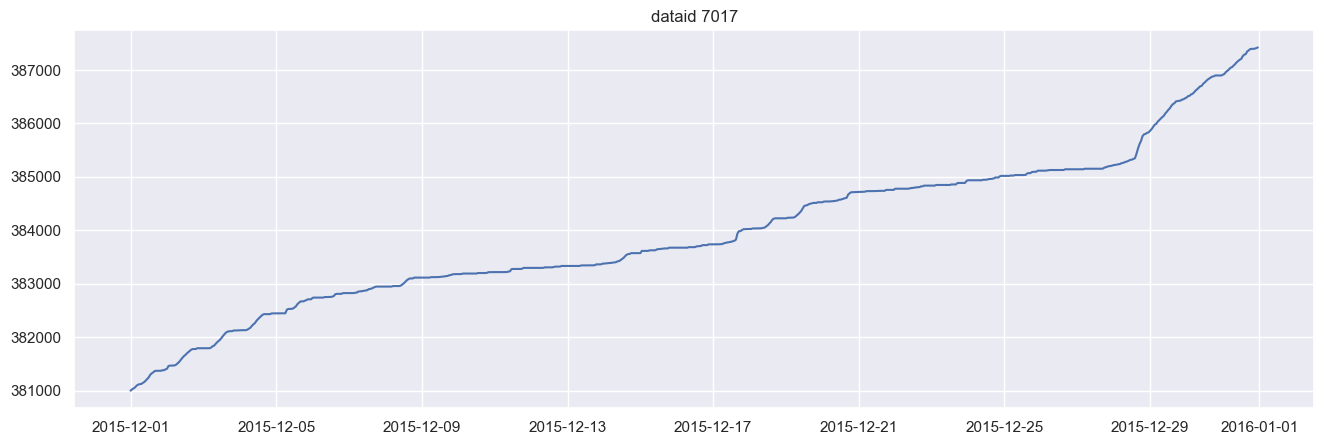

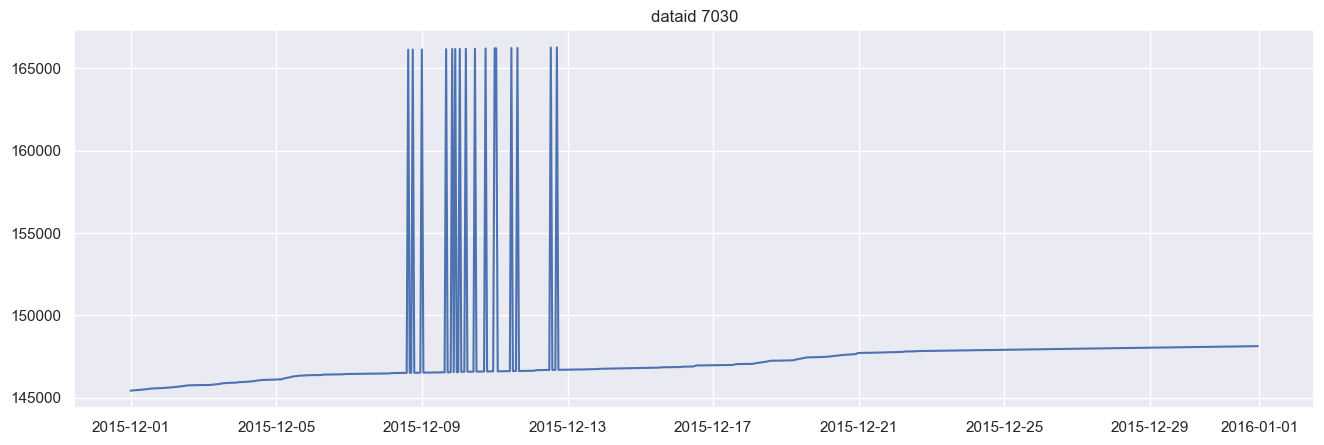

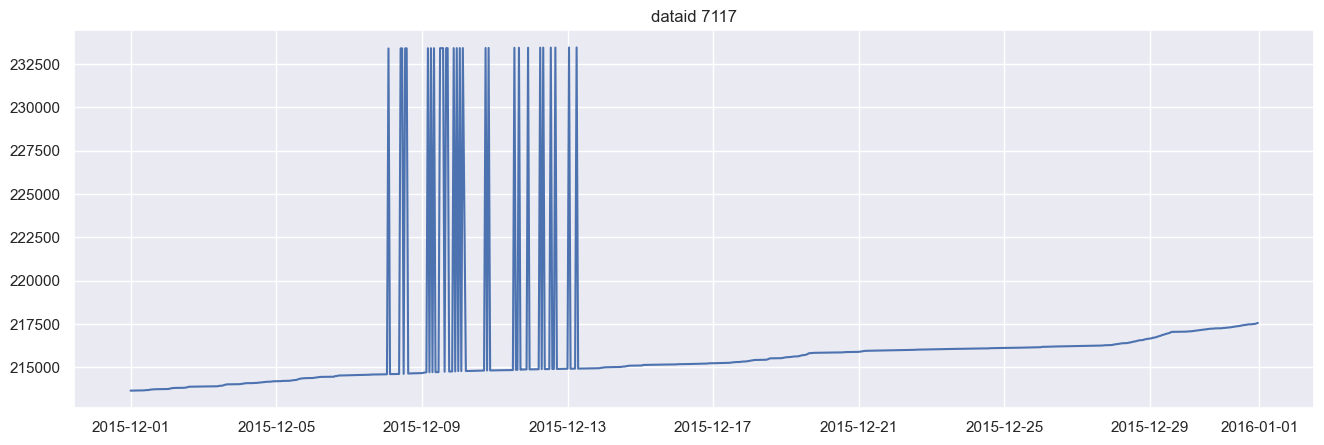

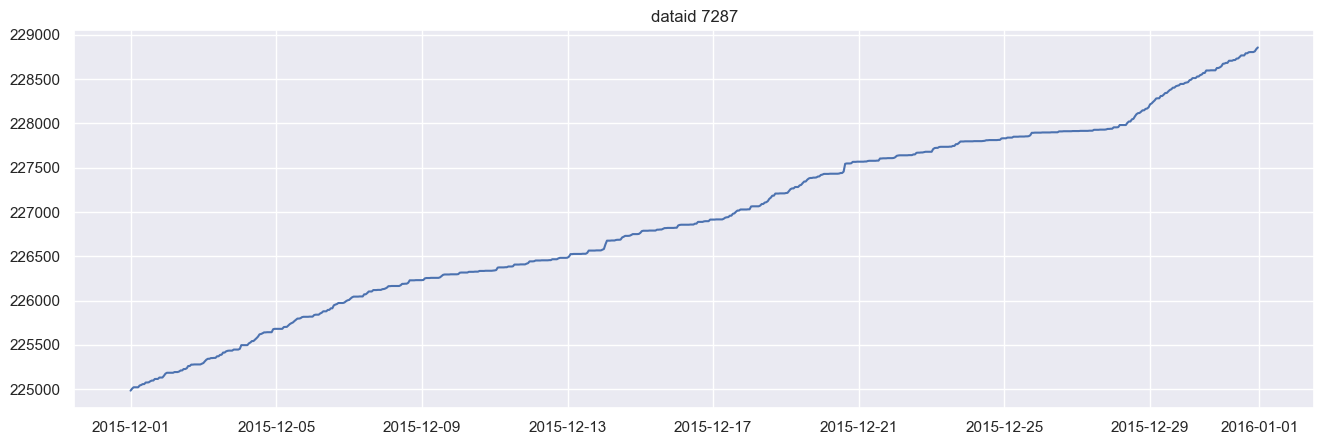

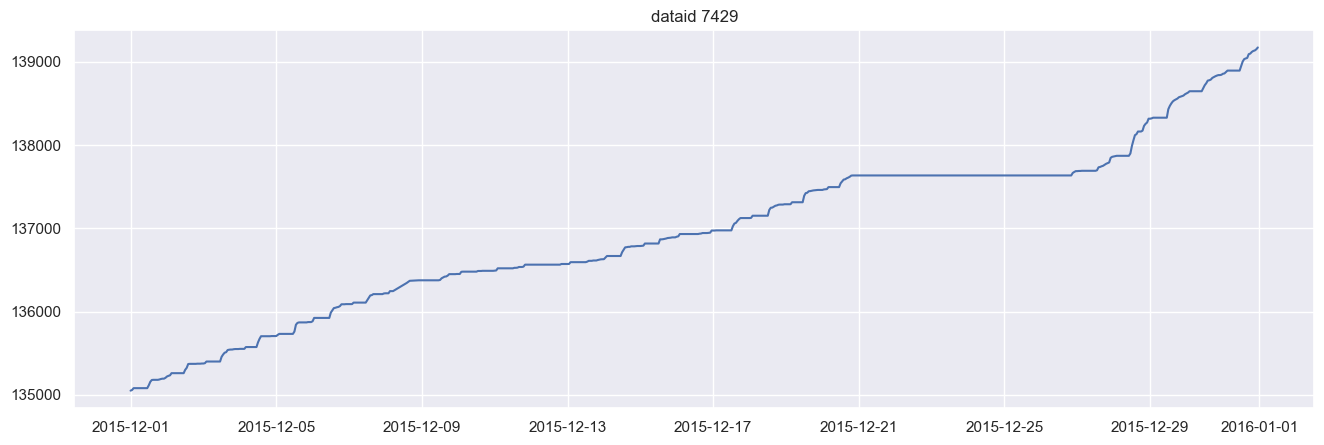

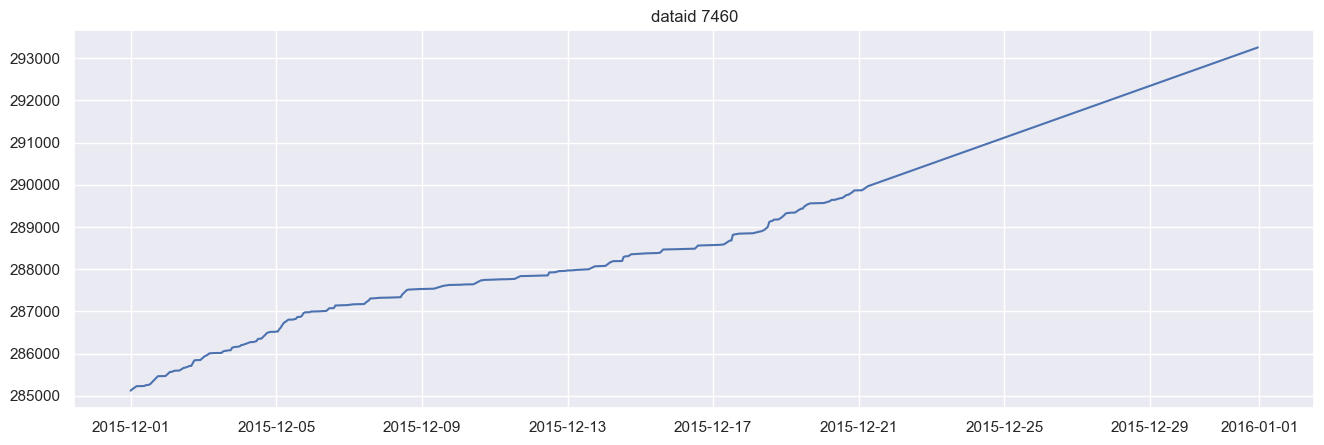

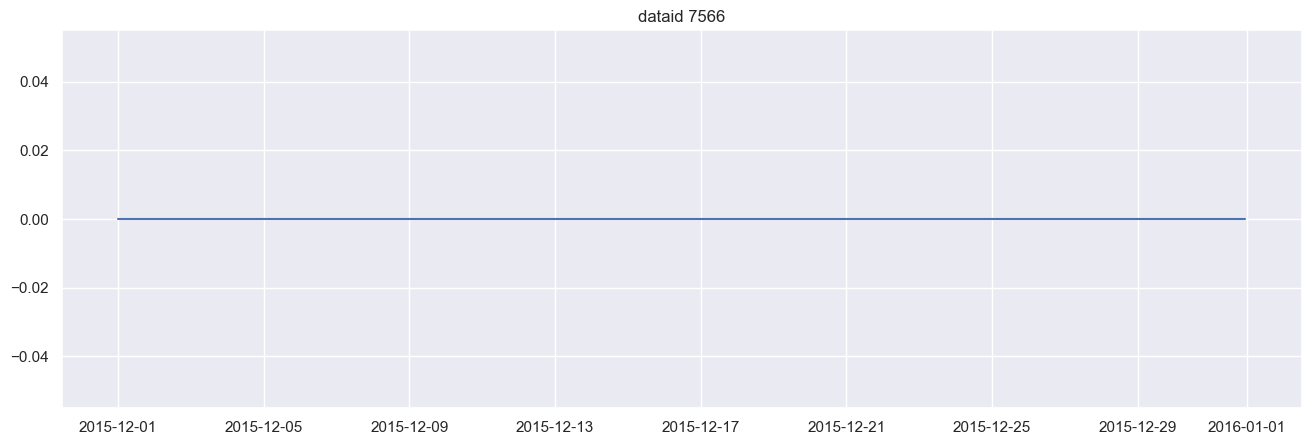

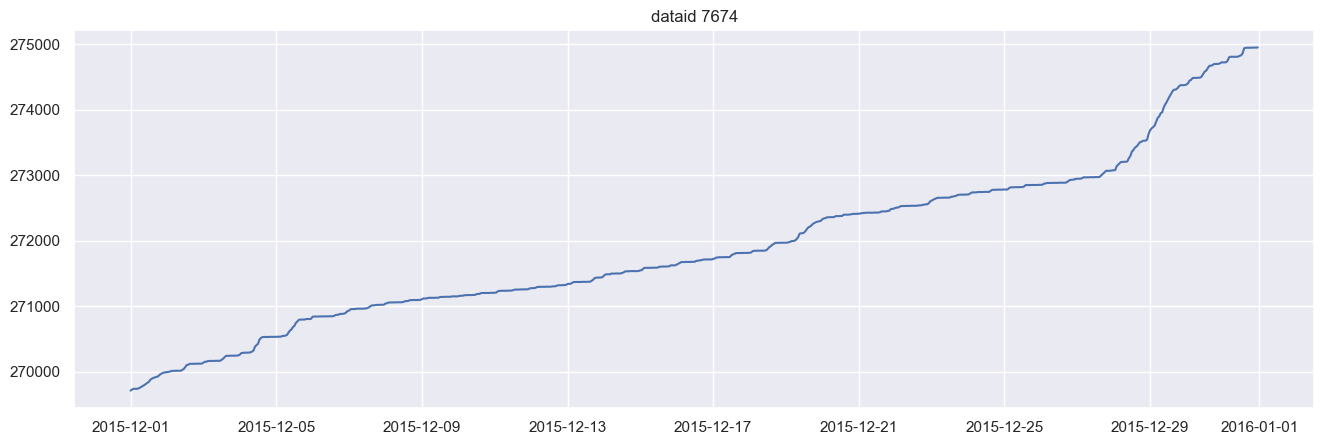

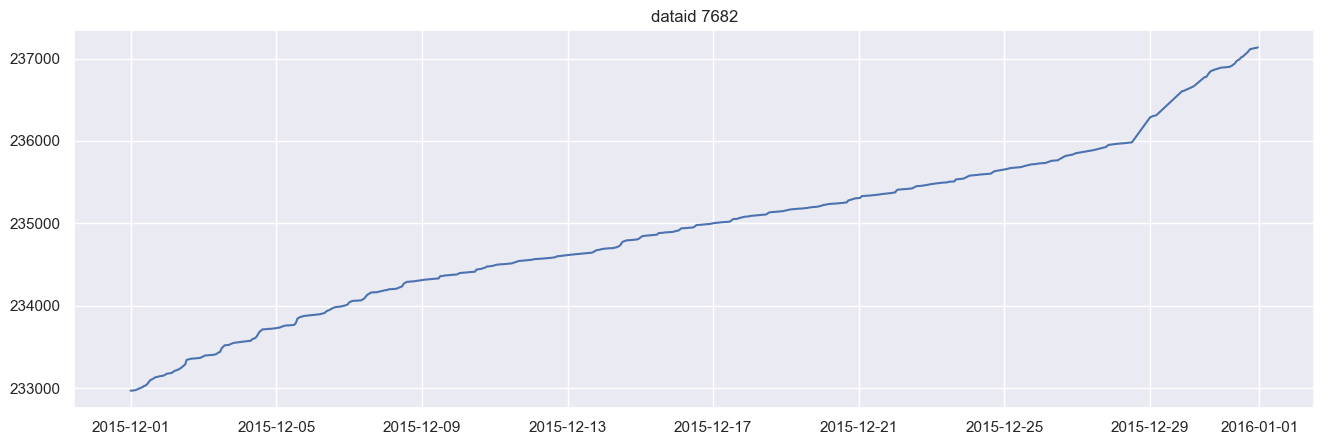

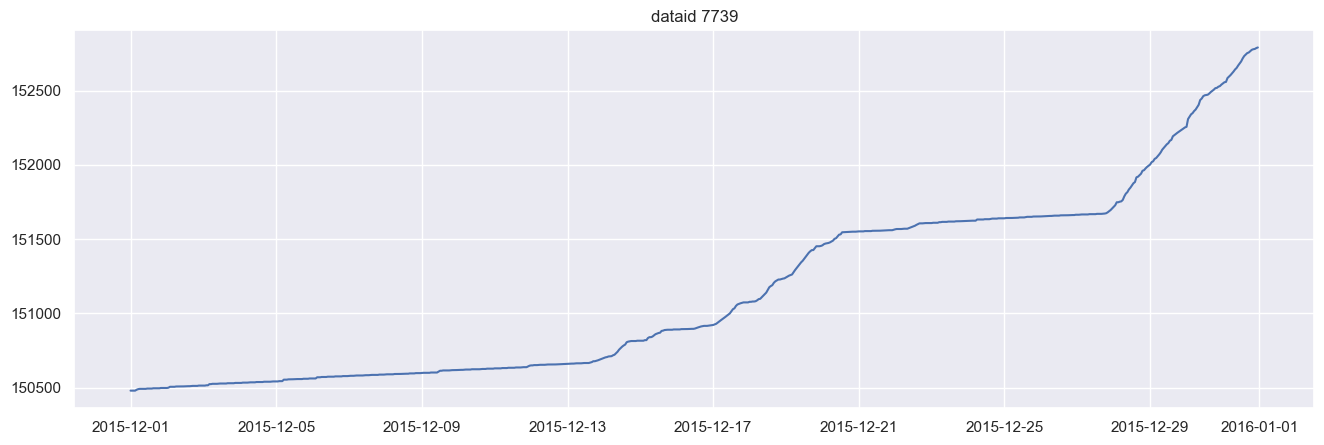

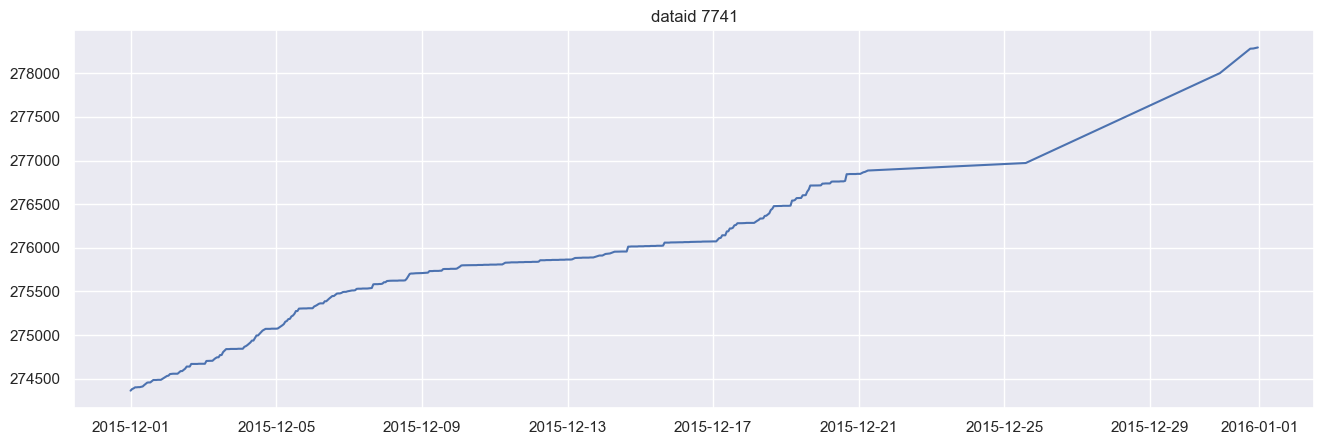

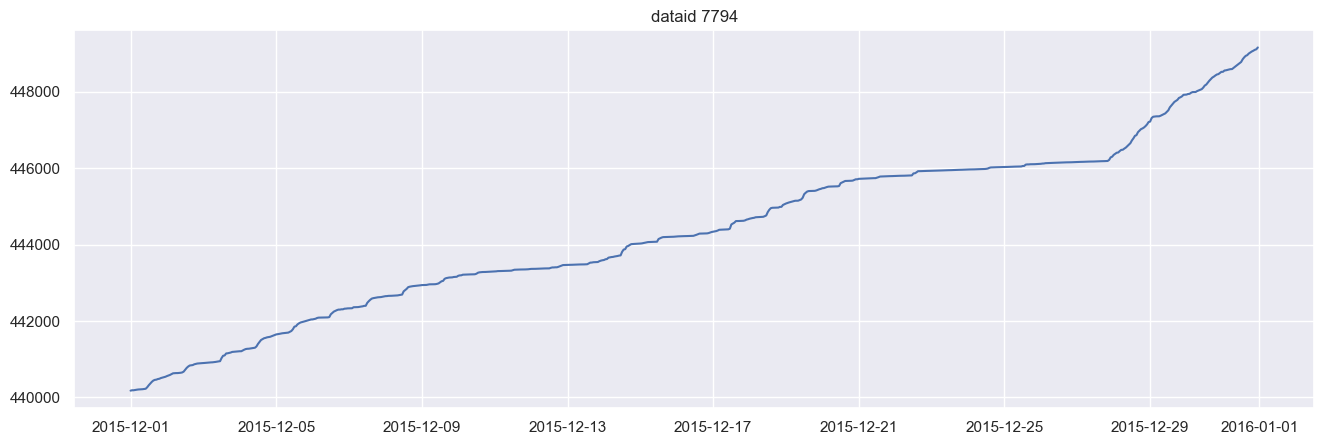

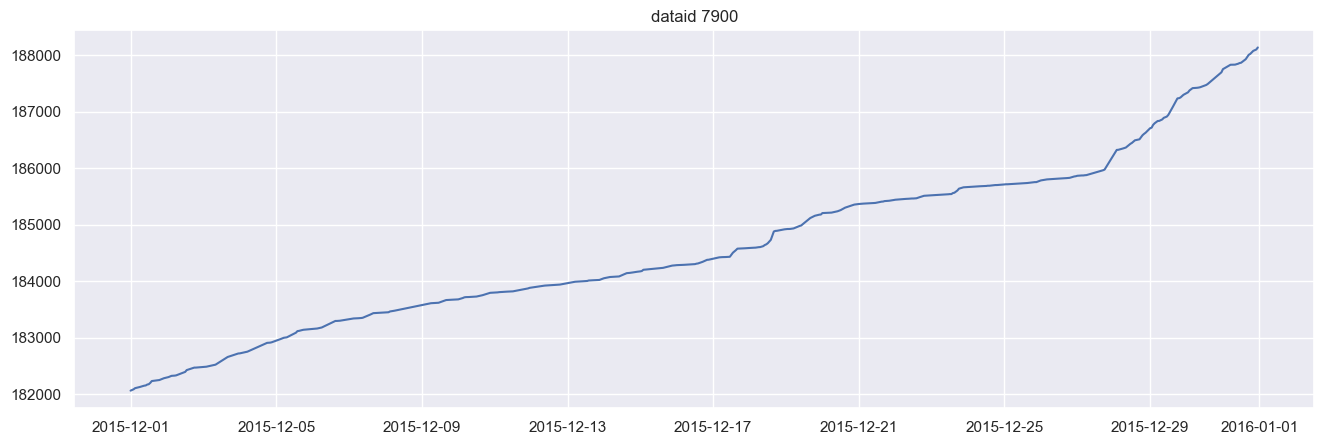

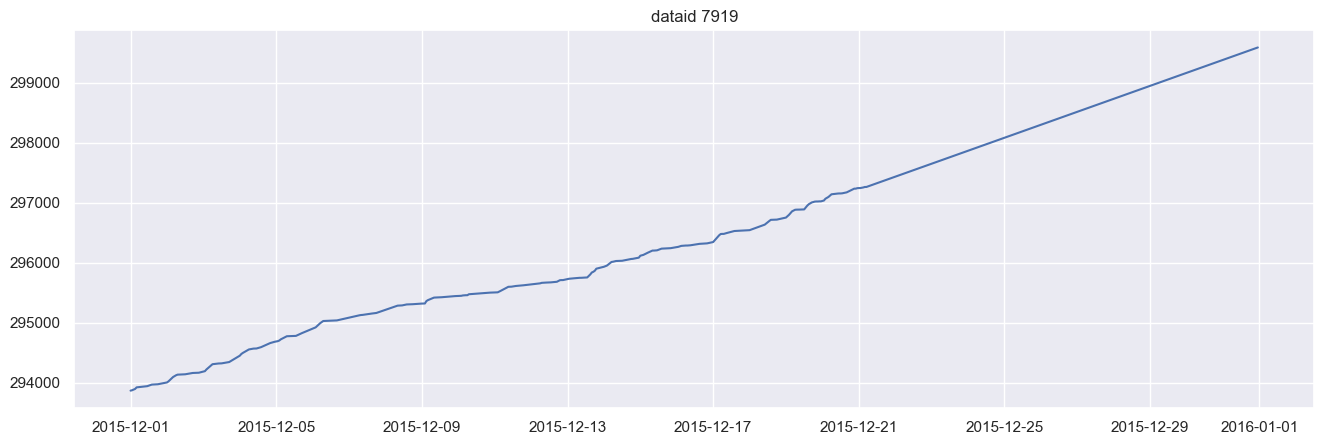

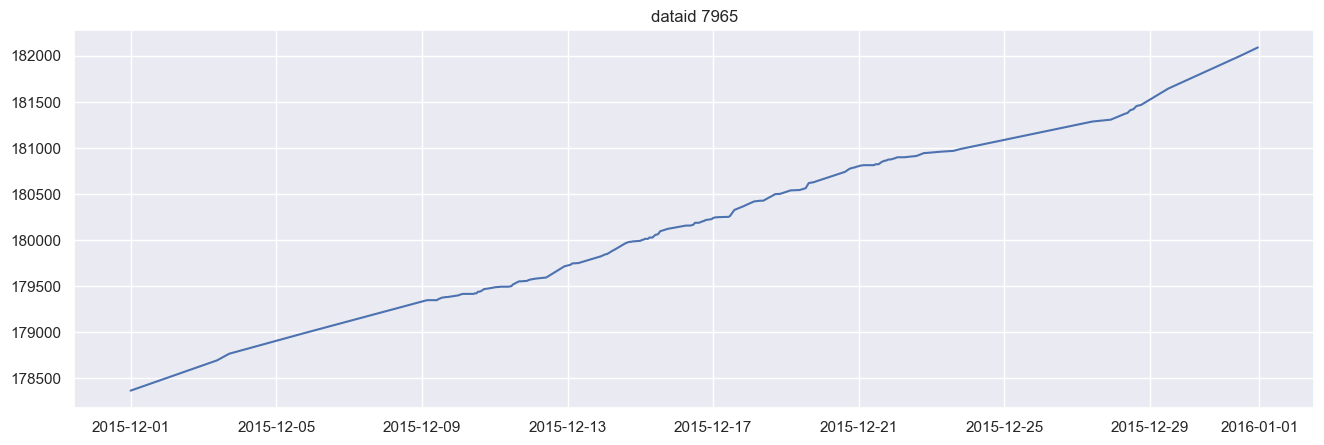

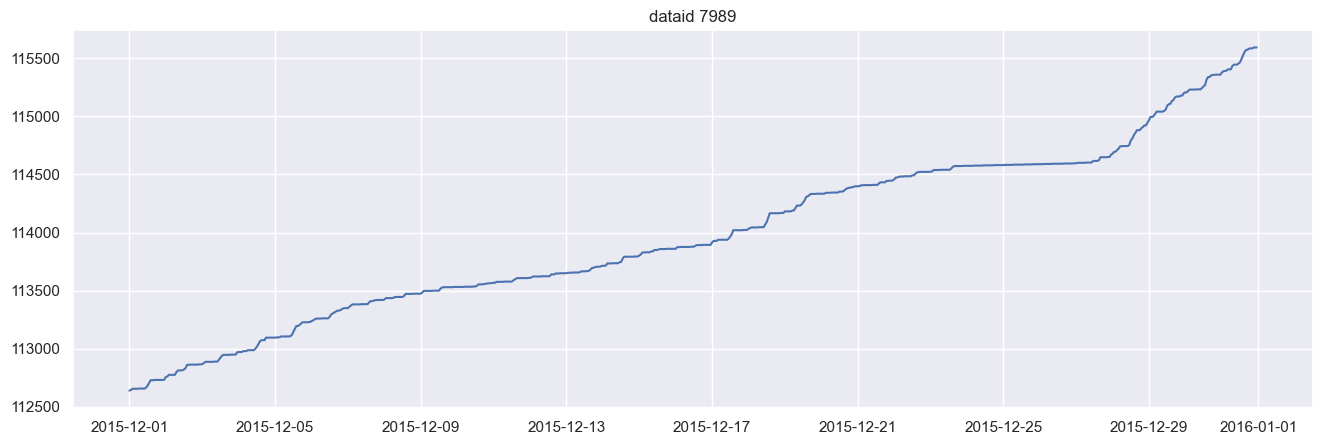

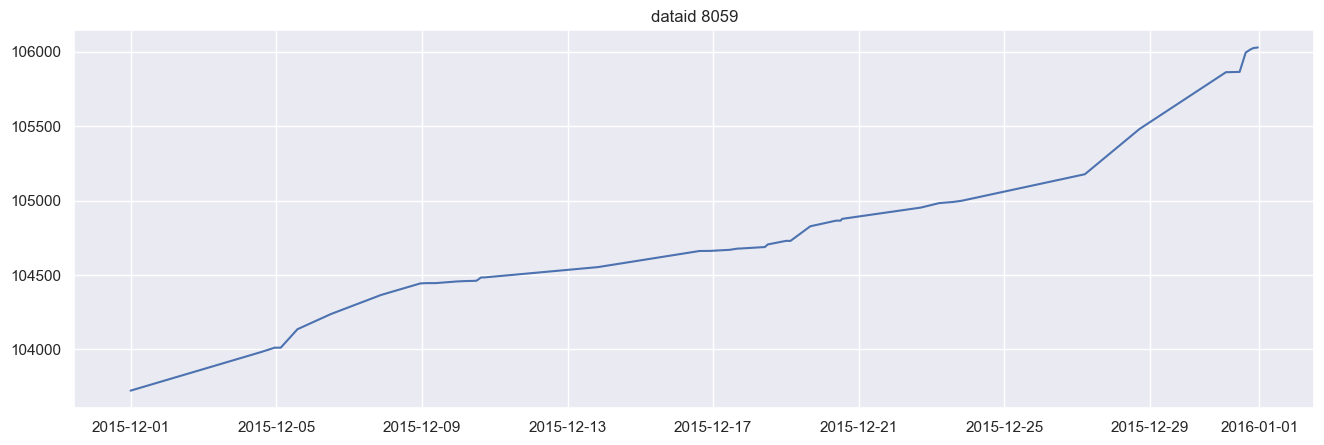

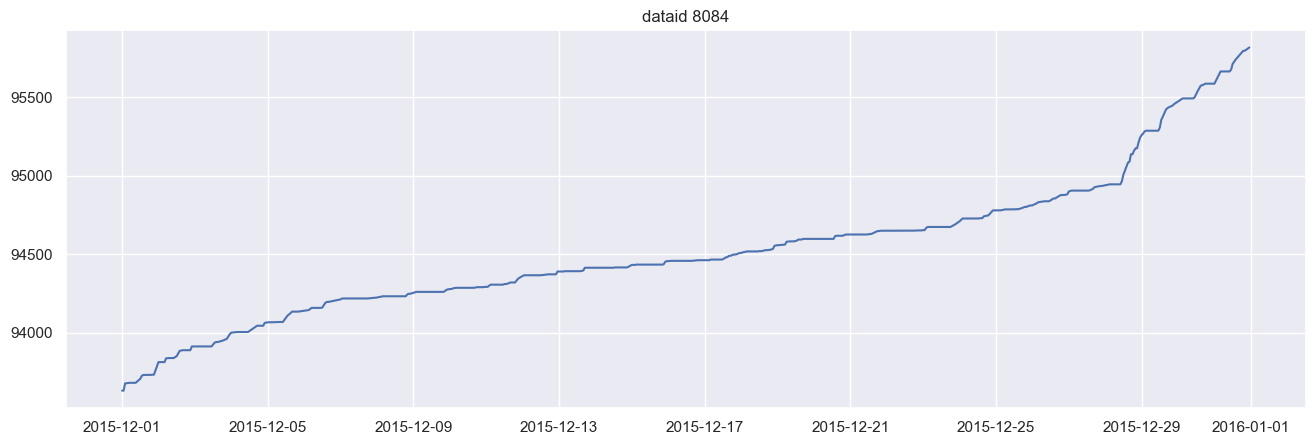

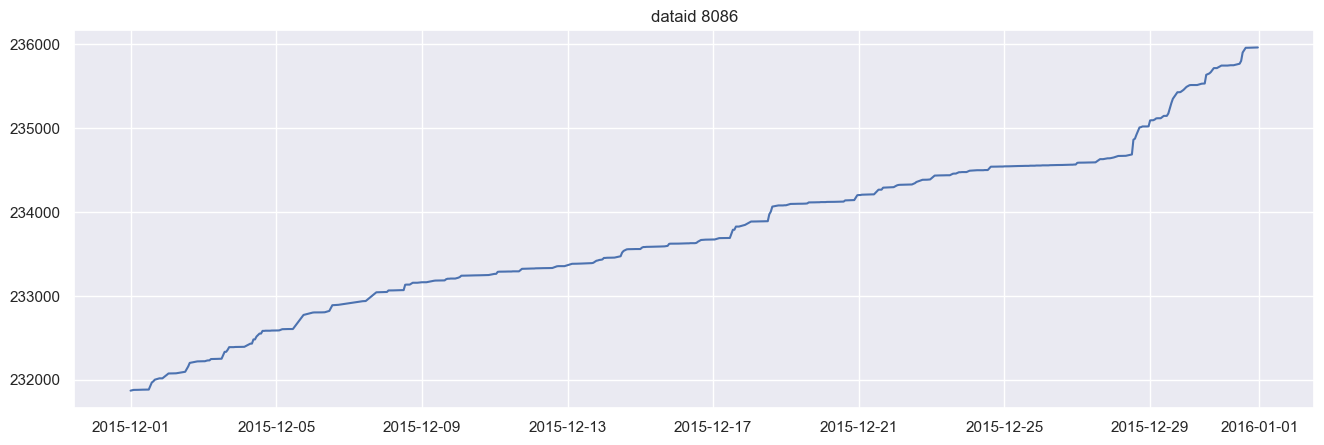

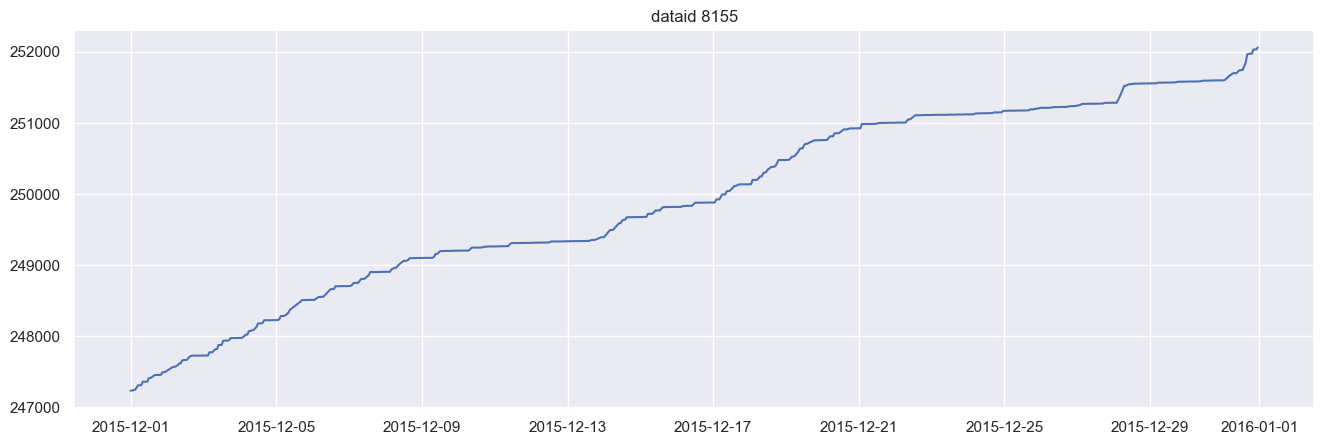

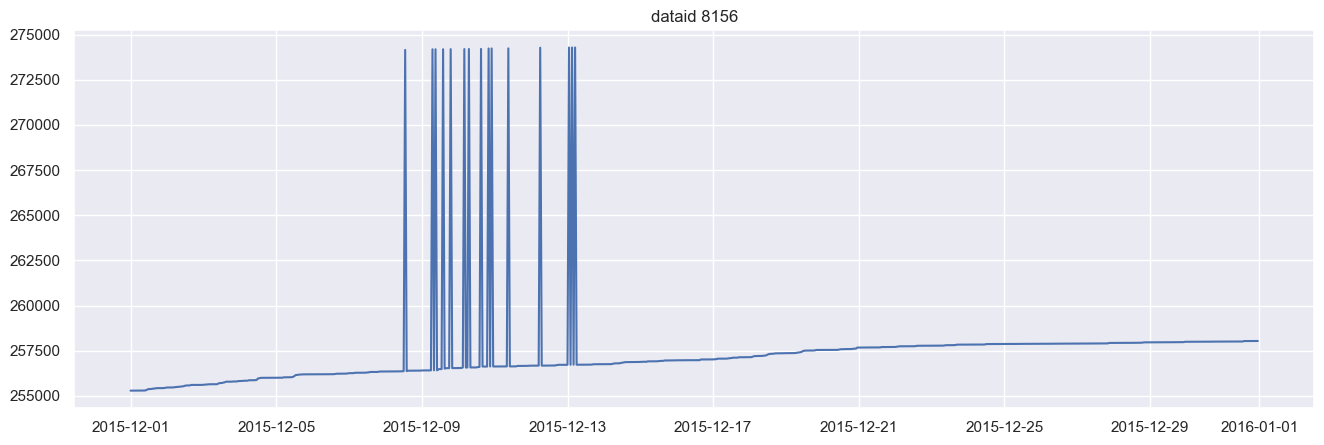

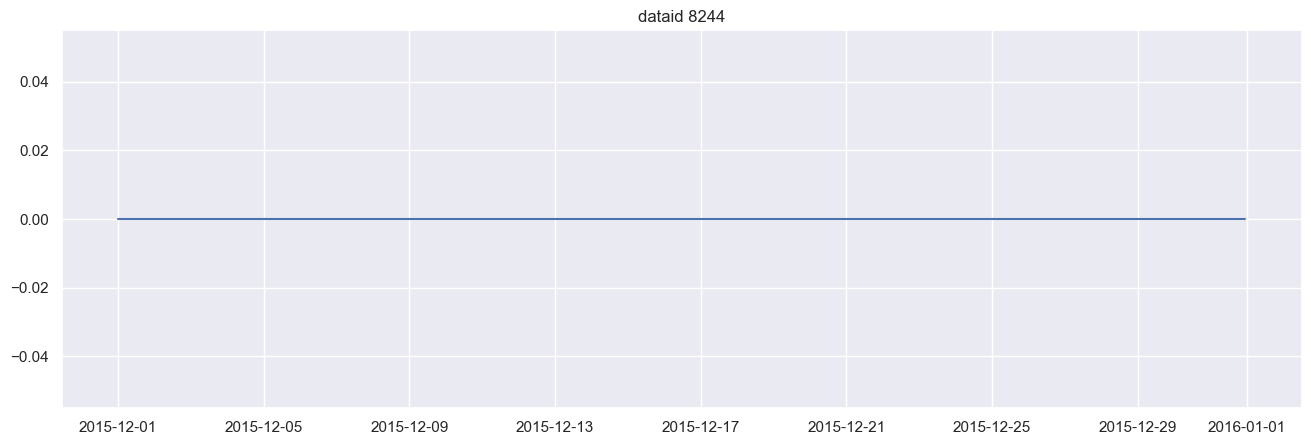

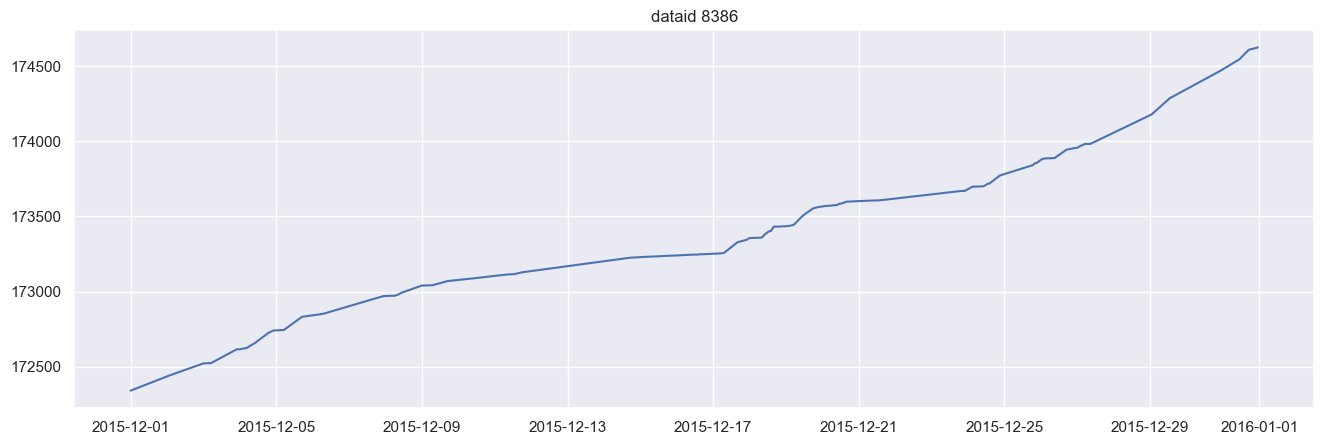

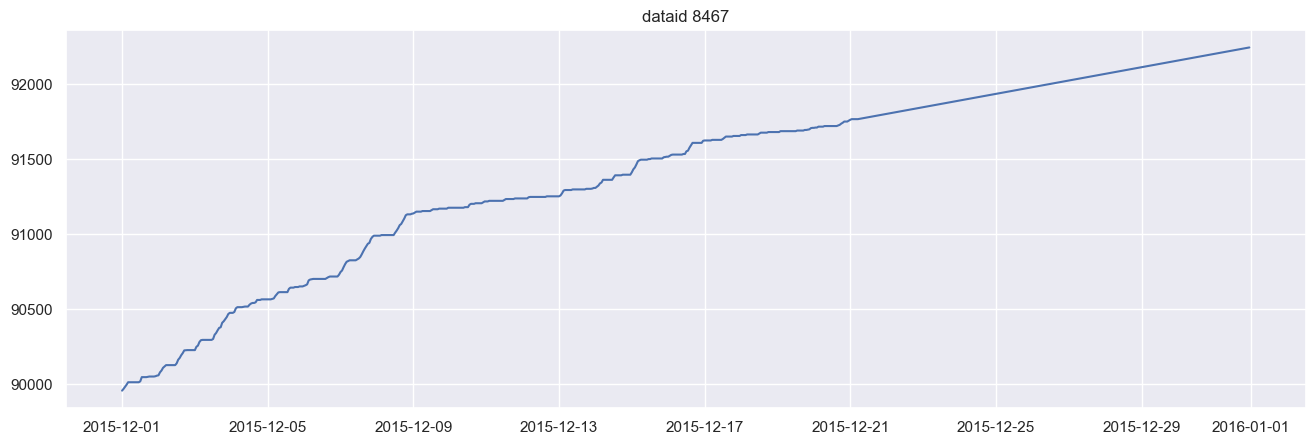

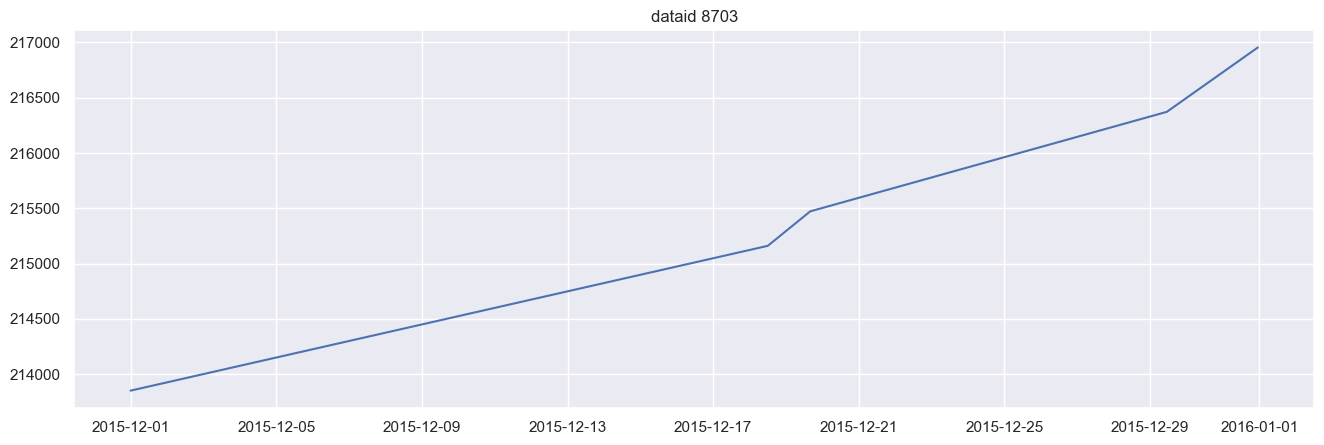

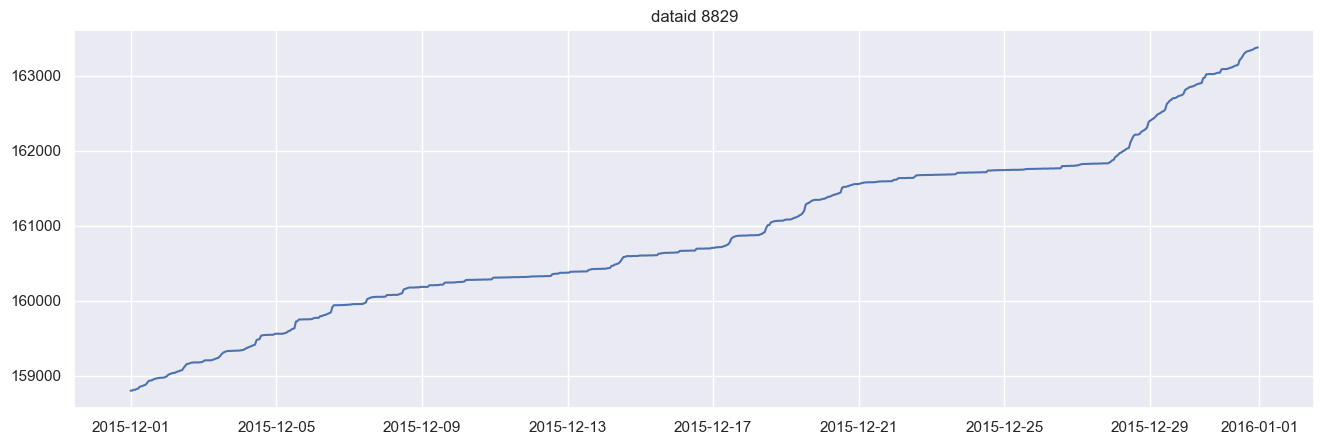

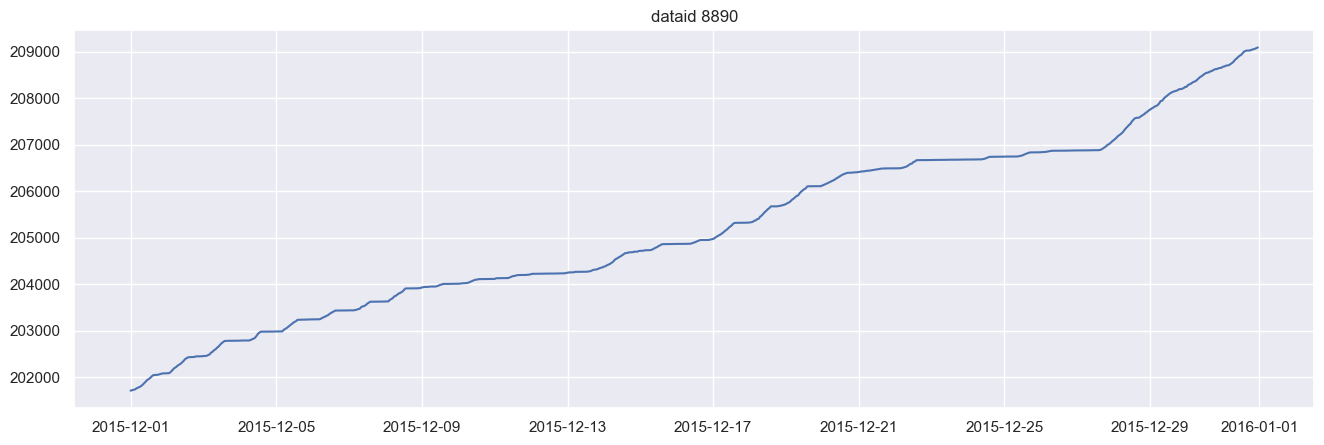

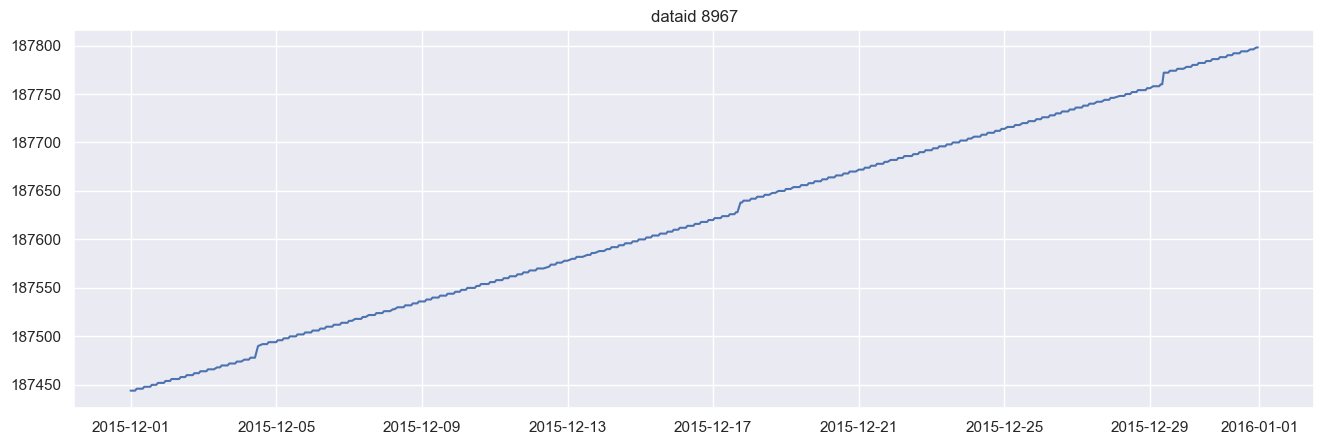

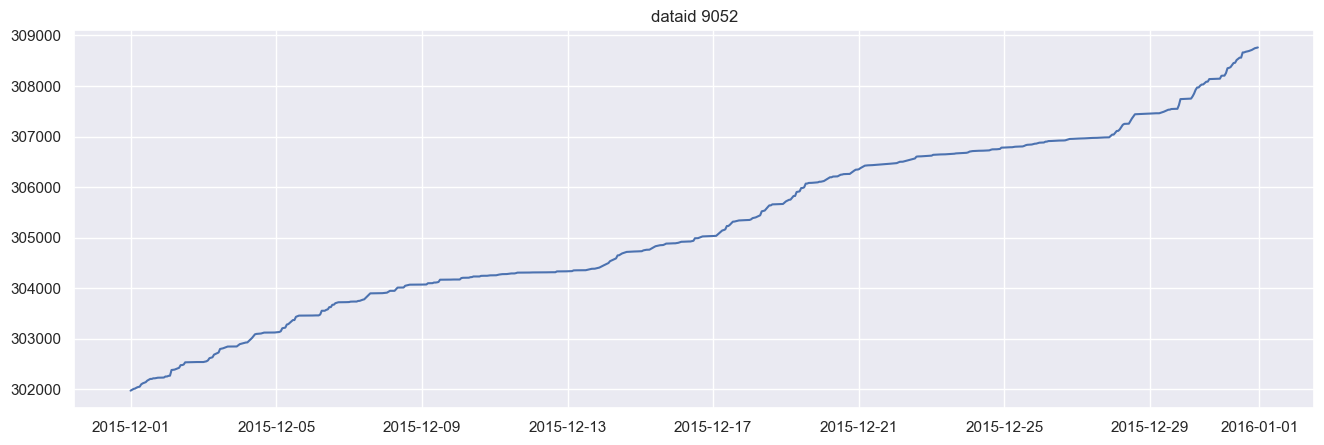

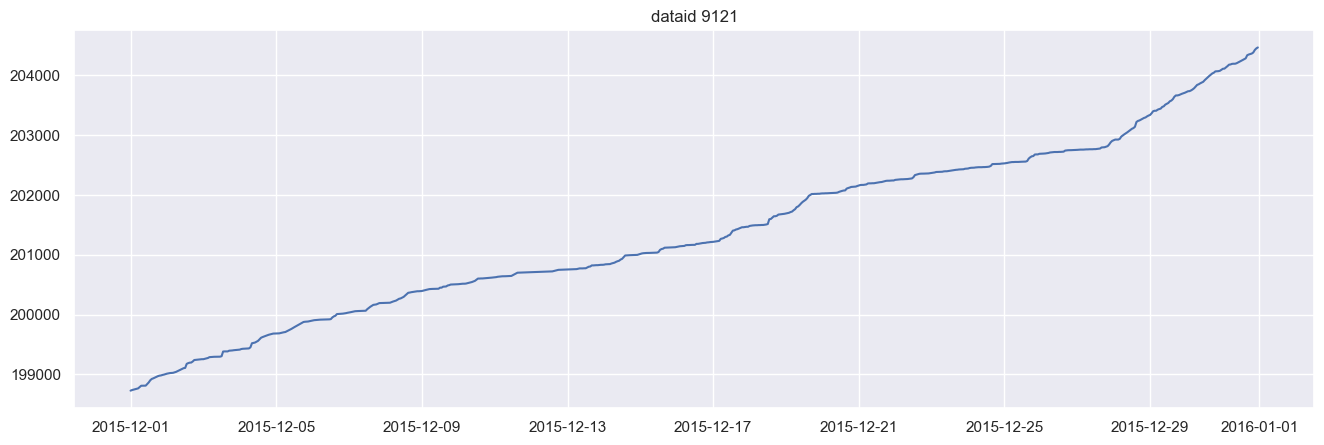

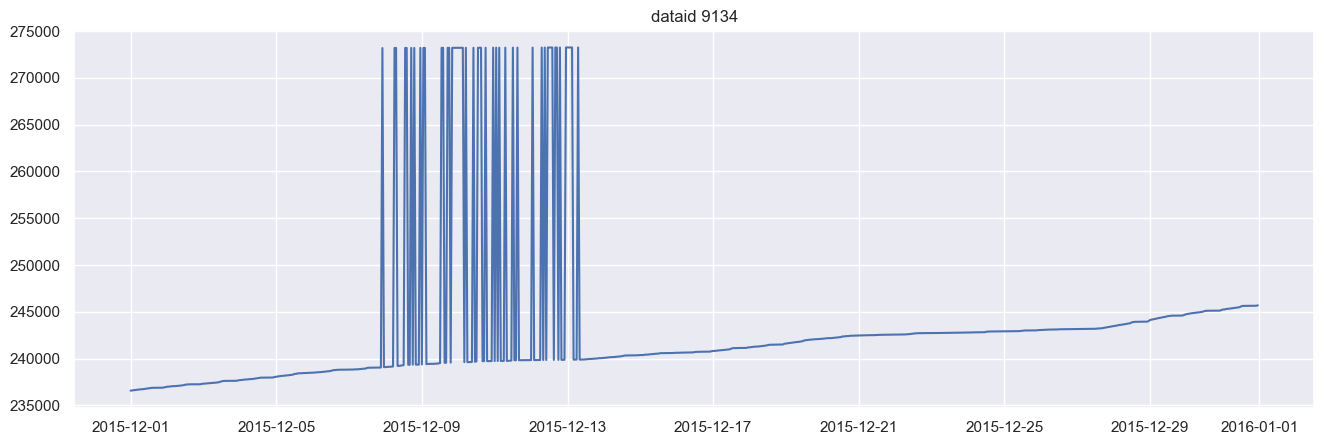

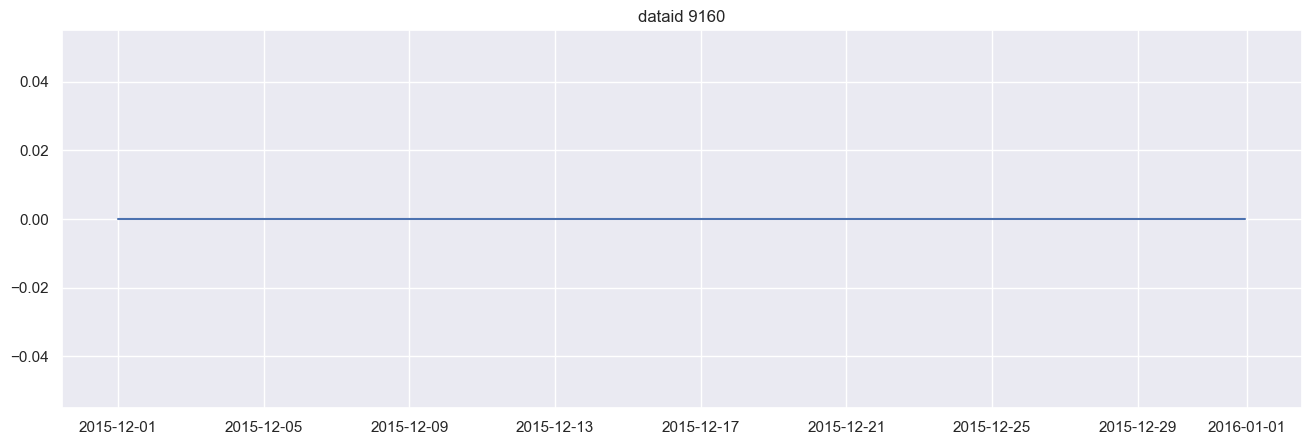

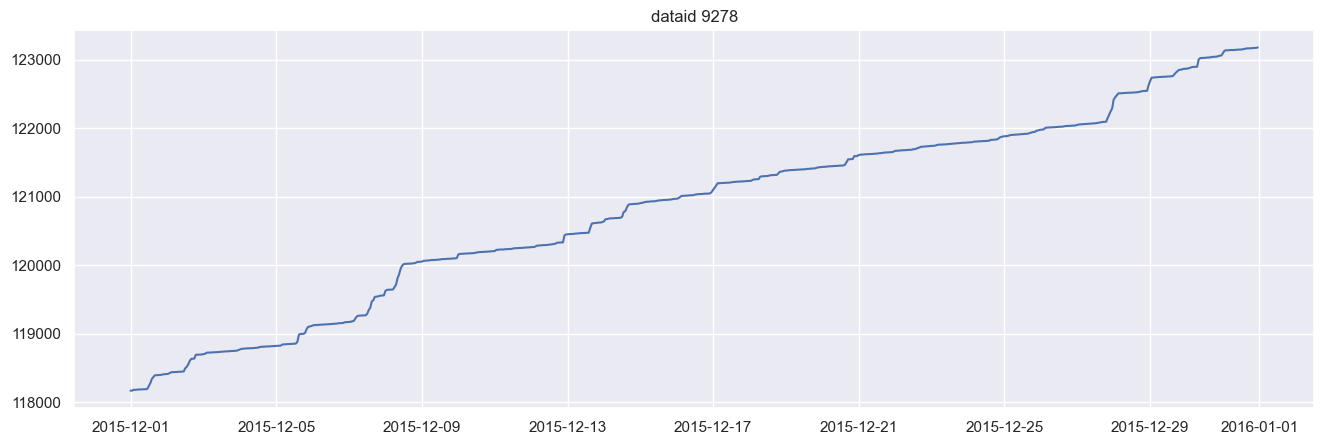

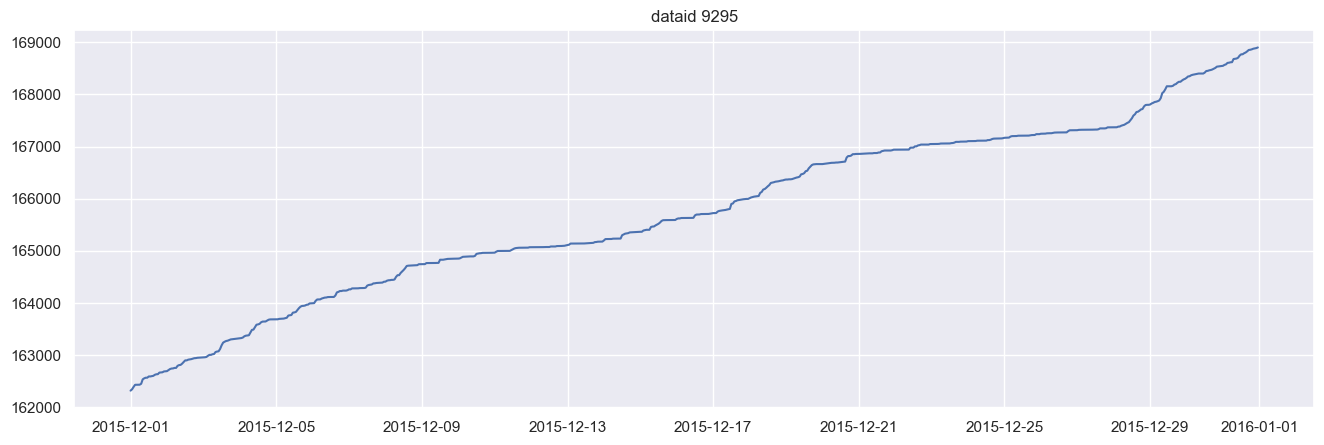

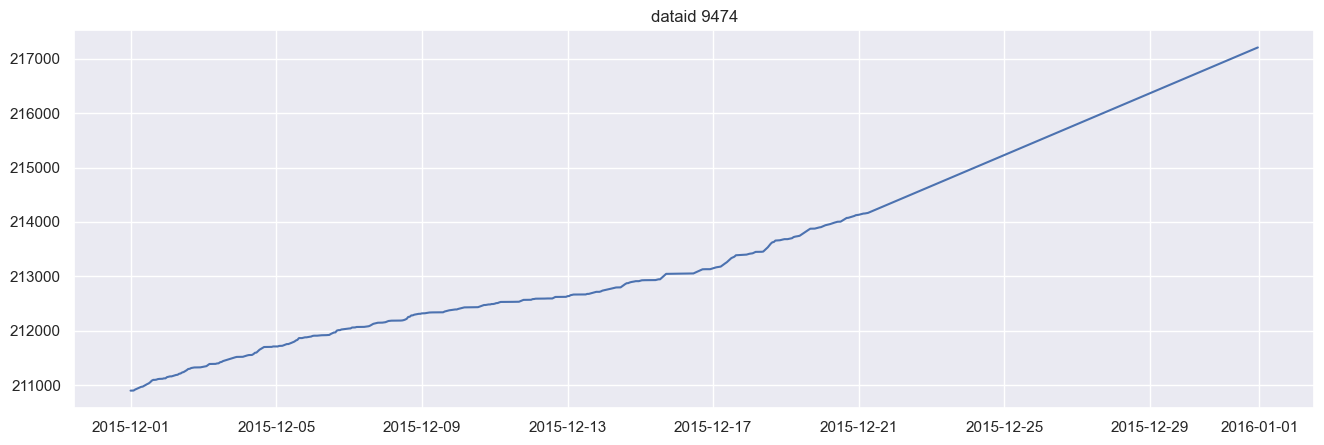

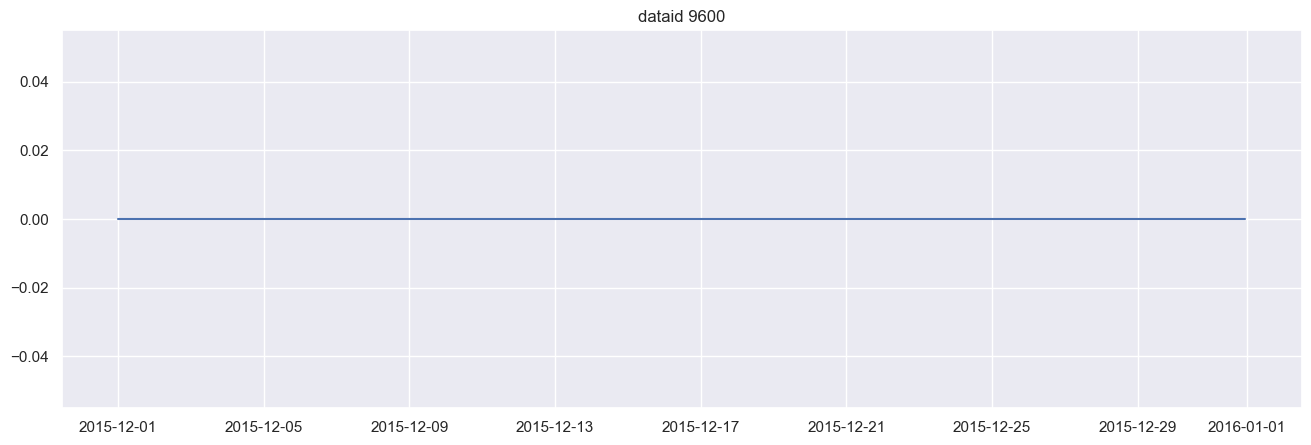

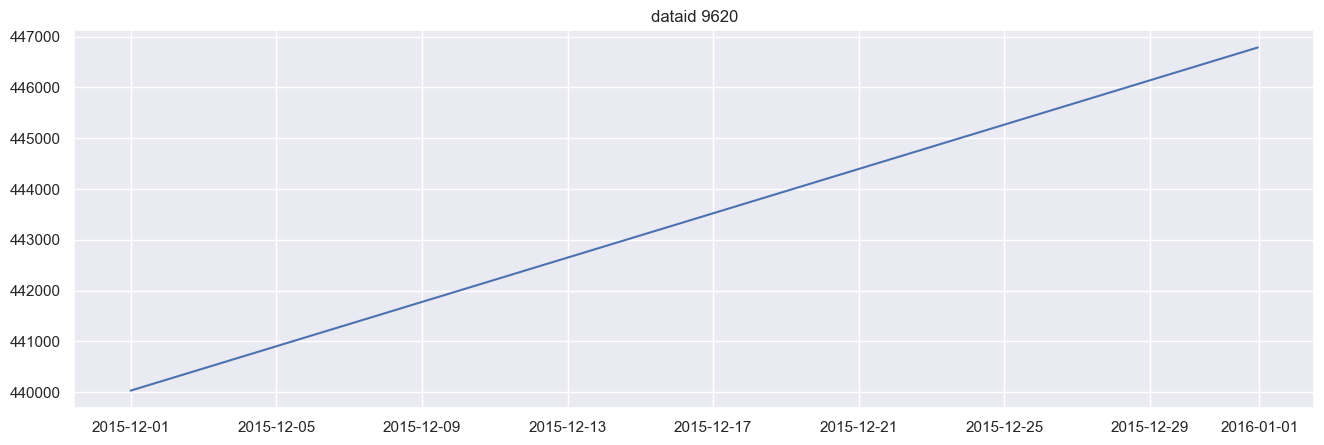

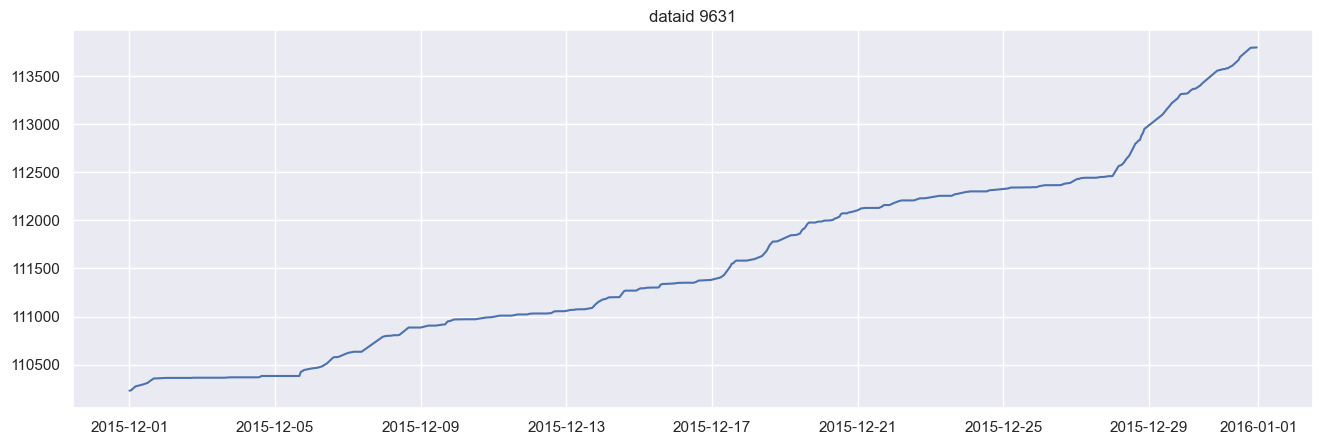

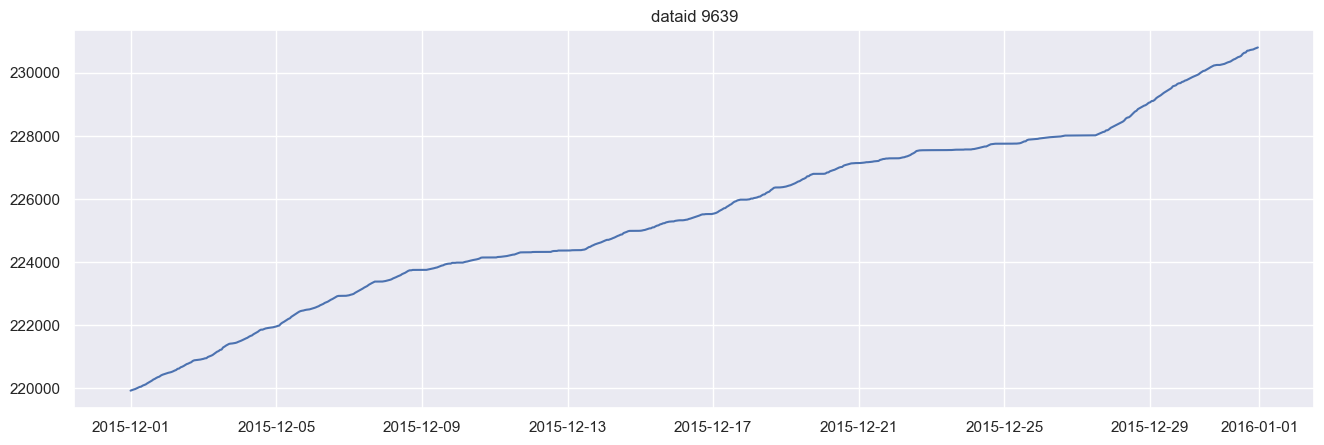

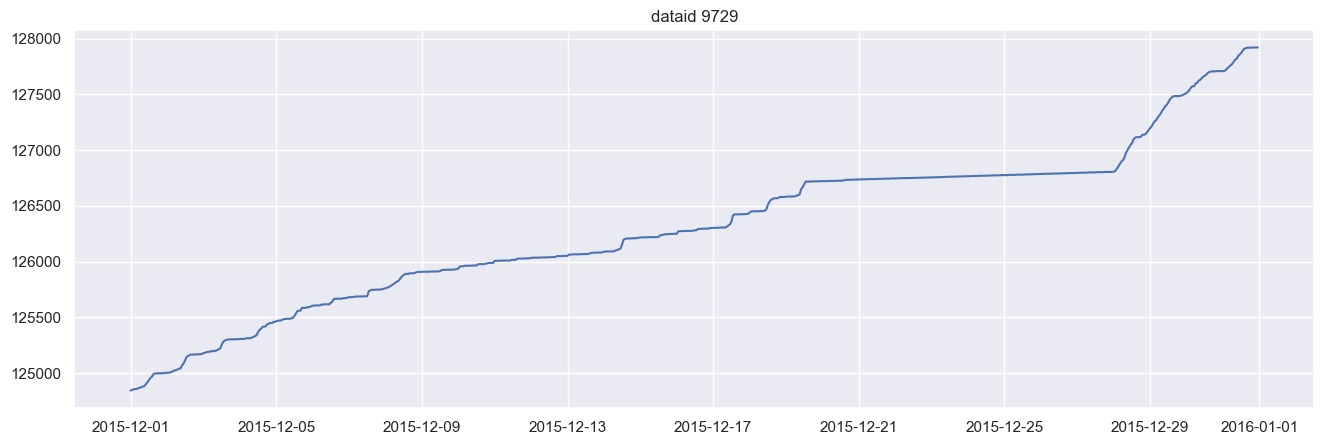

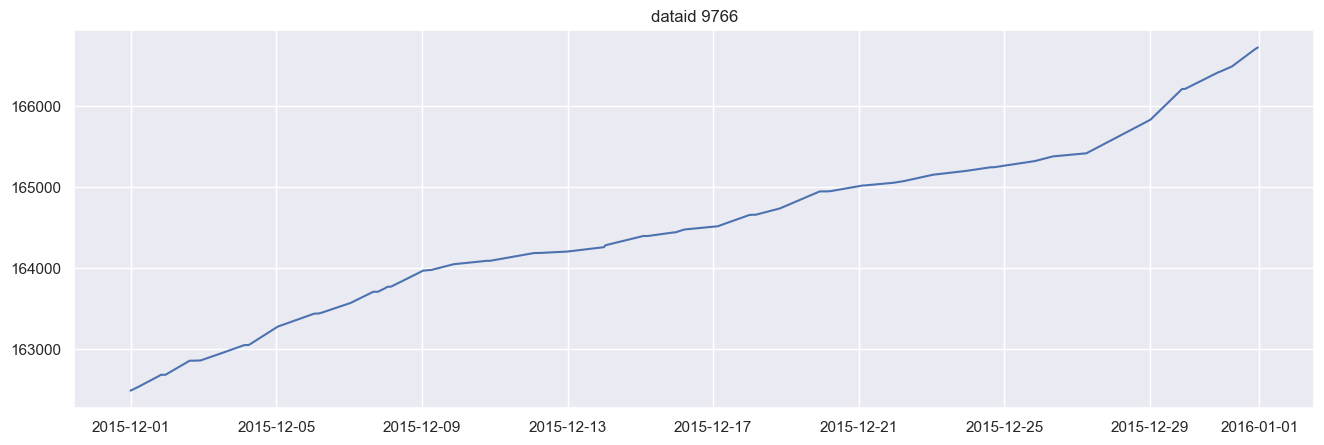

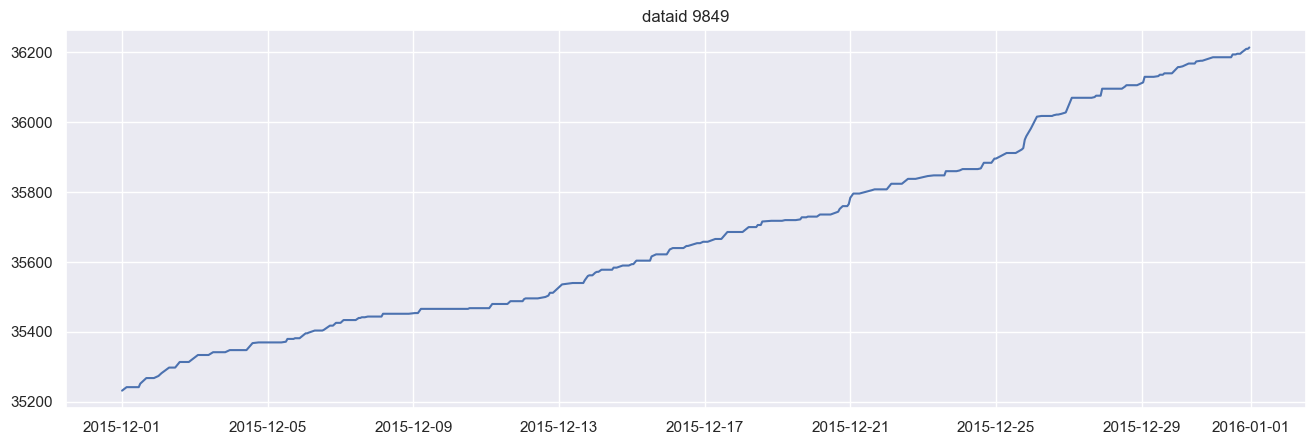

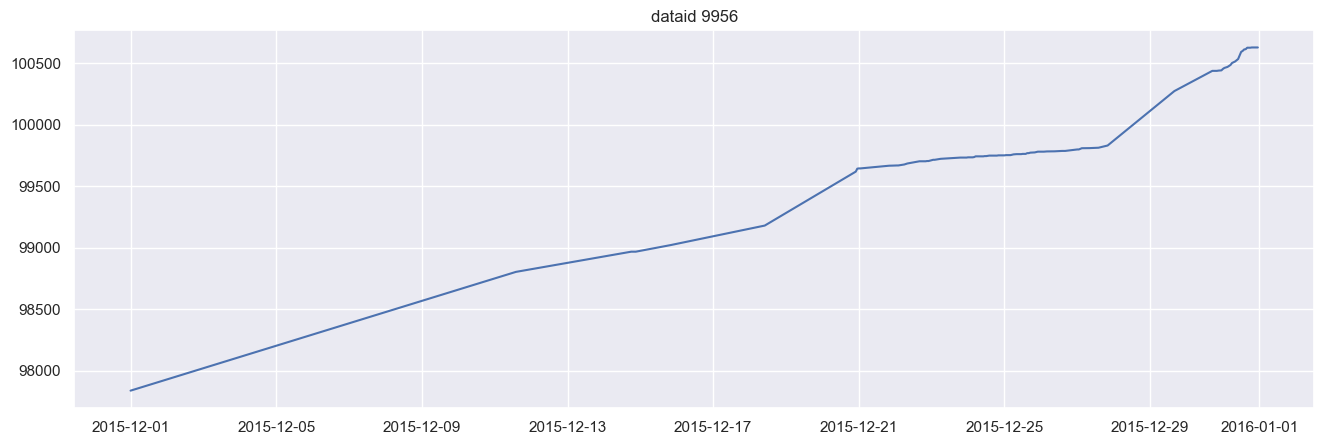

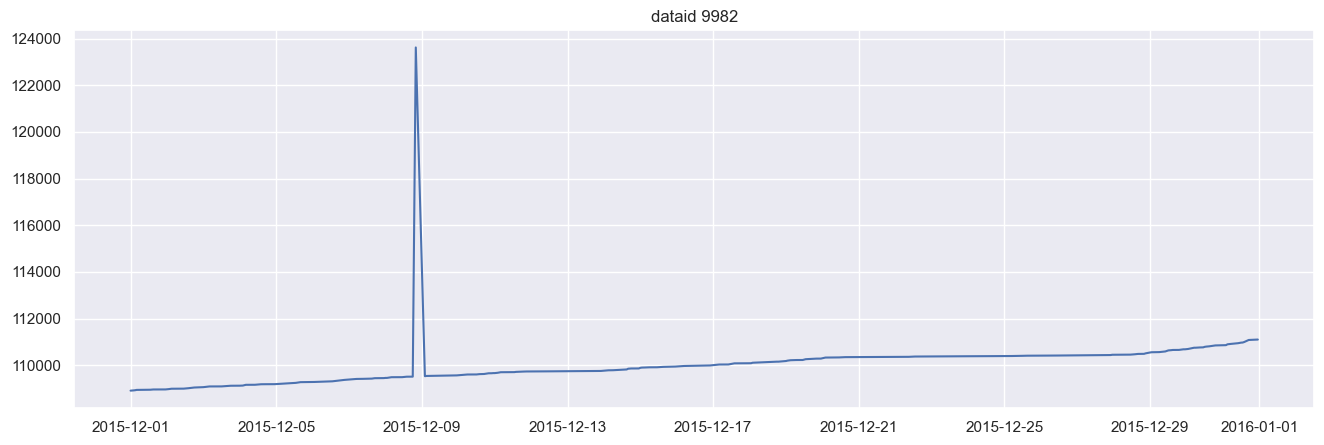

In [13]:
hourly_dfs = []

for house in unique_households:
    house_df = df.loc[df['dataid'] == house]
    
    # we simply interpolate the hours with no data since meter_value is the cumulative usage.
    house_dec_df = house_df.resample('1H').last().interpolate()
    hourly_df = house_dec_df['meter_value']
    hourly_df = hourly_df["2015-12-01": "2015-12-31"]
    hourly_df = hourly_df.reindex(pd.date_range("2015-12-01 00:00:00+00:00", "2015-12-31 23:59:59+00:00", freq='H')).fillna(0)
    hourly_df = hourly_df.rename(house)
    hourly_dfs.append(hourly_df)
    plot_hourly_df(hourly_df, house)

As can be seen above, for certain households (e.g: 2814), the total gas consumption was 0. This possibly indicates that the particular household might have went for a vacation during the holidays and hence was not occupied during the month. We will be considering this insight when answering question 2. 

# Q1.3 
## For each home, find the top five homes with which it shows the highest correlation

### Approach
First, we concatnate the hourly dataframes. Then, for every meter, we calculate the correlation between it and the other meters. Next, we set the correlation of that particular meter with itself as 0. And lastly, for every meter, we sorted the correlation list to obtain the top five meters with which it shows the highest correlation. 

In [14]:
def get_top_five_corr(row):
    """
    For each home, to find the top five homes with which it shows the highest correlation
    """
    new_row = row
    key_val_pair_list = [(value, key) for key, value in row.items()]
    key_val_pair_list = sorted(key_val_pair_list, reverse=True)
    result = key_val_pair_list[:5]
    for index, (value, key) in enumerate(result):
        new_row[f'Top {index + 1} value'] = value
        new_row[f'Top {index + 1} dataid'] = key
    
    return new_row

In [15]:
# create correlation matrix, filling diagonals and NaN with 0
merged = pd.concat(hourly_dfs, axis=1)
corr_df = merged.corr().fillna(0)
corr_df.values[[np.arange(corr_df.shape[0])]*2] = 0
new_corr_df = corr_df.apply(lambda x: get_top_five_corr(x), axis=1)
columns = []
for index in range(5):
    columns.append(f'Top {index+1} dataid')
    columns.append(f'Top {index+1} value')
    
new_corr_df = new_corr_df[columns]

<ipython-input-15-8689a979ca8c>:4: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  corr_df.values[[np.arange(corr_df.shape[0])]*2] = 0


In [16]:
new_corr_df

Top 1 dataid  Top 1 value  Top 2 dataid  Top 2 value  Top 3 dataid  \
35          1790.0     0.997973        9766.0     0.997802        7794.0   
44          5658.0     0.998230        9620.0     0.997971        4671.0   
77            44.0     0.996479        9620.0     0.996237        4671.0   
94           661.0     0.999683        2129.0     0.999401        5892.0   
114         1801.0     0.998541        3527.0     0.998399        5814.0   
187         3577.0     0.999341        5814.0     0.998972        3918.0   
222         8467.0     0.990999        2378.0     0.981276         739.0   
252         3918.0     0.998840        3577.0     0.998667        5636.0   
370         6578.0     0.998936        5484.0     0.998256        7900.0   
483         2072.0     0.999341        3527.0     0.999135        1714.0   
484         8967.0     0.998710        9620.0     0.998567        4671.0   
661           94.0     0.999683        2129.0     0.999477        4356.0   
739         9295.0     0.998697        1042.0     0.997758        2965.0   
744         9121.0     0.999112        2945.0     0.998363        5484.0   
871         5439.0     0.998752        4031.0     0.998701        5814.0   
1042        5193.0     0.998075         739.0     0.997758        9295.0   
1086        1507.0     0.999633        2129.0     0.999507        1415.0   
1103        4373.0     0.993722        6505.0     0.993067        4296.0   
1185        6836.0     0.406719        5129.0     0.359864        9134.0   
1283        8155.0     0.995247        2378.0     0.995001        1042.0   
1403        9982.0     0.000000        9956.0     0.000000        9849.0   
1415        2094.0     0.999534        1086.0     0.999409        4732.0   
1507        1086.0     0.999633        2129.0     0.999431        9639.0   
1556        3849.0     0.438792        2461.0     0.435690         871.0   
1589        5636.0     0.999564        3577.0     0.999398        3723.0   
1619        5814.0     0.999239        5636.0     0.998969        8086.0   
1697        7287.0     0.998826        5892.0     0.998616        4373.0   
1714        8829.0     0.999296        3527.0     0.999134         483.0   
1718        4228.0     0.998809        7989.0     0.998785        9121.0   
1790          35.0     0.997973        9639.0     0.997579        1415.0   
1791        9121.0     0.998385        3723.0     0.997868         661.0   
1792        4193.0     0.998206        7900.0     0.997611        4228.0   
1800        8386.0     0.994875        7682.0     0.993952        2945.0   
1801        5636.0     0.999299        7989.0     0.999115        1589.0   
2018        9729.0     0.997085        6910.0     0.995106        7429.0   
2034        5439.0     0.998578        3893.0     0.998559        4031.0   
2072         483.0     0.999341        1714.0     0.998874        3527.0   
2094        1415.0     0.999534        1086.0     0.999101        9639.0   
2129        1086.0     0.999507         661.0     0.999477        1507.0   
2233        7460.0     0.998758        7919.0     0.998627        4421.0   
2335        9052.0     0.845110        1507.0     0.844958        2129.0   
2378        1283.0     0.995001        8155.0     0.994040        8467.0   
2449        6836.0     0.502700        3544.0     0.367652        9134.0   
2461        3367.0     0.998929        1714.0     0.998469        3310.0   
2470        5275.0     0.998360         114.0     0.998198        5439.0   
2575        5892.0     0.998418         661.0     0.998336          94.0   
2638        4352.0     0.999637        4421.0     0.998676        9474.0   
2645        9620.0     0.999160        4671.0     0.999160        6863.0   
2755        9982.0     0.000000        9956.0     0.000000        9849.0   
2814        9982.0     0.000000        9956.0     0.000000        9849.0   
2818        1791.0     0.997348        9121.0     0.997275        2233.0   
2945        4228.0     0.998537        3527.0     0.99

The above dataframe shows each meter (dataid) and the top five homes with which it shows the highest correlation, together with the respective correlation value. 